# Final Project

You are a data scientist in healthcare. Your manager gives you two Coronavirus tweets datasets. The training dataset contains in the file: Corona_NLP_train.csv. The test dataset contains in the file: Corona_NLP_test.csv. Both have the following columns:

+ UserName
+ ScreenName
+ Location
+ TweetAt
+ OriginalTweet
+ Sentiment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import re
import scattertext as st
import seaborn as sns
import spacy

from scipy import spatial
from sklearn import preprocessing
from sklearn import svm
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from pprint import pprint
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from time import time

# Many unnecssary warnings appear when this program is run; I belive it's best to disable them
import warnings
warnings.filterwarnings("ignore")

/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
# The Train dataset has over 41,000 rows; to save time, I'll use the first 1,000
Train_Data = pd.read_csv('Corona_NLP_train.csv', encoding = 'latin-1').head(1000)
# The test dataset has nearly 3,800 rows; to save time, I'll use the first 100
Test_Data = pd.read_csv('Corona_NLP_test.csv').head(100)

In [3]:
Train_Data.head(10)

UserName  ScreenName                   Location     TweetAt  \
0      3799       48751                     London  16-03-2020   
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                        NaN  16-03-2020   
4      3803       48755                        NaN  16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   
6      3805       48757       35.926541,-78.753267  16-03-2020   
7      3806       48758                    Austria  16-03-2020   
8      3807       48759            Atlanta, GA USA  16-03-2020   
9      3808       48760           BHAVNAGAR,GUJRAT  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  
5  As news of the regionÂs first confirmed COVID...            Positive  
6  Cashier at grocery store was sharing his insig...            Positive  
7  Was at the supermarket today. Didn't buy toile...             Neutral  
8  Due to COVID-19 our retail store and classroom...            Positive  
9  For corona prevention,we should stop to buy th...            Negative

In [4]:
Test_Data.head(10)

UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                  NaN  02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   
5         6       44958          Los Angeles  03-03-2020   
6         7       44959                  NaN  03-03-2020   
7         8       44960  Geneva, Switzerland  03-03-2020   
8         9       44961                  NaN  04-03-2020   
9        10       44962      Dublin, Ireland  04-03-2020   

                                       OriginalTweet           Sentiment  
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative  
1  When I couldn't find hand sanitizer at Fred Me...            Positive  
2  Find out how you can protect yourself and love...  Extremely Positive  
3  #Panic buying hits #NewYork City as anxious sh...            Negative  
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral  
5  Do you remember the last time you paid $2.99 a...             Neutral  
6  Voting in the age of #coronavirus = hand sanit...            Positive  
7  @DrTedros "We cant stop #COVID19 without prot...             Neutral  
8  HI TWITTER! I am a pharmacist. I sell hand san...  Extremely Negative  
9  Anyone been in a supermarket over the last few...  Extremely Positive

### 1. Concatenate the following three columns into a new column of Tweet_texts:
+ Location
+ TweetAt
+ OriginalTweet

In [5]:
# I felt it was best to remove the location "NaN" values before performing the concatenation
Train_Data = Train_Data.fillna('')
Test_Data = Test_Data.fillna('')

Concatenation = ["Location", "TweetAt", "OriginalTweet"]
Train_Data["Tweet_texts"] = Train_Data[Concatenation].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
Test_Data["Tweet_texts"] = Test_Data[Concatenation].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [6]:
Train_Data.head(10)

UserName  ScreenName                   Location     TweetAt  \
0      3799       48751                     London  16-03-2020   
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                             16-03-2020   
4      3803       48755                             16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   
6      3805       48757       35.926541,-78.753267  16-03-2020   
7      3806       48758                    Austria  16-03-2020   
8      3807       48759            Atlanta, GA USA  16-03-2020   
9      3808       48760           BHAVNAGAR,GUJRAT  16-03-2020   

                                       OriginalTweet           Sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   
5  As news of the regionÂs first confirmed COVID...            Positive   
6  Cashier at grocery store was sharing his insig...            Positive   
7  Was at the supermarket today. Didn't buy toile...             Neutral   
8  Due to COVID-19 our retail store and classroom...            Positive   
9  For corona prevention,we should stop to buy th...            Negative   

                                         Tweet_texts  
0  London 16-03-2020 @MeNyrbie @Phil_Gahan @Chris...  
1  UK 16-03-2020 advice Talk to your neighbours f...  
2  Vagabonds 16-03-2020 Coronavirus Australia: Wo...  
3   16-03-2020 My food stock is not the only one ...  
4   16-03-2020 Me, ready to go at supermarket dur...  
5  ÃT: 36.319708,-82.363649 16-03-2020 As news o...  
6  35.926541,-78.753267 16-03-2020 Cashier at gro...  
7  Austria 16-03-2020 Was at the supermarket toda...  
8  Atlanta, GA USA 16-03-2020 Due to COVID-19 our...  
9  BHAVNAGAR,GUJRAT 16-03-2020 For corona prevent...

In [7]:
Test_Data.head(10)

UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                       02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   
5         6       44958          Los Angeles  03-03-2020   
6         7       44959                       03-03-2020   
7         8       44960  Geneva, Switzerland  03-03-2020   
8         9       44961                       04-03-2020   
9        10       44962      Dublin, Ireland  04-03-2020   

                                       OriginalTweet           Sentiment  \
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative   
1  When I couldn't find hand sanitizer at Fred Me...            Positive   
2  Find out how you can protect yourself and love...  Extremely Positive   
3  #Panic buying hits #NewYork City as anxious sh...            Negative   
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral   
5  Do you remember the last time you paid $2.99 a...             Neutral   
6  Voting in the age of #coronavirus = hand sanit...            Positive   
7  @DrTedros "We cant stop #COVID19 without prot...             Neutral   
8  HI TWITTER! I am a pharmacist. I sell hand san...  Extremely Negative   
9  Anyone been in a supermarket over the last few...  Extremely Positive   

                                         Tweet_texts  
0  NYC 02-03-2020 TRENDING: New Yorkers encounter...  
1  Seattle, WA 02-03-2020 When I couldn't find ha...  
2   02-03-2020 Find out how you can protect yours...  
3  Chicagoland 02-03-2020 #Panic buying hits #New...  
4  Melbourne, Victoria 03-03-2020 #toiletpaper #d...  
5  Los Angeles 03-03-2020 Do you remember the las...  
6   03-03-2020 Voting in the age of #coronavirus ...  
7  Geneva, Switzerland 03-03-2020 @DrTedros "We c...  
8   04-03-2020 HI TWITTER! I am a pharmacist. I s...  
9  Dublin, Ireland 04-03-2020 Anyone been in a su...

### 2. Clean and preprocess the new column of Tweet_texts:

### 2.1 Remove the date and time in the tweets using a regular expression.

In [8]:
for i in Train_Data["Tweet_texts"]:
    edited_text = re.sub(r'(\d{1,2}-)?(\s)?\d{1,2}(:\d{2})?(\s)?(am|pm|AM|PM)(\s)?([A-Z]{3})?', ' ', i)
    edited_text = re.sub(r'(\d{1,2}-)?(\s)?\d{1,2}:\d{2}(\s)?(am|pm|AM|PM)?(\s)?([A-Z]{3})?', ' ', edited_text)

    edited_text = re.sub(r'\d{1,2}(-|/)\d{1,2}((-|/)\d{2,4})?', ' ', edited_text)
    edited_text = re.sub(r'(\d{1,2})?(st|nd|rd|th)?\s?(Jan(uary)?|JAN(UARY)?|Feb(ruary)?|FEB(RUARY)?|Mar(ch)?|MAR(CH)?|Apr(il)?|APR(IL)?|May|MAY|Jun(e)?|JUN(E)?|Jul(y)?|JUL(Y)?|Aug(ust)?|AUG(UST)?|Sep(tember)?|SEP(TEMBER)?|Oct(ober)?|OCT(OBER)?|Nov(ember)?|NOV(EMBER)?|Dec(ember)?|DEC(EMBER)?)(\s)?(\d{1,2})?(st|nd|rd|th)?(,)?(\s)?(\d{2,4})?', ' ', edited_text)
    
    Train_Data["Tweet_texts"] = [x.replace(i, edited_text) for x in Train_Data["Tweet_texts"]]
Train_Data.head(10)

UserName  ScreenName                   Location     TweetAt  \
0      3799       48751                     London  16-03-2020   
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                             16-03-2020   
4      3803       48755                             16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   
6      3805       48757       35.926541,-78.753267  16-03-2020   
7      3806       48758                    Austria  16-03-2020   
8      3807       48759            Atlanta, GA USA  16-03-2020   
9      3808       48760           BHAVNAGAR,GUJRAT  16-03-2020   

                                       OriginalTweet           Sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   
5  As news of the regionÂs first confirmed COVID...            Positive   
6  Cashier at grocery store was sharing his insig...            Positive   
7  Was at the supermarket today. Didn't buy toile...             Neutral   
8  Due to COVID-19 our retail store and classroom...            Positive   
9  For corona prevention,we should stop to buy th...            Negative   

                                         Tweet_texts  
0  London   @MeNyrbie @Phil_Gahan @Chrisitv https...  
1  UK   advice Talk to your neighbours family to ...  
2  Vagabonds   Coronavirus Australia: Woolworths ...  
3     My food stock is not the only one which is ...  
4     Me, ready to go at supermarket during the #...  
5  ÃT: 36.319708,-82.363649   As news of the reg...  
6  35.926541,-78.753267   Cashier at grocery stor...  
7  Austria   Was at the supermarket today. Didn't...  
8  Atlanta, GA USA   Due to COVID-19 our retail s...  
9  BHAVNAGAR,GUJRAT   For corona prevention,we sh...

In [9]:
for i in Test_Data["Tweet_texts"]:
    edited_text = re.sub(r'(\d{1,2}-)?(\s)?\d{1,2}(:\d{2})?(\s)?(am|pm|AM|PM)(\s)?([A-Z]{3})?', ' ', i)
    edited_text = re.sub(r'(\d{1,2}-)?(\s)?\d{1,2}:\d{2}(\s)?(am|pm|AM|PM)?(\s)?([A-Z]{3})?', ' ', edited_text)

    edited_text = re.sub(r'\d{1,2}(-|/)\d{1,2}((-|/)\d{2,4})?', ' ', edited_text)
    edited_text = re.sub(r'(\d{1,2})?(st|nd|rd|th)?\s?(Jan(uary)?|JAN(UARY)?|Feb(ruary)?|FEB(RUARY)?|Mar(ch)?|MAR(CH)?|Apr(il)?|APR(IL)?|May|MAY|Jun(e)?|JUN(E)?|Jul(y)?|JUL(Y)?|Aug(ust)?|AUG(UST)?|Sep(tember)?|SEP(TEMBER)?|Oct(ober)?|OCT(OBER)?|Nov(ember)?|NOV(EMBER)?|Dec(ember)?|DEC(EMBER)?)(\s)?(\d{1,2})?(st|nd|rd|th)?(,)?(\s)?(\d{2,4})?', ' ', edited_text)

    Test_Data["Tweet_texts"] = [x.replace(i, edited_text) for x in Test_Data["Tweet_texts"]]
Test_Data.head(10)

UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                       02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   
5         6       44958          Los Angeles  03-03-2020   
6         7       44959                       03-03-2020   
7         8       44960  Geneva, Switzerland  03-03-2020   
8         9       44961                       04-03-2020   
9        10       44962      Dublin, Ireland  04-03-2020   

                                       OriginalTweet           Sentiment  \
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative   
1  When I couldn't find hand sanitizer at Fred Me...            Positive   
2  Find out how you can protect yourself and love...  Extremely Positive   
3  #Panic buying hits #NewYork City as anxious sh...            Negative   
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral   
5  Do you remember the last time you paid $2.99 a...             Neutral   
6  Voting in the age of #coronavirus = hand sanit...            Positive   
7  @DrTedros "We cant stop #COVID19 without prot...             Neutral   
8  HI TWITTER! I am a pharmacist. I sell hand san...  Extremely Negative   
9  Anyone been in a supermarket over the last few...  Extremely Positive   

                                         Tweet_texts  
0  NYC   TRENDING: New Yorkers encounter empty su...  
1  Seattle, WA   When I couldn't find hand saniti...  
2     Find out how you can protect yourself and l...  
3  Chicagoland   #Panic buying hits #NewYork City...  
4  Melbourne, Victoria   #toiletpaper #dunnypaper...  
5  Los Angeles   Do you remember the last time yo...  
6     Voting in the age of #coronavirus = hand sa...  
7  Geneva, Switzerland   @DrTedros "We cant stop...  
8     HI TWITTER! I am a pharmacist. I sell hand ...  
9  Dublin, Ireland   Anyone been in a supermarket...

### 2.2 Remove the hyperlink URL in the tweets using a regular expression.

In [10]:
for i in Train_Data["Tweet_texts"]:
    edited_text = re.sub(r'https://\S*', '', i)
    Train_Data["Tweet_texts"] = [x.replace(i, edited_text) for x in Train_Data["Tweet_texts"]]
Train_Data.head(10)

UserName  ScreenName                   Location     TweetAt  \
0      3799       48751                     London  16-03-2020   
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                             16-03-2020   
4      3803       48755                             16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   
6      3805       48757       35.926541,-78.753267  16-03-2020   
7      3806       48758                    Austria  16-03-2020   
8      3807       48759            Atlanta, GA USA  16-03-2020   
9      3808       48760           BHAVNAGAR,GUJRAT  16-03-2020   

                                       OriginalTweet           Sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   
5  As news of the regionÂs first confirmed COVID...            Positive   
6  Cashier at grocery store was sharing his insig...            Positive   
7  Was at the supermarket today. Didn't buy toile...             Neutral   
8  Due to COVID-19 our retail store and classroom...            Positive   
9  For corona prevention,we should stop to buy th...            Negative   

                                         Tweet_texts  
0  London   @MeNyrbie @Phil_Gahan @Chrisitv  and ...  
1  UK   advice Talk to your neighbours family to ...  
2  Vagabonds   Coronavirus Australia: Woolworths ...  
3     My food stock is not the only one which is ...  
4     Me, ready to go at supermarket during the #...  
5  ÃT: 36.319708,-82.363649   As news of the reg...  
6  35.926541,-78.753267   Cashier at grocery stor...  
7  Austria   Was at the supermarket today. Didn't...  
8  Atlanta, GA USA   Due to COVID-19 our retail s...  
9  BHAVNAGAR,GUJRAT   For corona prevention,we sh...

In [11]:
for i in Test_Data["Tweet_texts"]:
    edited_text = re.sub(r'https://\S*', '', i)
    Test_Data["Tweet_texts"] = [x.replace(i, edited_text) for x in Test_Data["Tweet_texts"]]
Test_Data.head(10)

UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                       02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   
5         6       44958          Los Angeles  03-03-2020   
6         7       44959                       03-03-2020   
7         8       44960  Geneva, Switzerland  03-03-2020   
8         9       44961                       04-03-2020   
9        10       44962      Dublin, Ireland  04-03-2020   

                                       OriginalTweet           Sentiment  \
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative   
1  When I couldn't find hand sanitizer at Fred Me...            Positive   
2  Find out how you can protect yourself and love...  Extremely Positive   
3  #Panic buying hits #NewYork City as anxious sh...            Negative   
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral   
5  Do you remember the last time you paid $2.99 a...             Neutral   
6  Voting in the age of #coronavirus = hand sanit...            Positive   
7  @DrTedros "We cant stop #COVID19 without prot...             Neutral   
8  HI TWITTER! I am a pharmacist. I sell hand san...  Extremely Negative   
9  Anyone been in a supermarket over the last few...  Extremely Positive   

                                         Tweet_texts  
0  NYC   TRENDING: New Yorkers encounter empty su...  
1  Seattle, WA   When I couldn't find hand saniti...  
2     Find out how you can protect yourself and l...  
3  Chicagoland   #Panic buying hits #NewYork City...  
4  Melbourne, Victoria   #toiletpaper #dunnypaper...  
5  Los Angeles   Do you remember the last time yo...  
6     Voting in the age of #coronavirus = hand sa...  
7  Geneva, Switzerland   @DrTedros "We cant stop...  
8     HI TWITTER! I am a pharmacist. I sell hand ...  
9  Dublin, Ireland   Anyone been in a supermarket...

### 2.3 Remove the Twitter hashtags(# before a relevant keyword or phrase ) in the tweets using a regular expression.

In [12]:
for i in Train_Data["Tweet_texts"]:
    edited_text = re.sub(r'#\S*', '', i)
    Train_Data["Tweet_texts"] = [x.replace(i, edited_text) for x in Train_Data["Tweet_texts"]]
Train_Data.head(10)

UserName  ScreenName                   Location     TweetAt  \
0      3799       48751                     London  16-03-2020   
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                             16-03-2020   
4      3803       48755                             16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   
6      3805       48757       35.926541,-78.753267  16-03-2020   
7      3806       48758                    Austria  16-03-2020   
8      3807       48759            Atlanta, GA USA  16-03-2020   
9      3808       48760           BHAVNAGAR,GUJRAT  16-03-2020   

                                       OriginalTweet           Sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   
5  As news of the regionÂs first confirmed COVID...            Positive   
6  Cashier at grocery store was sharing his insig...            Positive   
7  Was at the supermarket today. Didn't buy toile...             Neutral   
8  Due to COVID-19 our retail store and classroom...            Positive   
9  For corona prevention,we should stop to buy th...            Negative   

                                         Tweet_texts  
0  London   @MeNyrbie @Phil_Gahan @Chrisitv  and ...  
1  UK   advice Talk to your neighbours family to ...  
2  Vagabonds   Coronavirus Australia: Woolworths ...  
3     My food stock is not the only one which is ...  
4     Me, ready to go at supermarket during the  ...  
5  ÃT: 36.319708,-82.363649   As news of the reg...  
6  35.926541,-78.753267   Cashier at grocery stor...  
7  Austria   Was at the supermarket today. Didn't...  
8  Atlanta, GA USA   Due to COVID-19 our retail s...  
9  BHAVNAGAR,GUJRAT   For corona prevention,we sh...

In [13]:
for i in Test_Data["Tweet_texts"]:
    edited_text = re.sub(r'#\S*', '', i)
    Test_Data["Tweet_texts"] = [x.replace(i, edited_text) for x in Test_Data["Tweet_texts"]]
Test_Data.head(10)

UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                       02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   
5         6       44958          Los Angeles  03-03-2020   
6         7       44959                       03-03-2020   
7         8       44960  Geneva, Switzerland  03-03-2020   
8         9       44961                       04-03-2020   
9        10       44962      Dublin, Ireland  04-03-2020   

                                       OriginalTweet           Sentiment  \
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative   
1  When I couldn't find hand sanitizer at Fred Me...            Positive   
2  Find out how you can protect yourself and love...  Extremely Positive   
3  #Panic buying hits #NewYork City as anxious sh...            Negative   
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral   
5  Do you remember the last time you paid $2.99 a...             Neutral   
6  Voting in the age of #coronavirus = hand sanit...            Positive   
7  @DrTedros "We cant stop #COVID19 without prot...             Neutral   
8  HI TWITTER! I am a pharmacist. I sell hand san...  Extremely Negative   
9  Anyone been in a supermarket over the last few...  Extremely Positive   

                                         Tweet_texts  
0  NYC   TRENDING: New Yorkers encounter empty su...  
1  Seattle, WA   When I couldn't find hand saniti...  
2     Find out how you can protect yourself and l...  
3  Chicagoland    buying hits  City as anxious sh...  
4  Melbourne, Victoria                  One week ...  
5  Los Angeles   Do you remember the last time yo...  
6         Voting in the age of  = hand sanitizer ?    
7  Geneva, Switzerland   @DrTedros "We cant stop...  
8     HI TWITTER! I am a pharmacist. I sell hand ...  
9  Dublin, Ireland   Anyone been in a supermarket...

### 2.4 Remove the usernames (also known as the handle –– begins with the “@” symbol) using a regular expression.

In [14]:
for i in Train_Data["Tweet_texts"]:
    edited_text = re.sub(r'@\S*', '', i)
    Train_Data["Tweet_texts"] = [x.replace(i, edited_text) for x in Train_Data["Tweet_texts"]]
Train_Data.head(10)

UserName  ScreenName                   Location     TweetAt  \
0      3799       48751                     London  16-03-2020   
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                             16-03-2020   
4      3803       48755                             16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   
6      3805       48757       35.926541,-78.753267  16-03-2020   
7      3806       48758                    Austria  16-03-2020   
8      3807       48759            Atlanta, GA USA  16-03-2020   
9      3808       48760           BHAVNAGAR,GUJRAT  16-03-2020   

                                       OriginalTweet           Sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   
5  As news of the regionÂs first confirmed COVID...            Positive   
6  Cashier at grocery store was sharing his insig...            Positive   
7  Was at the supermarket today. Didn't buy toile...             Neutral   
8  Due to COVID-19 our retail store and classroom...            Positive   
9  For corona prevention,we should stop to buy th...            Negative   

                                         Tweet_texts  
0                             London       and  and   
1  UK   advice Talk to your neighbours family to ...  
2  Vagabonds   Coronavirus Australia: Woolworths ...  
3     My food stock is not the only one which is ...  
4     Me, ready to go at supermarket during the  ...  
5  ÃT: 36.319708,-82.363649   As news of the reg...  
6  35.926541,-78.753267   Cashier at grocery stor...  
7  Austria   Was at the supermarket today. Didn't...  
8  Atlanta, GA USA   Due to COVID-19 our retail s...  
9  BHAVNAGAR,GUJRAT   For corona prevention,we sh...

In [15]:
for i in Test_Data["Tweet_texts"]:
    edited_text = re.sub(r'@\S*', '', i)
    Test_Data["Tweet_texts"] = [x.replace(i, edited_text) for x in Test_Data["Tweet_texts"]]
Test_Data.head(10)

UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                       02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   
5         6       44958          Los Angeles  03-03-2020   
6         7       44959                       03-03-2020   
7         8       44960  Geneva, Switzerland  03-03-2020   
8         9       44961                       04-03-2020   
9        10       44962      Dublin, Ireland  04-03-2020   

                                       OriginalTweet           Sentiment  \
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative   
1  When I couldn't find hand sanitizer at Fred Me...            Positive   
2  Find out how you can protect yourself and love...  Extremely Positive   
3  #Panic buying hits #NewYork City as anxious sh...            Negative   
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral   
5  Do you remember the last time you paid $2.99 a...             Neutral   
6  Voting in the age of #coronavirus = hand sanit...            Positive   
7  @DrTedros "We cant stop #COVID19 without prot...             Neutral   
8  HI TWITTER! I am a pharmacist. I sell hand san...  Extremely Negative   
9  Anyone been in a supermarket over the last few...  Extremely Positive   

                                         Tweet_texts  
0  NYC   TRENDING: New Yorkers encounter empty su...  
1  Seattle, WA   When I couldn't find hand saniti...  
2     Find out how you can protect yourself and l...  
3  Chicagoland    buying hits  City as anxious sh...  
4  Melbourne, Victoria                  One week ...  
5  Los Angeles   Do you remember the last time yo...  
6         Voting in the age of  = hand sanitizer ?    
7  Geneva, Switzerland    "We cant stop  without...  
8     HI TWITTER! I am a pharmacist. I sell hand ...  
9  Dublin, Ireland   Anyone been in a supermarket...

### 2.5 Remove all words containing at most two characters such as "a", "an", "in", "on", etc.

In [16]:
for i in Train_Data["Tweet_texts"]:
    edited_text = re.sub(r'\b[a-zA-Z]{1,2}\b', '', i)
    Train_Data["Tweet_texts"] = [x.replace(i, edited_text) for x in Train_Data["Tweet_texts"]]
Train_Data.head(10)

UserName  ScreenName                   Location     TweetAt  \
0      3799       48751                     London  16-03-2020   
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                             16-03-2020   
4      3803       48755                             16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   
6      3805       48757       35.926541,-78.753267  16-03-2020   
7      3806       48758                    Austria  16-03-2020   
8      3807       48759            Atlanta, GA USA  16-03-2020   
9      3808       48760           BHAVNAGAR,GUJRAT  16-03-2020   

                                       OriginalTweet           Sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   
5  As news of the regionÂs first confirmed COVID...            Positive   
6  Cashier at grocery store was sharing his insig...            Positive   
7  Was at the supermarket today. Didn't buy toile...             Neutral   
8  Due to COVID-19 our retail store and classroom...            Positive   
9  For corona prevention,we should stop to buy th...            Negative   

                                         Tweet_texts  
0                             London       and  and   
1     advice Talk  your neighbours family  exchan...  
2  Vagabonds   Coronavirus Australia: Woolworths ...  
3      food stock  not the only one which  empty....  
4     , ready    supermarket during the  outbreak...  
5  Ã: 36.319708,-82.363649    news  the regionÂ...  
6  35.926541,-78.753267   Cashier  grocery store ...  
7  Austria   Was  the supermarket today. Didn' bu...  
8  Atlanta,  USA   Due  COVID-19 our retail store...  
9  BHAVNAGAR,GUJRAT   For corona prevention, shou...

In [17]:
for i in Test_Data["Tweet_texts"]:
    edited_text = re.sub(r'\b[a-zA-Z]{1,2}\b', '', i)
    Test_Data["Tweet_texts"] = [x.replace(i, edited_text) for x in Test_Data["Tweet_texts"]]
Test_Data.head(10)

UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                       02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   
5         6       44958          Los Angeles  03-03-2020   
6         7       44959                       03-03-2020   
7         8       44960  Geneva, Switzerland  03-03-2020   
8         9       44961                       04-03-2020   
9        10       44962      Dublin, Ireland  04-03-2020   

                                       OriginalTweet           Sentiment  \
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative   
1  When I couldn't find hand sanitizer at Fred Me...            Positive   
2  Find out how you can protect yourself and love...  Extremely Positive   
3  #Panic buying hits #NewYork City as anxious sh...            Negative   
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral   
5  Do you remember the last time you paid $2.99 a...             Neutral   
6  Voting in the age of #coronavirus = hand sanit...            Positive   
7  @DrTedros "We cant stop #COVID19 without prot...             Neutral   
8  HI TWITTER! I am a pharmacist. I sell hand san...  Extremely Negative   
9  Anyone been in a supermarket over the last few...  Extremely Positive   

                                         Tweet_texts  
0  NYC   TRENDING: New Yorkers encounter empty su...  
1  Seattle,    When  couldn' find hand sanitizer ...  
2     Find out how you can protect yourself and l...  
3  Chicagoland    buying hits  City  anxious shop...  
4  Melbourne, Victoria                  One week ...  
5  Los Angeles    you remember the last time you ...  
6             Voting  the age   = hand sanitizer ?    
7  Geneva, Switzerland    " can stop  without pr...  
8      TWITTER!    pharmacist.  sell hand sanitiz...  
9  Dublin, Ireland   Anyone been   supermarket ov...

### 2.6 Remove all special characters, punctuation using a regular expression.

In [18]:
for i in Train_Data["Tweet_texts"]:
    edited_text = re.sub(r'[^\w\s]', '', i)    
    Train_Data["Tweet_texts"] = [x.replace(i, edited_text) for x in Train_Data["Tweet_texts"]]
Train_Data.head(10)

UserName  ScreenName                   Location     TweetAt  \
0      3799       48751                     London  16-03-2020   
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                             16-03-2020   
4      3803       48755                             16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   
6      3805       48757       35.926541,-78.753267  16-03-2020   
7      3806       48758                    Austria  16-03-2020   
8      3807       48759            Atlanta, GA USA  16-03-2020   
9      3808       48760           BHAVNAGAR,GUJRAT  16-03-2020   

                                       OriginalTweet           Sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   
5  As news of the regionÂs first confirmed COVID...            Positive   
6  Cashier at grocery store was sharing his insig...            Positive   
7  Was at the supermarket today. Didn't buy toile...             Neutral   
8  Due to COVID-19 our retail store and classroom...            Positive   
9  For corona prevention,we should stop to buy th...            Negative   

                                         Tweet_texts  
0                             London       and  and   
1     advice Talk  your neighbours family  exchan...  
2  Vagabonds   Coronavirus Australia Woolworths  ...  
3      food stock  not the only one which  empty\...  
4      ready    supermarket during the  outbreak\...  
5  Ã 3631970882363649    news  the regionÂ first ...  
6  3592654178753267   Cashier  grocery store was ...  
7  Austria   Was  the supermarket today Didn buy ...  
8  Atlanta  USA   Due  COVID19 our retail store a...  
9  BHAVNAGARGUJRAT   For corona prevention should...

In [19]:
for i in Test_Data["Tweet_texts"]:
    edited_text = re.sub(r'[^\w\s]', '', i)
    Test_Data["Tweet_texts"] = [x.replace(i, edited_text) for x in Test_Data["Tweet_texts"]]
Test_Data.head(10)

UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                       02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   
5         6       44958          Los Angeles  03-03-2020   
6         7       44959                       03-03-2020   
7         8       44960  Geneva, Switzerland  03-03-2020   
8         9       44961                       04-03-2020   
9        10       44962      Dublin, Ireland  04-03-2020   

                                       OriginalTweet           Sentiment  \
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative   
1  When I couldn't find hand sanitizer at Fred Me...            Positive   
2  Find out how you can protect yourself and love...  Extremely Positive   
3  #Panic buying hits #NewYork City as anxious sh...            Negative   
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral   
5  Do you remember the last time you paid $2.99 a...             Neutral   
6  Voting in the age of #coronavirus = hand sanit...            Positive   
7  @DrTedros "We cant stop #COVID19 without prot...             Neutral   
8  HI TWITTER! I am a pharmacist. I sell hand san...  Extremely Negative   
9  Anyone been in a supermarket over the last few...  Extremely Positive   

                                         Tweet_texts  
0  NYC   TRENDING New Yorkers encounter empty sup...  
1  Seattle    When  couldn find hand sanitizer  F...  
2     Find out how you can protect yourself and l...  
3  Chicagoland    buying hits  City  anxious shop...  
4  Melbourne Victoria                  One week e...  
5  Los Angeles    you remember the last time you ...  
6               Voting  the age    hand sanitizer     
7  Geneva Switzerland     can stop  without prote...  
8      TWITTER    pharmacist  sell hand sanitizer...  
9  Dublin Ireland   Anyone been   supermarket ove...

### 2.7 Remove all rows without any text left (empty text) in the column of Tweet_texts.

In [20]:
# Before doing this problem, I belive it is wise to remove extra spaces from the Tweet_text entries. This includes 
# two or more consecutive spaces within the entries and extra whitespaces at the beginnings and ends of the entires.
for i in Train_Data["Tweet_texts"]:
    edited_text = re.sub(r'\s{2,100}', ' ', i)
    edited_text = edited_text.strip()
    Train_Data["Tweet_texts"] = [x.replace(i, edited_text) for x in Train_Data["Tweet_texts"]]
    
for i in Test_Data["Tweet_texts"]:
    edited_text = re.sub(r'\s{2,100}', ' ', i)
    edited_text = edited_text.strip()
    Test_Data["Tweet_texts"] = [x.replace(i, edited_text) for x in Test_Data["Tweet_texts"]]

In [21]:
Train_Data = Train_Data[Train_Data.Tweet_texts != '']
Train_Data.head(10)

UserName  ScreenName                   Location     TweetAt  \
0      3799       48751                     London  16-03-2020   
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                             16-03-2020   
4      3803       48755                             16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   
6      3805       48757       35.926541,-78.753267  16-03-2020   
7      3806       48758                    Austria  16-03-2020   
8      3807       48759            Atlanta, GA USA  16-03-2020   
9      3808       48760           BHAVNAGAR,GUJRAT  16-03-2020   

                                       OriginalTweet           Sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   
5  As news of the regionÂs first confirmed COVID...            Positive   
6  Cashier at grocery store was sharing his insig...            Positive   
7  Was at the supermarket today. Didn't buy toile...             Neutral   
8  Due to COVID-19 our retail store and classroom...            Positive   
9  For corona prevention,we should stop to buy th...            Negative   

                                         Tweet_texts  
0                                     London and and  
1  advice Talk your neighbours family exchange ph...  
2  Vagabonds Coronavirus Australia Woolworths giv...  
3  food stock not the only one which empty PLEASE...  
4  ready supermarket during the outbreak Not beca...  
5  Ã 3631970882363649 news the regionÂ first conf...  
6  3592654178753267 Cashier grocery store was sha...  
7  Austria Was the supermarket today Didn buy toi...  
8  Atlanta USA Due COVID19 our retail store and c...  
9  BHAVNAGARGUJRAT For corona prevention should s...

In [22]:
Test_Data = Test_Data[Test_Data.Tweet_texts != '']
Test_Data.head(10)

UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                       02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   
5         6       44958          Los Angeles  03-03-2020   
6         7       44959                       03-03-2020   
7         8       44960  Geneva, Switzerland  03-03-2020   
8         9       44961                       04-03-2020   
9        10       44962      Dublin, Ireland  04-03-2020   

                                       OriginalTweet           Sentiment  \
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative   
1  When I couldn't find hand sanitizer at Fred Me...            Positive   
2  Find out how you can protect yourself and love...  Extremely Positive   
3  #Panic buying hits #NewYork City as anxious sh...            Negative   
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral   
5  Do you remember the last time you paid $2.99 a...             Neutral   
6  Voting in the age of #coronavirus = hand sanit...            Positive   
7  @DrTedros "We cant stop #COVID19 without prot...             Neutral   
8  HI TWITTER! I am a pharmacist. I sell hand san...  Extremely Negative   
9  Anyone been in a supermarket over the last few...  Extremely Positive   

                                         Tweet_texts  
0  NYC TRENDING New Yorkers encounter empty super...  
1  Seattle When couldn find hand sanitizer Fred M...  
2  Find out how you can protect yourself and love...  
3  Chicagoland buying hits City anxious shoppers ...  
4  Melbourne Victoria One week everyone buying ba...  
5  Los Angeles you remember the last time you pai...  
6                      Voting the age hand sanitizer  
7  Geneva Switzerland can stop without protecting...  
8  TWITTER pharmacist sell hand sanitizer for liv...  
9  Dublin Ireland Anyone been supermarket over th...

### 2.8 Perform the part of speech tagging for the texts.

In [23]:
nlp = spacy.load("en_core_web_sm")

In [24]:
for i in Train_Data["Tweet_texts"]:
    nlp_i = nlp(i)
    
    for token in nlp_i:
        print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)
    print('')

London London PROPN NNP ROOT Xxxxx True False
and and CCONJ CC cc xxx True True
and and CCONJ CC cc xxx True True

advice advice NOUN NN nsubj xxxx True False
Talk talk VERB VBP ROOT Xxxx True False
your your PRON PRP$ poss xxxx True True
neighbours neighbour NOUN NNS compound xxxx True False
family family NOUN NN compound xxxx True False
exchange exchange NOUN NN compound xxxx True False
phone phone NOUN NN compound xxxx True False
numbers number NOUN NNS nsubj xxxx True False
create create VERB VBP ccomp xxxx True False
contact contact NOUN NN compound xxxx True False
list list NOUN NN dobj xxxx True False
with with ADP IN prep xxxx True True
phone phone NOUN NN compound xxxx True False
numbers number NOUN NNS pobj xxxx True False
neighbours neighbour NOUN NNS intj xxxx True False
schools school NOUN NNS compound xxxx True False
employer employer NOUN NN compound xxxx True False
chemist chemist NOUN NN nsubj xxxx True False
set set VERB VBD ccomp xxx True False
online online ADJ JJ a

home home NOUN NN compound xxxx True False
time time NOUN NN compound xxxx True False
fight fight NOUN NN pobj xxxx True False
against against ADP IN prep xxxx True True
COVID COVID PROPN NNP pobj XXXX True False
19 19 NUM CD nummod dd False False

Makati Makati PROPN NNP compound Xxxxx True False
Manila Manila PROPN NNP nsubj Xxxxx True False
All all DET DT det Xxx True True
month month NOUN NN npadvmod xxxx True False
there there ADV RB advmod xxxx True True
hasn hasn NOUN NNS nsubj xxxx True False
been be AUX VBN aux xxxx True True
crowding crowd VERB VBG ROOT xxxx True False
the the DET DT det xxx True True
supermarkets supermarket NOUN NNS compound xxxx True False
restaurants restaurant NOUN NNS dobj xxxx True False
however however ADV RB advmod xxxx True True
reducing reduce VERB VBG advcl xxxx True False
all all DET PDT predet xxx True True
the the DET DT det xxx True True
hours hour NOUN NNS dobj xxxx True False
and and CCONJ CC cc xxx True True
closing close VERB VBG conj xxxx

increase increase NOUN NN ccomp xxxx True False
the the DET DT det xxx True True
next next ADJ JJ amod xxxx True True
See see NOUN NN amod Xxx True True
full full ADJ JJ amod xxxx True True
results result NOUN NNS dobj xxxx True False
the the DET DT det xxx True True
Coronavirus Coronavirus PROPN NNP compound Xxxxx True False
Consumer Consumer PROPN NNP compound Xxxxx True False
Confidence Confidence PROPN NNP compound Xxxxx True False
Tracker Tracker PROPN NNP npadvmod Xxxxx True False
here here ADV RB advmod xxxx True True

Ketchum Ketchum PROPN NNP compound Xxxxx True False
Idaho Idaho PROPN NNP compound Xxxxx True False
preparation preparation NOUN NN nsubj xxxx True False
for for ADP IN prep xxx True True
higher high ADJ JJR amod xxxx True False
demand demand NOUN NN pobj xxxx True False
and and CCONJ CC cc xxx True True
potential potential ADJ JJ amod xxxx True False
food food NOUN NN compound xxxx True False
shortage shortage NOUN NN conj xxxx True False
The the DET DT det Xxx T

Curious curious ADJ JJ amod Xxxxx True False
think think VERB VBP ROOT xxxx True False
retail retail ADJ JJ amod xxxx True False
shoppers shopper NOUN NNS nsubj xxxx True False
will will AUX MD aux xxxx True True
lot lot VERB VB ccomp xxx True False
online online ADJ JJ amod xxxx True False
shopping shopping NOUN NN dobj xxxx True False
they they PRON PRP dobj xxxx True True
home home ADV RB advmod xxxx True False
and and CCONJ CC cc xxx True True
unable unable ADJ JJ conj xxxx True False
out out ADP RP advmod xxx True True
think think VERB VBP xcomp xxxx True False
everyone everyone PRON NN nsubj xxxx True True
too too ADV RB advmod xxx True True
spooked spook VERB VBD ccomp xxxx True False
get get VERB VBP ccomp xxx True True
that that SCONJ IN det xxxx True True
extra extra ADJ JJ amod xxxx True False
pair pair NOUN NN compound xxxx True False
shoes shoe NOUN NNS dobj xxxx True False

Houston Houston PROPN NNP compound Xxxxx True False
CHECK CHECK PROPN NNP nmod XXXX True False
VIDE

With with ADP IN prep Xxxx True True
the the DET DT det xxx True True
outbreak outbreak NOUN NN pobj xxxx True False
Covid19 Covid19 PROPN NNP nmod Xxxxxdd False False
entire entire ADJ JJ amod xxxx True False
world world NOUN NN appos xxxx True False
the the DET DT det xxx True True
retail retail ADJ JJ amod xxxx True False
shops shop NOUN NNS nsubj xxxx True False
Malaysia Malaysia PROPN NNP nsubj Xxxxx True False
facing face VERB VBG acl xxxx True False
great great ADJ JJ amod xxxx True False
challenges challenge NOUN NNS dobj xxxx True False
the the DET DT det xxx True True
near near ADJ JJ amod xxxx True False
future future ADJ JJ amod xxxx True False
online online ADJ JJ amod xxxx True False
shopping shopping NOUN NN appos xxxx True False
will will AUX MD aux xxxx True True
surprise surprise VERB VB ROOT xxxx True False
way way NOUN NN npadvmod xxx True False
for for ADP IN prep xxx True True
all all DET PDT predet xxx True True
the the DET DT det xxx True True
people people NOUN

group group NOUN NN dobj xxxx True False
and and CCONJ CC cc xxx True True
will will AUX MD aux xxxx True True
Mum Mum PROPN NNP nsubj Xxx True False
who who PRON WP nsubj xxx True True
live live VERB VBP relcl xxxx True False
with with ADP IN prep xxxx True True
the the DET DT det xxx True True
group group NOUN NN pobj xxxx True False
that that PRON WDT nsubj xxxx True True
needs need VERB VBZ relcl xxxx True False
shielded shield VERB VBN conj xxxx True False
for for ADP IN prep xxx True True
12 12 NUM CD nummod dd False False
weeks week NOUN NNS pobj xxxx True False
3 3 NUM CD nummod d False False
months month NOUN NNS npadvmod xxxx True False
This this PRON DT nsubj Xxxx True True
will will AUX MD aux xxxx True True
mean mean VERB VB ROOT xxxx True False
staying stay VERB VBG compound xxxx True False
hope hope NOUN NN nsubj xxxx True False
can can AUX MD aux xxx True True
still still ADV RB advmod xxxx True True
get get VERB VB ccomp xxx True True
the the DET DT det xxx True True
o

New New PROPN NNP compound Xxx True False
York York PROPN NNP compound Xxxx True False
City City PROPN NNP compound Xxxx True False
Coronavirus Coronavirus PROPN NNP nsubj Xxxxx True False
poses pose VERB VBZ ROOT xxxx True False
complex complex ADJ JJ amod xxxx True False
puzzle puzzle NOUN NN dobj xxxx True False
for for ADP IN prep xxx True True
fooddelivery fooddelivery NOUN NN compound xxxx True False
companies company NOUN NNS pobj xxxx True False
their their PRON PRP$ poss xxxx True True
delivery delivery NOUN NN compound xxxx True False
capacity capacity NOUN NN nsubj xxxx True False
may may AUX MD aux xxx True True
buckle buckle VERB VB ccomp xxxx True False
under under ADP IN prep xxxx True True
surging surging ADJ JJ amod xxxx True False
demand demand NOUN NN pobj xxxx True False
via via ADP IN prep xxx True True

Cornwall Cornwall PROPN NNP compound Xxxxx True False
England England PROPN NNP npadvmod Xxxxx True False
This this PRON DT nsubj Xxxx True True
both both CCONJ CC

over over ADP IN prep xxxx True True
Mind Mind PROPN NNP pobj Xxxx True False
bogglingly bogglingly ADV RB advmod xxxx True False
stupid stupid ADJ JJ ccomp xxxx True False
and and CCONJ CC cc xxx True True
this this PRON DT nsubj xxxx True True
was be AUX VBD conj xxx True True
nonprofit nonprofit ADJ JJ amod xxxx True False
Blues Blues PROPN NNPS compound Xxxxx True False
plan plan NOUN NN attr xxxx True False

Barnsley Barnsley PROPN NNP compound Xxxxx True False
England England PROPN NNP nsubj Xxxxx True False
work work AUX VBP aux xxxx True False
retail retail NOUN NN dobj xxxx True False
keep keep VERB VBP ccomp xxxx True True
stock stock NOUN NN dobj xxxx True False
back back ADV RB advmod xxxx True True
for for ADP IN prep xxx True True
our our PRON PRP$ poss xxx True True
older old ADJ JJR amod xxxx True False
customers customer NOUN NNS pobj xxxx True False
when when SCONJ WRB advmod xxxx True True
such such ADJ JJ amod xxxx True True
frank frank NOUN NN nsubj xxxx True False

are be AUX VBP ccomp xxx True True
far far ADV RB advmod xxx True False
from from ADP IN prep xxxx True True
your your PRON PRP$ poss xxxx True True
parents parent NOUN NNS pobj xxxx True False
like like ADP IN prep xxxx True False
Tech Tech PROPN NNP pobj Xxxx True False
can can AUX MD aux xxx True True
really really ADV RB advmod xxxx True True
useful useful ADJ JJ conj xxxx True False

KDH KDH PROPN NNP compound XXX True False
People People NOUN NNS nsubj Xxxxx True False
seen see VERB VBN ROOT xxxx True False
stocking stock VERB VBG xcomp xxxx True False
goods good NOUN NNS dobj xxxx True False
into into ADP IN prep xxxx True True
trolleys trolley NOUN NNS pobj xxxx True False
after after SCONJ IN mark xxxx True True
the the DET DT det xxx True True
panic panic NOUN NN compound xxxx True False
buying buying NOUN NN compound xxxx True False
rumours rumour NOUN NNS nsubj xxxx True False
spread spread VERB VBD advcl xxxx True False
today today NOUN NN npadvmod xxxx True False
hypermar

THANK thank VERB VBP ROOT XXXX True False
YOU you PRON PRP dobj XXX True True
all all DET PDT predet xxx True True
the the DET DT det xxx True True
grocery grocery NOUN NN compound xxxx True False
store store NOUN NN compound xxxx True False
employees employee NOUN NNS dobj xxxx True False
for for ADP IN prep xxx True True
working work VERB VBG pcomp xxxx True False
hard hard ADV RB advmod xxxx True False
making making NOUN NN dobj xxxx True False
sure sure ADJ JJ ccomp xxxx True False
everyone everyone PRON NN nsubj xxxx True True
getting get VERB VBG ccomp xxxx True False
what what PRON WP dobj xxxx True True
they they PRON PRP nsubj xxxx True True
need need VERB VBP ccomp xxxx True False
Please please INTJ UH intj Xxxxx True True
kind kind VERB VB dep xxxx True False
them they PRON PRP dobj xxxx True True
itÂ itâ ADV RB oprd xxX True False
not not PART RB neg xxx True True
their their PRON PRP$ poss xxxx True True
fault fault NOUN NN dobj xxxx True False
that that PRON WDT nsubj xxx

each each DET DT det xxxx True True
day day NOUN NN npadvmod xxx True False
exclusively exclusively ADV RB advmod xxxx True False
for for ADP IN prep xxx True True
shoppers shopper NOUN NNS pobj xxxx True False
65 65 NUM CD nummod dd False False
and and CCONJ CC cc xxx True True
older old ADJ JJR conj xxxx True False

Los Los PROPN NNP compound Xxx True False
Angeles Angeles PROPN NNP compound Xxxxx True False
supermarket supermarket NOUN NN compound xxxx True False
Habra Habra PROPN NNP nsubj Xxxxx True False
trying try VERB VBG ROOT xxxx True False
help help VERB VB dobj xxxx True False
local local ADJ JJ amod xxxx True False
seniors senior NOUN NNS dobj xxxx True False
during during ADP IN prep xxxx True True
the the DET DT det xxx True True
COVID19 COVID19 PROPN NNP nmod XXXXdd False False
pandemic pandemic ADJ JJ amod xxxx True False
opening open VERB VBG pobj xxxx True False
its its PRON PRP$ poss xxx True True
doors door NOUN NNS nsubj xxxx True False
halfhour halfhour NOUN NN d

Washington Washington PROPN NNP compound Xxxxx True False
CONGRESS CONGRESS PROPN NNP compound XXXX True False
TEMPORARILY TEMPORARILY PROPN NNP nmod XXXX True False
PARALYZED PARALYZED PROPN NNP amod XXXX True False
Â Â PROPN NNP compound X True False
House House PROPN NNP nsubj Xxxxx True False
still still ADV RB advmod xxxx True True
finalizing finalize VERB VBG ROOT xxxx True False
technical technical ADJ JJ amod xxxx True False
corrections correction NOUN NNS compound xxxx True False
coronavirus coronavirus PROPN NNP compound xxxx True False
bill bill PROPN NNP compound xxxx True False
Â Â PROPN NNP nsubj X True False
currently currently ADV RB advmod xxxx True False
holding hold VERB VBG ccomp xxxx True False
anyway anyway ADV RB advmod xxxx True True
insisting insist VERB VBG advcl xxxx True False
bill bill NOUN NN nsubj xxxx True False
read read VERB VBD ccomp xxxx True False
the the DET DT det xxx True True
floor floor NOUN NN dobj xxxx True False
which which PRON WDT nsubj xx

Los Los PROPN NNP compound Xxx True False
Angeles Angeles PROPN NNP npadvmod Xxxxx True False
youÂ youâ NOUN NN appos xxxX True False
the the DET DT det xxx True True
people people NOUN NNS nsubj xxxx True False
walking walk VERB VBG advcl xxxx True False
into into ADP IN prep xxxx True True
retail retail ADJ JJ amod xxxx True False
stores store NOUN NNS pobj xxxx True False
youÂ youâ NOUN NN npadvmod xxxX True False
the the DET DT det xxx True True
problem problem NOUN NN dobj xxxx True False
YouÂ YouÂ PROPN NNP npadvmod XxxX True False
responsible responsible ADJ JJ amod xxxx True False
for for ADP IN prep xxx True True
making make VERB VBG pcomp xxxx True False
this this DET DT det xxxx True True
shit shit NOUN NN nsubj xxxx True False
spread spread VERB VBD ccomp xxxx True False
Feel feel VERB VB ROOT Xxxx True False
guilty guilty ADJ JJ amod xxxx True False
stop stop NOUN NN dobj xxxx True False
shopping shop VERB VBG acl xxxx True False
Online Online PROPN NNP compound Xxxxx True

but but CCONJ CC cc xxx True True
lets let NOUN NNS nsubj xxxx True False
not not PART RB neg xxx True True
forget forget VERB VB conj xxxx True False
about about ADP IN prep xxxx True True
our our PRON PRP$ poss xxx True True
small small ADJ JJ amod xxxx True False
business business NOUN NN pobj xxxx True False
who who PRON WP nsubj xxx True True
need need VERB VBP relcl xxxx True False
our our PRON PRP$ poss xxx True True
support support NOUN NN dobj xxxx True False
Whether whether SCONJ IN mark Xxxxx True True
youÂ youâ X XX dep xxxX True False
shopping shop VERB VBG acl xxxx True False
online online ADJ JJ amod xxxx True False
orderingÂ orderingÂ PROPN NNP dobj xxxxX True False

Malaysia Malaysia PROPN NNP compound Xxxxx True False
Good good ADJ JJ amod Xxxx True False
move move NOUN NN nsubj xxxx True True
tackling tackle VERB VBG acl xxxx True False
down down ADP IN prep xxxx True True
the the DET DT det xxx True True
Covid19 Covid19 PROPN NNP dobj Xxxxxdd False False
spreading s

United United PROPN NNP compound Xxxxx True False
States States PROPN NNP compound Xxxxx True False
World World PROPN NNP compound Xxxxx True False
leaders leader NOUN NNS nsubj xxxx True False
you you PRON PRP nsubj xxx True True
still still ADV RB advmod xxxx True True
not not PART RB neg xxx True True
realize realize VERB VB relcl xxxx True False
the the DET DT det xxx True True
struggle struggle NOUN NN dobj xxxx True False
Westerners Westerners PROPN NNPS nsubj Xxxxx True False
are be AUX VBP ccomp xxx True True
state state NOUN NN compound xxxx True False
panic panic NOUN NN attr xxxx True False
and and CCONJ CC cc xxx True True
stocking stocking NOUN NN compound xxxx True False
piles pile NOUN NNS nmod xxxx True False
water water NOUN NN nmod xxxx True False
and and CCONJ CC cc xxx True True
food food NOUN NN conj xxxx True False
supplies supply NOUN NNS nsubj xxxx True False
imagine imagine VERB VBP conj xxxx True False
being be AUX VBG xcomp xxxx True True
lockdown lockdown NO

Denver Denver PROPN NNP nsubj Xxxxx True False
How how SCONJ WRB advmod Xxx True True
come come AUX VBP aux xxxx True False
not not PART RB neg xxx True True
trending trend VERB VBG acl xxxx True False
For for ADP IN prep Xxx True True
real real ADJ JJ amod xxxx True False
People People NOUN NNS pobj Xxxxx True False
are be AUX VBP aux xxx True True
freaked freak VERB VBN amod xxxx True False
stores store NOUN NNS attr xxxx True False
canÂ canâ VERB VBP advmod xxxX True False
keep keep VERB VBP ROOT xxxx True True
food food NOUN NN dobj xxxx True False
their their PRON PRP$ poss xxxx True True
shelf shelf NOUN NN dobj xxxx True False
and and CCONJ CC cc xxx True True
the the DET DT det xxx True True
stock stock NOUN NN compound xxxx True False
market market NOUN NN conj xxxx True False
out out ADP RP prep xxx True True
control control NOUN NN pobj xxxx True False
please please INTJ UH oprd xxxx True True
for for ADP IN prep xxx True True
the the DET DT det xxx True True
sake sake NOUN 

paper paper NOUN NN pobj xxxx True False
but but CCONJ CC cc xxx True True
please please INTJ UH intj xxxx True True
remember remember VERB VB conj xxxx True False
weÂ weÂ NOUN NNS dobj xxX True False
all all DET PDT predet xxx True True
this this PRON DT dobj xxxx True True
together together ADV RB advmod xxxx True True

United United PROPN NNP compound Xxxxx True False
States States PROPN NNP nsubj Xxxxx True False
seen see VERB VBD ROOT xxxx True False
this this DET DT det xxxx True True
pop pop NOUN NN nsubj xxx True False
all all ADV RB advmod xxx True True
over over ADP IN advmod xxxx True True
Facebook Facebook PROPN NNP ccomp Xxxxx True False
various various ADJ JJ amod xxxx True True
community community NOUN NN compound xxxx True False
groups group NOUN NNS dobj xxxx True False
You you PRON PRP nsubj Xxx True True
can can AUX MD aux xxx True True
not not PART RB neg xxx True True
call call VERB VB ccomp xxxx True True
the the DET DT det xxx True True
toll toll NOUN NN npadvmod

Worldwide Worldwide PROPN NNP advmod Xxxxx True False
How how SCONJ WRB advmod Xxx True True
Avoid avoid VERB VB ROOT Xxxxx True False
Coronavirus Coronavirus PROPN NNP compound Xxxxx True False
Phishing Phishing PROPN NNP compound Xxxxx True False
Scams Scams PROPN NNP dobj Xxxxx True False
Consumer Consumer PROPN NNP compound Xxxxx True False
Reports report NOUN NNS dobj Xxxxx True False

Cleveland Cleveland PROPN NNP npadvmod Xxxxx True False
you you PRON PRP nsubj xxx True True
have have VERB VBP ROOT xxxx True True
any any DET DT det xxx True True
updates update NOUN NNS dobj xxxx True False
from from ADP IN prep xxxx True True
grocery grocery NOUN NN compound xxxx True False
stores store NOUN NNS pobj xxxx True False
any any DET DT det xxx True True
shopping shopping NOUN NN compound xxxx True False
experiences experience NOUN NNS dobj xxxx True False
from from ADP IN prep xxxx True True
this this DET DT det xxxx True True
weekend weekend NOUN NN pobj xxxx True False
todaylet tod

Fujairah Fujairah PROPN NNP compound Xxxxx True False
UAE UAE PROPN NNP compound XXX True False
Joining join VERB VBG csubj Xxxxx True False
hands hand NOUN NNS dobj xxxx True False
with with ADP IN prep xxxx True True
the the DET DT det xxx True True
UAE UAE PROPN NNP compound XXX True False
efforts effort NOUN NNS pobj xxxx True False
contain contain VERB VBP csubj xxxx True False
the the DET DT det xxx True True
spread spread NOUN NN dobj xxxx True False
the the DET DT det xxx True True
coronavirus coronavirus NOUN NN appos xxxx True False
COVID19 COVID19 PROPN NNP dobj XXXXdd False False
and and CCONJ CC cc xxx True True
considering consider VERB VBG conj xxxx True False
the the DET DT det xxx True True
wellbeing wellbee VERB VBG ccomp xxxx True False
our our PRON PRP$ poss xxx True True
mall mall NOUN NN compound xxxx True False
visitors visitor NOUN NNS dobj xxxx True False
and and CCONJ CC cc xxx True True
community community NOUN NN compound xxxx True False
gym gym NOUN NN comp

USA USA PROPN NNP npadvmod XXX True False
all all DET DT det xxx True True
major major ADJ JJ amod xxxx True False
businesses business NOUN NNS nsubj xxxx True False
Trump Trump PROPN NNP appos Xxxxx True False
touted tout VERB VBD ROOT xxxx True False
saying say VERB VBG xcomp xxxx True False
they they PRON PRP nsubj xxxx True True
have have VERB VBP ccomp xxxx True True
supplies supply NOUN NNS dobj xxxx True False
Not not PART RB neg Xxx True True
really really ADV RB advmod xxxx True True
Online Online PROPN NNP npadvmod Xxxxx True False
ordering order VERB VBG xcomp xxxx True False
critical critical ADJ JJ amod xxxx True False
supplies supply NOUN NNS dobj xxxx True False
avail avail AUX VBP aux xxxx True False
Online online ADJ JJ compound Xxxxx True False
shopping shopping NOUN NN advcl xxxx True False
best good ADJ JJS advmod xxxx True False
for for ADP IN prep xxx True True
Need need NOUN NN compound Xxxx True False
help help NOUN NN pobj xxxx True False
that that DET DT det x

Montreal Montreal PROPN NNP compound Xxxxx True False
Collapse Collapse PROPN NNP compound Xxxxx True False
outlooks outlook VERB VBZ nsubj xxxx True False
Â Â PROPN NNP compound X True False
theyÂ theyÂ PROPN NNP dobj xxxxX True False
all all DET DT det xxx True True
slipping slip VERB VBG ROOT xxxx True False
and and CCONJ CC cc xxx True True
try try VERB VB conj xxx True False
get get VERB VB xcomp xxx True True
handle handle NOUN NN dep xxxx True False

Montreal Montreal PROPN NNP nsubj Xxxxx True False
temporarily temporarily ADV RB advmod xxxx True False
shuts shut VERB VBZ ROOT xxxx True False
down down ADP RP prt xxxx True True
amid amid ADP IN prep xxxx True False
fears fear NOUN NNS pobj xxxx True False
via via ADP IN prep xxx True True

Townsend townsend VERB VB dep Xxxxx True False
There there PRON EX expl Xxxxx True True
will will AUX MD aux xxxx True True
casualties casualtie VERB VBZ ROOT xxxx True False
Retail retail ADJ JJ amod Xxxxx True False
store store NOUN NN comp

Tops Tops PROPN NNP compound Xxxx True False
employee employee NOUN NN pobj xxxx True False
having have VERB VBG acl xxxx True False
COVID19 COVID19 PROPN NNP dobj XXXXdd False False
The the DET DT det Xxx True True
way way NOUN NN npadvmod xxx True False
the the DET DT det xxx True True
story story NOUN NN nsubj xxxx True False
lead lead VERB VBP relcl xxxx True False
heavily heavily ADV RB advmod xxxx True False
implied imply VERB VBN amod xxxx True False
supermarket supermarket NOUN NN compound xxxx True False
worker worker NOUN NN dobj xxxx True False
when when SCONJ WRB advmod xxxx True True
was be AUX VBD ROOT xxx True True
fact fact NOUN NN nmod xxxx True False
corporate corporate ADJ JJ amod xxxx True False
employee employee NOUN NN attr xxxx True False
who who PRON WP nsubj xxx True True
had have VERB VBD relcl xxx True True
interaction interaction NOUN NN compound xxxx True False
store store NOUN NN dobj xxxx True False
with with ADP IN prep xxxx True True
the the DET DT det 

crisis crisis NOUN NN conj xxxx True False
the the DET DT det xxx True True
Iraqi iraqi ADJ JJ amod Xxxxx True False
government government NOUN NN nsubj xxxx True False
may may AUX MD aux xxx True True
find find VERB VB relcl xxxx True False
itself itself PRON PRP nsubj xxxx True True
dealing deal VERB VBG ccomp xxxx True False
with with ADP IN prep xxxx True True
its its PRON PRP$ poss xxx True True
greatest great ADJ JJS amod xxxx True False
governance governance NOUN NN compound xxxx True False
challenge challenge NOUN NN pobj xxxx True False
since since SCONJ IN prep xxxx True True
the the DET DT det xxx True True
2014 2014 NUM CD nummod dddd False False
ISIS ISIS PROPN NNP compound XXXX True False
invasion invasion NOUN NN pobj xxxx True False

ISB ISB PROPN NNP compound XXX True False
DXB DXB PROPN NNP compound XXX True False
MAN MAN PROPN NNP compound XXX True False
WATSON WATSON PROPN NNP compound XXXX True False
F10 F10 NOUN NNS ROOT Xdd False False
They they PRON PRP nsubj Xx

Chicago Chicago PROPN NNP compound Xxxxx True False
Good Good PROPN NNP nsubj Xxxx True False
read read VERB VBD ROOT xxxx True False
for for ADP IN prep xxx True True
those those PRON DT pobj xxxx True True
worried worried ADJ JJ amod xxxx True False
about about ADP IN prep xxxx True True
participating participate VERB VBG pcomp xxxx True False
grocery grocery NOUN NN compound xxxx True False
store store NOUN NN compound xxxx True False
runs run NOUN NNS dobj xxxx True False
during during ADP IN prep xxxx True True
era era NOUN NN nmod xxx True False
lean lean ADJ JJ amod xxxx True False
difficult difficult ADJ JJ amod xxxx True False
accommodate accommodate NOUN NN amod xxxx True False
huge huge ADJ JJ amod xxxx True False
discrete discrete ADJ JJ amod xxxx True False
surges surge NOUN NNS compound xxxx True False
demand demand VERB VBP compound xxxx True False
stores store NOUN NNS pobj xxxx True False
but but CCONJ CC cc xxx True True
the the DET DT det xxx True True
supply supply 

London London PROPN NNP compound Xxxxx True False
England England PROPN NNP compound Xxxxx True False
President President PROPN NNP compound Xxxxx True False
Emmanuel Emmanuel PROPN NNP compound Xxxxx True False
Macron Macron PROPN NNP nsubj Xxxxx True False
has have AUX VBZ aux xxx True True
imposed impose VERB VBN ROOT xxxx True False
twoweek twoweek NOUN NN compound xxxx True False
lockdown lockdown NOUN NN dobj xxxx True False
declaring declare VERB VBG acl xxxx True False
ÂwarÂ ÂwarÂ PROPN NNP nsubj XxxxX True False
cancelled cancel VERB VBN amod xxxx True False
municipal municipal ADJ JJ amod xxxx True False
electionscitizens electionscitizen NOUN NNS nsubjpass xxxx True False
have have AUX VBP aux xxxx True True
been be AUX VBN auxpass xxxx True True
ordered order VERB VBN ccomp xxxx True False
stay stay VERB VB xcomp xxxx True False
home home ADV RB advmod xxxx True False
and and CCONJ CC cc xxx True True
will will AUX MD aux xxxx True True
only only ADV RB advmod xxxx True Tru

millennials millennial NOUN NNS compound xxxx True False
money money NOUN NN compound xxxx True False
habits habit NOUN NNS dobj xxxx True False
more more ADJ JJR advmod xxxx True True
than than ADP IN prep xxxx True True
any any DET DT det xxx True True
other other ADJ JJ amod xxxx True True
generation generation NOUN NN nmod xxxx True False
noi noi PROPN NNP compound xxx True False
paghiamo paghiamo PROPN NNP compound xxxx True False
con con PROPN NNP compound xxx True False
carta carta PROPN NNP compound xxxx True False
credito credito PROPN NNP compound xxxx True False
con con PROPN NNP compound xxx True False
molti molti PROPN NNP compound xxxx True False
acquisti acquisti NOUN NNS pobj xxxx True False
online online ADV RB advmod xxxx True False

Arizona Arizona PROPN NNP compound Xxxxx True False
USA USA PROPN NNP compound XXX True False
IÂ IÂ PROPN NNP nsubj XX True False
getting get VERB VBG ROOT xxxx True False
personal personal ADJ JJ amod xxxx True False
IÂ iâ NOUN NN dobj X

Melbourne melbourne ADJ JJ compound Xxxxx True False
people people NOUN NNS nsubj xxxx True False
are be AUX VBP aux xxx True True
dying die VERB VBG ROOT xxxx True False
from from ADP IN prep xxxx True True
covid19 covid19 PROPN NNP pobj xxxxdd False False
but but CCONJ CC cc xxx True True
people people NOUN NNS nsubj xxxx True False
will will AUX MD aux xxxx True True
also also ADV RB advmod xxxx True True
dying die VERB VBG conj xxxx True False
when when SCONJ WRB advmod xxxx True True
they they PRON PRP nsubj xxxx True True
canÂ canâ VERB VBP dep xxxX True False
afford afford VERB VBP advcl xxxx True False
where where SCONJ WRB advmod xxxx True True
they they PRON PRP nsubj xxxx True True
live live VERB VBP ccomp xxxx True False
and and CCONJ CC cc xxx True True
when when SCONJ WRB advmod xxxx True True
they they PRON PRP nsubj xxxx True True
canÂ canâ VERB VBP advmod xxxX True False
afford afford VERB VBP conj xxxx True False
food food NOUN NN dobj xxxx True False
for for ADP IN p

COVID19 covid19 ADJ JJ amod XXXXdd False False
impacting impact VERB VBG amod xxxx True False
supply supply NOUN NN compound xxxx True False
chain chain NOUN NN compound xxxx True False
trade trade NOUN NN nsubj xxxx True False
the the DET DT det xxx True True
workforce workforce NOUN NN appos xxxx True False
and and CCONJ CC cc xxx True True
much much ADV RB advmod xxxx True True
more more ADJ JJR conj xxxx True True
Check check VERB VB ROOT Xxxxx True False
out out ADP RP prt xxx True True
our our PRON PRP$ poss xxx True True
guide guide NOUN NN dobj xxxx True False
what what PRON WP dobj xxxx True True
business business NOUN NN compound xxxx True False
leaders leader NOUN NNS nsubj xxxx True False
should should AUX MD aux xxxx True True
know know VERB VB ccomp xxxx True False
Find find VERB VB xcomp Xxxx True False
here here ADV RB advmod xxxx True True

For for ADP IN prep Xxx True True
the the DET DT det xxx True True
love love NOUN NN compound xxxx True False
people people NOUN N

San San PROPN NNP compound Xxx True False
Francsisco Francsisco PROPN NNP compound Xxxxx True False
mayor mayor NOUN NN compound xxxx True False
London London PROPN NNP compound Xxxxx True False
Breed Breed PROPN NNP nsubj Xxxxx True False
about about ADP IN prep xxxx True True
announce announce NOUN NN ROOT xxxx True False
lockdown lockdown NOUN NN dobj xxxx True False
that that PRON WDT nsubj xxxx True True
will will AUX MD aux xxxx True True
last last VERB VB relcl xxxx True True
until until SCONJ IN mark xxxx True True
People People NOUN NNS nsubj Xxxxx True False
will will AUX MD aux xxxx True True
not not PART RB neg xxx True True
allowed allow VERB VBN advcl xxxx True False
leave leave VERB VB xcomp xxxx True False
home home NOUN NN advmod xxxx True False
after after ADP IN prep xxxx True True
midnight midnight NOUN NN pobj xxxx True False
Tuesday Tuesday PROPN NNP appos Xxxxx True False
for for ADP IN prep xxx True True
anything anything PRON NN pobj xxxx True True
but but SCON

food food NOUN NN dobj xxxx True False
you you PRON PRP nsubj xxx True True
know know VERB VBP parataxis xxxx True False
the the DET DT det xxx True True
stockpiling stockpiling NOUN NN amod xxxx True False
muppets muppet NOUN NNS nsubj xxxx True False
are be AUX VBP ROOT xxx True True
panic panic NOUN NN compound xxxx True False
buying buying NOUN NN attr xxxx True False
again again ADV RB advmod xxxx True True

Washington Washington PROPN NNP compound Xxxxx True False
Anthony Anthony PROPN NNP compound Xxxxx True False
Fauci Fauci PROPN NNP nsubj Xxxxx True False
said say VERB VBD ROOT xxxx True False
that that SCONJ IN mark xxxx True True
while while SCONJ IN mark xxxx True True
some some DET DT det xxxx True True
people people NOUN NNS nsubj xxxx True False
may may AUX MD aux xxx True True
perceive perceive VERB VB advcl xxxx True False
the the DET DT det xxx True True
new new ADJ JJ amod xxx True False
coronavirus coronavirus PROPN NNP compound xxxx True False
guidelines guideline

Manchester manchester NOUN NN nsubj Xxxxx True False
Just just ADV RB advmod Xxxx True True
been be AUX VBN ROOT xxxx True True
the the DET DT det xxx True True
supermarket supermarket NOUN NN nmod xxxx True False
absolute absolute ADJ JJ amod xxxx True False
chaos chaos NOUN NN attr xxxx True False
toilet toilet NOUN NN nsubj xxxx True False
rolls roll VERB VBZ relcl xxxx True False
hardly hardly ADV RB advmod xxxx True False
any any DET DT det xxx True True
paracetamol paracetamol ADJ JJ nmod xxxx True False
massive massive ADJ JJ amod xxxx True False
queues queue NOUN NNS dobj xxxx True False
for for ADP IN prep xxx True True
all all DET PDT predet xxx True True
the the DET DT det xxx True True
tills till NOUN NNS compound xxxx True False
snuff snuff NOUN NN pobj xxxx True False
result result VERB VBP conj xxxx True False
COVID19 COVID19 PROPN NNP nsubj XXXXdd False False
going go VERB VBG nsubj xxxx True False
come come VERB VB xcomp xxxx True False
back back ADV RB advmod xxxx Tru

playing play VERB VBG acl xxxx True False
outside outside ADV RB advmod xxxx True False
eating eat VERB VBG advcl xxxx True False
our our PRON PRP$ poss xxx True True
stock stock NOUN NN compound xxxx True False
pile pile NOUN NN compound xxxx True False
food food NOUN NN dobj xxxx True False
for for ADP IN prep xxx True True
the the DET DT det xxx True True
next next ADJ JJ amod xxxx True True
few few ADJ JJ amod xxx True True
weeks week NOUN NNS pobj xxxx True False
then then ADV RB advmod xxxx True True
see see VERB VB conj xxx True True
yÂall yÂall PROPN NNP nsubj xXxxx True False
talking talk VERB VBG ccomp xxxx True False
about about ADP IN prep xxxx True True
homeschool homeschool NOUN NN compound xxxx True False
curriculum curriculum NOUN NN pobj xxxx True False
this this PRON DT dobj xxxx True True
what what PRON WP nsubj xxxx True True
weÂ weÂ NOUN NNS advcl xxX True False
doing do VERB VBG acl xxxx True True
tho tho NOUN NN dobj xxx True False

Wicklow Wicklow PROPN NNP comp

Baltimore Baltimore PROPN NNP compound Xxxxx True False
Clothier Clothier PROPN NNP nsubj Xxxxx True False
has have AUX VBZ aux xxx True True
closed close VERB VBN ROOT xxxx True False
all all DET PDT predet xxx True True
its its PRON PRP$ poss xxx True True
retail retail ADJ JJ amod xxxx True False
stores store NOUN NNS dobj xxxx True False
through through ADP IN prep xxxx True True
due due ADJ JJ amod xxx True True
coronavirus coronavirus NOUN NN compound xxxx True False
pandemic pandemic NOUN NN pobj xxxx True False
They they PRON PRP nsubj Xxxx True True
will will AUX MD aux xxxx True True
pay pay VERB VB conj xxx True False
all all DET PDT predet xxx True True
their their PRON PRP$ poss xxxx True True
employees employee NOUN NNS dobj xxxx True False
during during ADP IN prep xxxx True True
the the DET DT det xxx True True
time time NOUN NN compound xxxx True False
period period NOUN NN pobj xxxx True False
This this DET DT det Xxxx True True
their their PRON PRP$ poss xxxx True Tr

New New PROPN NNP compound Xxx True False
York York PROPN NNP compound Xxxx True False
Panic Panic PROPN NNP compound Xxxxx True False
grocery grocery NOUN NN compound xxxx True False
shopping shopping NOUN NN nsubj xxxx True False
not not PART RB neg xxx True True
necessary necessary ADJ JJ ROOT xxxx True False
and and CCONJ CC cc xxx True True
has have AUX VBZ aux xxx True True
put put VERB VBN conj xxx True True
more more ADJ JJR amod xxxx True True
people people NOUN NNS compound xxxx True False
risk risk NOUN NN nsubj xxxx True False
talked talk VERB VBD ccomp xxxx True False
several several ADJ JJ amod xxxx True True
supermarket supermarket NOUN NN compound xxxx True False
employees employee NOUN NNS dobj xxxx True False
some some DET DT det xxxx True True
them they PRON PRP npadvmod xxxx True True
elderly elderly ADJ JJ appos xxxx True False
who who PRON WP nsubj xxx True True
are be AUX VBP ccomp xxx True True
worried worried ADJ JJ acomp xxxx True False
about about ADP IN prep

Silicon Silicon PROPN NNP compound Xxxxx True False
Valley Valley PROPN NNP nmod Xxxxx True False
395 395 NUM CD nummod ddd False False
K K PROPN NNP compound X True False
MyPOV mypov NUM CD compound XxXXX True False
chatter chatter NOUN NN dep xxxx True False
the the DET DT det xxx True True
background background NOUN NN nsubj xxxx True False
full full ADJ JJ amod xxxx True True
lock lock NOUN NN relcl xxxx True False
down down ADP RP prt xxxx True True
2weeks 2week NOUN NNS npadvmod dxxxx False False
THIS this DET DT det XXXX True True
TRUE true ADJ JJ amod XXXX True False
folks folk NOUN NNS nsubj xxxx True False
will will AUX MD aux xxxx True True
want want VERB VB ROOT xxxx True False
make make VERB VB xcomp xxxx True True
plans plan NOUN NNS dobj xxxx True False
and and CCONJ CC cc xxx True True
stock stock NOUN NN compound xxxx True False
food food NOUN NN compound xxxx True False
water water NOUN NN compound xxxx True False
things thing NOUN NNS nsubj xxxx True False
cash cash 

those those DET DT det xxxx True True
stores store NOUN NNS nsubj xxxx True False
have have VERB VBP advcl xxxx True True
60 60 NUM CD nummod dd False False
employees employee NOUN NNS dobj xxxx True False
alone alone ADJ JJ amod xxxx True True
before before SCONJ IN mark xxxx True True
the the DET DT det xxx True True
customers customer NOUN NNS nsubj xxxx True False
enter enter VERB VBP advcl xxxx True False
there there ADV RB advmod xxxx True True
store store NOUN NN dobj xxxx True False

Accra Accra PROPN NNP compound Xxxxx True False
Ghana Ghana PROPN NNP nsubj Xxxxx True False
pls pls INTJ UH intj xxx True False
tell tell VERB VB ROOT xxxx True False
the the DET DT det xxx True True
pharmacist pharmacist NOUN NN compound xxxx True False
drop drop VERB VB ccomp xxxx True False
the the DET DT det xxx True True
prices price NOUN NNS dobj xxxx True False
the the DET DT det xxx True True
sanitizers sanitizer NOUN NNS dobj xxxx True False
how how SCONJ WRB advmod xxx True True
can can 

Portland Portland PROPN NNP compound Xxxxx True False
SelfQuarantine SelfQuarantine PROPN NNP compound XxxxXxxxx True False
Demand Demand PROPN NNP nsubj Xxxxx True False
your your PRON PRP$ poss xxxx True True
reps rep NOUN NNS nsubj xxxx True False
defund defund VERB VBD ROOT xxxx True False
the the DET DT det xxx True True
border border NOUN NN compound xxxx True False
wall wall PROPN NNP compound xxxx True False
amp amp PROPN NNP nsubj xxx True False
put put VERB VBD ccomp xxx True True
the the DET DT det xxx True True
10bil 10bil NOUN NN dobj ddxxx False False
into into ADP IN prep xxxx True True
fighting fight VERB VBG pcomp xxxx True False
coronavirus coronavirus NOUN NN dobj xxxx True False
need need VERB VB conj xxxx True False
the the DET DT det xxx True True
money money NOUN NN dobj xxxx True False
for for ADP IN prep xxx True True
sick sick ADJ JJ amod xxxx True False
leave leave VERB VB conj xxxx True False
food food NOUN NN compound xxxx True False
student student NOUN NN

Portland Portland PROPN NNP ROOT Xxxxx True False
Oregon Oregon PROPN NNP appos Xxxxx True False
Wow wow INTJ UH intj Xxx True False
PEOPLE PEOPLE PROPN NNP compound XXXX True False
daughter daughter NOUN NN nsubj xxxx True False
works work VERB VBZ ROOT xxxx True False
retail retail ADJ JJ dobj xxxx True False
and and CCONJ CC cc xxx True True
her her PRON PRP$ poss xxx True True
store store NOUN NN nsubj xxxx True False
still still ADV RB advmod xxxx True True
open open VERB VBP conj xxxx True False
barely barely ADV RB advmod xxxx True False
Today today NOUN NN compound Xxxxx True False
woman woman NOUN NN npadvmod xxxx True False
yelled yell VERB VBD amod xxxx True False
daughter daughter NOUN NN dobj xxxx True False
for for ADP IN prep xxx True True
standing stand VERB VBG pcomp xxxx True False
too too ADV RB advmod xxx True True
close close ADJ JJ amod xxxx True False
her her PRON PRP$ poss xxx True True
child child NOUN NN dobj xxxx True False
HEY HEY PROPN NNP appos XXX True Fa

Kampala Kampala PROPN NNP compound Xxxxx True False
Uganda Uganda PROPN NNP nsubj Xxxxx True False
Keep keep VERB VBP ROOT Xxxx True True
your your PRON PRP$ poss xxxx True True
hands hand NOUN NNS nsubj xxxx True False
sanitized sanitize VERB VBN ccomp xxxx True False
and and CCONJ CC cc xxx True True
safe safe ADJ JJ conj xxxx True False
the the DET DT det xxx True True
whole whole ADJ JJ amod xxxx True True
day day NOUN NN nsubj xxx True False
Let let VERB VB conj Xxx True False
minimise minimise VERB VB nsubj xxxx True False
chances chance NOUN NNS nsubj xxxx True False
contracting contract VERB VBG xcomp xxxx True False
the the DET DT det xxx True True
deadly deadly NOUN NN dobj xxxx True False
still still ADV RB advmod xxxx True True
have have VERB VBP ccomp xxxx True True
enough enough ADJ JJ amod xxxx True True
large large ADJ JJ amod xxxx True False
portable portable ADJ JJ amod xxxx True False
hand hand NOUN NN compound xxxx True False
sanitizers sanitizer NOUN NNS compound x

Latur Latur PROPN NNP compound Xxxxx True False
New New PROPN NNP compound Xxx True False
Delhi Delhi PROPN NNP compound Xxxxx True False
Survived Survived PROPN NNP nsubj Xxxxx True False
today today NOUN NN npadvmod xxxx True False
atleast atleast NOUN NN advmod xxxx True False
think think VERB VBP ROOT xxxx True False
did do AUX VBD aux xxx True True
for for ADP IN prep xxx True True
now now ADV RB advmod xxx True True
always always ADV RB advmod xxxx True True
carry carry VERB VBP ccomp xxxx True False
sanitizer sanitizer NOUN NN dobj xxxx True False
and and CCONJ CC cc xxx True True
mask mask PROPN NNP conj xxxx True False
youÂ youÂ PROPN NNP npadvmod xxxX True False
still still ADV RB advmod xxxx True True
not not PART RB neg xxx True True
sure sure ADJ JJ amod xxxx True False
youÂ youâ NOUN NN nmod xxxX True False
safe safe ADJ JJ amod xxxx True False
just just ADV RB advmod xxxx True True
chant chant ADJ JJ amod xxxx True False
Corona Corona PROPN NNP compound Xxxxx True False


Actionable actionable ADJ JJ amod Xxxxx True False
advice advice NOUN NN nsubj xxxx True False
here here ADV RB advmod xxxx True True
see see VERB VBP ROOT xxx True True
many many ADJ JJ amod xxxx True True
even even ADV RB advmod xxxx True True
big big ADJ JJ amod xxx True False
accounts account NOUN NNS dobj xxxx True False
going go VERB VBG acl xxxx True False
absolutely absolutely ADV RB advmod xxxx True False
apeshit apeshit ADJ JJ acomp xxxx True False
about about ADP IN prep xxxx True True
this this DET DT det xxxx True True
virus virus NOUN NN pobj xxxx True False
Don Don PROPN NNP nsubj Xxx True False
let let VERB VBD ccomp xxx True False
yourself yourself PRON PRP nsubj xxxx True True
defined define VERB VBD ccomp xxxx True False
the the DET DT det xxx True True
negativities negativity NOUN NNS dobj xxxx True False
life life NOUN NN nsubj xxxx True False
know know VERB VBP parataxis xxxx True False
easy easy ADJ JJ amod xxxx True False
engagement engagement NOUN NN dobj xxxx 

Wayne Wayne PROPN NNP compound Xxxxx True False
Anyone anyone PRON NN nsubj Xxxxx True True
who who PRON WP nsubj xxx True True
suspects suspect VERB VBZ relcl xxxx True False
price price NOUN NN compound xxxx True False
gouging gouging NOUN NN dobj xxxx True False
and and CCONJ CC cc xxx True True
other other ADJ JJ amod xxxx True True
COVID19 COVID19 PROPN NNP nmod XXXXdd False False
related relate VERB VBN amod xxxx True False
fraud fraud NOUN NN conj xxxx True False
can can AUX MD aux xxx True True
file file VERB VB ROOT xxxx True False
complaint complaint VERB VB xcomp xxxx True False
online online ADJ JJ amod xxxx True False
contact contact NOUN NN dobj xxxx True False
the the DET DT det xxx True True
state state NOUN NN compound xxxx True False
Division Division PROPN NNP compound Xxxxx True False
Consumer Consumer PROPN NNP nmod Xxxxx True False
Affairs Affairs PROPN NNPS npadvmod Xxxxx True False
9 9 NUM CD compound d False False
40 40 NUM CD nummod dd False False
Call Call PR

USA USA PROPN NNP compound XXX True False
Retailers Retailers PROPN NNP compound Xxxxx True False
step step NOUN NN compound xxxx True False
fight fight NOUN NN compound xxxx True False
coronavirus coronavirus NOUN NN ROOT xxxx True False
Chain Chain PROPN NNP compound Xxxxx True False
Store Store PROPN NNP compound Xxxxx True False
Age Age PROPN NNP appos Xxx True False

Hampshire Hampshire PROPN NNP nsubj Xxxxx True False
online online ADV RB amod xxxx True False
shopping shopping NOUN NN ROOT xxxx True False
from from ADP IN prep xxxx True True
Sunday Sunday PROPN NNP pobj Xxxxx True False
this this DET DT det xxxx True True
true true ADJ JJ amod xxxx True False
That that DET DT det Xxxx True True
lifeline lifeline NOUN NN dobj xxxx True False
for for ADP IN prep xxx True True
many many ADJ JJ amod xxxx True True
your your PRON PRP$ poss xxxx True True
elderly elderly ADJ JJ amod xxxx True False
disabled disabled ADJ JJ amod xxxx True False
and and CCONJ CC cc xxx True True
vulnerab

New New PROPN NNP compound Xxx True False
Delhi Delhi PROPN NNP compound Xxxxx True False
India India PROPN NNP ROOT Xxxxx True False
Yeah yeah INTJ UH intj Xxxx True False
imagine imagine VERB VBP ROOT xxxx True False
that that SCONJ IN mark xxxx True True
Economy Economy PROPN NNP nsubj Xxxxx True False
much much ADV RB advmod xxxx True True
better well ADJ JJR amod xxxx True False
shape shape NOUN NN appos xxxx True False
not not PART RB neg xxx True True
fudging fudge VERB VBG ccomp xxxx True False
data datum NOUN NNS dobj xxxx True False
hide hide VERB VB conj xxxx True False
ongoing ongoing ADJ JJ amod xxxx True False
degrowrth degrowrth NOUN NN compound xxxx True False
oil oil NOUN NN compound xxx True False
prices price NOUN NNS nsubj xxxx True False
better well ADV RB advmod xxxx True False
correlated correlate VERB VBN ccomp xxxx True False
with with ADP IN prep xxxx True True
crude crude ADJ JJ amod xxxx True False
prices price NOUN NNS pobj xxxx True False
and and CCONJ CC 

online online NOUN NN compound xxxx True False
shopping shopping NOUN NN nsubj xxxx True False
not not PART RB neg xxx True True
really really ADV RB advmod xxxx True True
option option VERB VB ROOT xxxx True False
Many many ADJ JJ amod Xxxx True True
places place NOUN NNS nsubj xxxx True False
not not PART RB neg xxx True True
accepting accept VERB VBG ccomp xxxx True False
new new ADJ JJ amod xxx True False
orders order NOUN NNS dobj xxxx True False
Week Week PROPN NNP npadvmod Xxxx True False
and and CCONJ CC cc xxx True True
half half NOUN NN conj xxxx True False
wait wait VERB VB conj xxxx True False
you you PRON PRP nsubj xxx True True
can can AUX MD aux xxx True True
get get VERB VB ccomp xxx True True
order order NOUN NN dobj xxxx True False

choose choose VERB VB ROOT xxxx True False
your your PRON PRP$ poss xxxx True True
thoughts thought NOUN NNS dobj xxxx True False
wisely wisely ADV RB advmod xxxx True False
When when SCONJ WRB advmod Xxxx True True
you you PRON PRP nsubj 

COVID19 COVID19 PROPN NNP dobj XXXXdd False False
What what PRON WP nsubj Xxxx True True
and and CCONJ CC cc xxx True True
can can AUX MD aux xxx True True
not not PART RB neg xxx True True
stress stress VERB VB ROOT xxxx True False
this this PRON DT dobj xxxx True True
enough enough ADV RB advmod xxxx True True
the the DET DT det xxx True True
fuck fuck NOUN NN dobj xxxx True False

New New PROPN NNP compound Xxx True False
York York PROPN NNP nsubj Xxxx True False
know know VERB VBP parataxis xxxx True False
lot lot NOUN NN compound xxx True False
grocery grocery NOUN NN compound xxxx True False
stores store NOUN NNS nsubj xxxx True False
are be AUX VBP ccomp xxx True True
low low ADJ JJ amod xxx True False
stock stock NOUN NN attr xxxx True False
some some DET DT det xxxx True True
items item NOUN NNS nsubj xxxx True False
you you PRON PRP nsubj xxx True True
need need VERB VBP relcl xxxx True False
something something PRON NN dobj xxxx True True
right right ADV RB advmod xxxx True 

South South PROPN NNP compound Xxxxx True False
Australia Australia PROPN NNP compound Xxxxx True False
WeÂ weâ NOUN NN nsubj XxX True False
joined join VERB VBD ROOT xxxx True False
amp amp PROPN NNP nmod xxx True False
30 30 NUM CD nummod dd False False
other other ADJ JJ amod xxxx True True
organisations organisation NOUN NNS compound xxxx True False
recognition recognition NOUN NN dobj xxxx True False
little little ADJ JJ amod xxxx True False
relief relief NOUN NN nsubj xxxx True False
will will AUX MD aux xxxx True True
long long ADJ JJ advmod xxxx True False
way way NOUN NN advmod xxx True False
for for ADP IN prep xxx True True
thousands thousand NOUN NNS pobj xxxx True False
struggling struggle VERB VBG acl xxxx True False
due due ADJ JJ amod xxx True True
COVID19 COVID19 PROPN NNP compound XXXXdd False False
Consumer Consumer PROPN NNP compound Xxxxx True False
Action Action PROPN NNP compound Xxxxx True False
Law Law PROPN NNP compound Xxx True False
Centre Centre PROPN NNP c

Biloxi Biloxi PROPN NNP compound Xxxxx True False
Mississippi Mississippi PROPN NNP nsubj Xxxxx True False
Well well INTJ UH advmod Xxxx True True
happened happen VERB VBD ROOT xxxx True False
tonight tonight NOUN NN npadvmod xxxx True False
received receive VERB VBD ccomp xxxx True False
message message NOUN NN dobj xxxx True False
from from ADP IN prep xxxx True True
Walmart Walmart PROPN NNP compound Xxxxx True False
Grocery Grocery PROPN NNP compound Xxxxx True False
Support Support PROPN NNP pobj Xxxxx True False
informing inform VERB VBG advcl xxxx True False
that that SCONJ IN mark xxxx True True
there there PRON EX expl xxxx True True
will will AUX MD aux xxxx True True
pickup pickup VERB VB ccomp xxxx True False
delivery delivery NOUN NN compound xxxx True False
groceries grocery NOUN NNS dobj xxxx True False
available available ADJ JJ amod xxxx True False
from from ADP IN prep xxxx True True
store store NOUN NN pobj xxxx True False
for for ADP IN prep xxx True True
the the DE

Shanghai Shanghai PROPN NNP compound Xxxxx True False
People People PROPN NNPS compound Xxxxx True False
Republic Republic PROPN NNP npadvmod Xxxxx True False
Under under ADP IN prep Xxxxx True True
the the DET DT det xxx True True
essential essential ADJ JJ amod xxxx True False
commodity commodity NOUN NN compound xxxx True False
act act NOUN NN pobj xxx True False
Masks Masks PROPN NNPS nsubj Xxxxx True False
should should AUX MD aux xxxx True True
sell sell VERB VB ROOT xxxx True False
fair fair ADJ JJ amod xxxx True False
prices price NOUN NNS dobj xxxx True False
But but CCONJ CC ROOT Xxx True True
and and CCONJ CC cc xxx True True
unfair unfair ADJ JJ amod xxxx True False
display display NOUN NN compound xxxx True False
business business NOUN NN nsubj xxxx True False
going go VERB VBG conj xxxx True False

Maine Maine PROPN NNP compound Xxxxx True False
USA USA PROPN NNP nsubj XXX True False
When when SCONJ WRB advmod Xxxx True True
stocking stock VERB VBG nsubj xxxx True False
f

those those PRON DT dobj xxxx True True
who who PRON WP nsubj xxx True True
are be AUX VBP relcl xxx True True
vulnerable vulnerable ADJ JJ acomp xxxx True False
the the DET DT det xxx True True
first first ADJ JJ amod xxxx True True
hour hour NOUN NN compound xxxx True False
supermarket supermarket NOUN NN compound xxxx True False
trading trading NOUN NN npadvmod xxxx True False

TORONTO TORONTO PROPN NNP compound XXXX True False
LAS LAS PROPN NNP compound XXX True False
VEGAS VEGAS PROPN NNP nsubj XXXX True False
STAY stay VERB VB ROOT XXXX True False
SAFE SAFE PROPN NNP compound XXXX True False
YÂALL yâall ADJ JJ compound XXXX True False
DIDNÂ didnâ NOUN NN nsubj XXXX True False
REALIZE realize VERB VB ccomp XXXX True False
HOW how SCONJ WRB advmod XXX True True
BAD bad ADJ JJ advmod XXX True False
BECAUSE because SCONJ IN prep XXXX True True
IÂ IÂ PROPN NNP compound XX True False
ONLINE online ADV RB compound XXXX True False
ROOM room NOUN NN pobj XXXX True False
ALL all DET DT det

think think VERB VB ROOT xxxx True False
many many ADJ JJ nsubj xxxx True True
are be AUX VBP ccomp xxx True True
anxious anxious ADJ JJ amod xxxx True False
Things thing NOUN NNS attr Xxxxx True False
like like ADP IN prep xxxx True False
not not PART RB neg xxx True True
getting get VERB VBG pcomp xxxx True False
enough enough ADJ JJ amod xxxx True True
food food NOUN NN dobj xxxx True False
because because SCONJ IN mark xxxx True True
selfish selfish ADJ JJ amod xxxx True False
panic panic NOUN NN compound xxxx True False
buyers buyer NOUN NNS nsubj xxxx True False
worry worry VERB VBP advcl xxxx True False
for for ADP IN prep xxx True True
amp amp PROPN NNP pobj xxx True False
many many ADJ JJ nsubj xxxx True True
already already ADV RB advmod xxxx True True
have have VERB VBP ccomp xxxx True True
meds med NOUN NNS dobj xxxx True False
for for ADP IN prep xxx True True
anxiety anxiety NOUN NN compound xxxx True False
amp amp NOUN NN pobj xxx True False
schizo schizo PROPN NNP compo

Detroit Detroit PROPN NNP compound Xxxxx True False
USA USA PROPN NNP compound XXX True False
Consumers Consumers PROPN NNPS compound Xxxxx True False
Energy Energy PROPN NNP npadvmod Xxxxx True False
suspending suspend VERB VBG ROOT xxxx True False
service service NOUN NN compound xxxx True False
shutoffs shutoff NOUN NNS dobj xxxx True False
for for ADP IN prep xxx True True
senior senior ADJ JJ amod xxxx True False
citizens citizen NOUN NNS pobj xxxx True False
and and CCONJ CC cc xxx True True
low low ADJ JJ amod xxx True False
income income NOUN NN compound xxxx True False
customers customer NOUN NNS conj xxxx True False
because because SCONJ IN prep xxxx True True
the the DET DT det xxx True True
COVID19 COVID19 PROPN NNP compound XXXXdd False False
outbreak outbreak NOUN NN pobj xxxx True False

Naples Naples PROPN NNP compound Xxxxx True False
Florida Florida PROPN NNP compound Xxxxx True False
Amazon Amazon PROPN NNP nsubj Xxxxx True False
hiring hire VERB VBG ccomp xxxx True 

Beijing Beijing PROPN NNP compound Xxxxx True False
China China PROPN NNP compound Xxxxx True False
Cats cat VERB VBZ ROOT Xxxx True False
state state NOUN NN compound xxxx True False
consumer consumer NOUN NN compound xxxx True False
rights right NOUN NNS nsubj xxxx True False
defended defend VERB VBD ccomp xxxx True False
and and CCONJ CC cc xxx True True
China China PROPN NNP nsubj Xxxxx True False
cautiously cautiously ADV RB advmod xxxx True False
adjusts adjust VERB VBZ conj xxxx True False
the the DET DT det xxx True True
changing change VERB VBG amod xxxx True False
Covid19 Covid19 PROPN NNP nmod Xxxxxdd False False
situation situation NOUN NN dobj xxxx True False
home home ADV RB advmod xxxx True False
and and CCONJ CC cc xxx True True
abroad abroad ADV RB conj xxxx True False

COVID19 covid19 INTJ UH nmod XXXXdd False False
already already ADV RB advmod xxxx True True
existing exist VERB VBG amod xxxx True False
virus virus NOUN NN nsubj xxxx True False
recently recently ADV 

Lake Lake PROPN NNP compound Xxxx True False
Political Political PROPN NNP compound Xxxxx True False
Tribalism Tribalism PROPN NNP compound Xxxxx True False
Impacts impact VERB VBZ compound Xxxxx True False
Consumer Consumer PROPN NNP compound Xxxxx True False
Sentiment Sentiment PROPN NNP compound Xxxxx True False
COVID19 COVID19 PROPN NNP ROOT XXXXdd False False

Pennsylvania Pennsylvania PROPN NNP compound Xxxxx True False
USA USA PROPN NNP ROOT XXX True False
not not PART RB nummod xxx True True
but but CCONJ CC cc xxx True True
grocery grocery PROPN NNP compound xxxx True False
amp amp PROPN NNP compound xxx True False
delivery delivery NOUN NN compound xxxx True False
shopper shopper NOUN NN compound xxxx True False
workers worker NOUN NNS pobj xxxx True False
have have AUX VBP aux xxxx True True
been be AUX VBN auxpass xxxx True True
been be AUX VBN auxpass xxxx True True
verbally verbally ADV RB advmod xxxx True False
assaulted assault VERB VBN ROOT xxxx True False
lot lot NOUN

London London PROPN NNP compound Xxxxx True False
England England PROPN NNP compound Xxxxx True False
TRASTRA TRASTRA PROPN NNP compound XXXX True False
card card NOUN NN nsubj xxxx True False
the the DET DT det xxx True True
best good ADJ JJS amod xxxx True False
way way NOUN NN npadvmod xxx True False
make make VERB VBP ROOT xxxx True True
safe safe ADJ JJ amod xxxx True False
online online ADJ JJ amod xxxx True False
transactions transaction NOUN NNS dobj xxxx True False
More more ADV RBR nsubj Xxxx True True
shopping shop VERB VBG ccomp xxxx True False
less less ADJ JJR amod xxxx True True
human human ADJ JJ amod xxxx True False
contact contact NOUN NN dobj xxxx True False
during during ADP IN prep xxxx True True
season season NOUN NN pobj xxxx True False

San San PROPN NNP compound Xxx True False
Francisco Francisco PROPN NNP compound Xxxxx True False
Look Look PROPN NNP ROOT Xxxx True False
where where SCONJ WRB advmod xxxx True True
somebody somebody PRON NN relcl xxxx True Fals

EVERYWHERE everywhere NOUN NN nsubj XXXX True True
Was be AUX VBD ROOT Xxx True True
supermarket supermarket NOUN NN compound xxxx True False
amp amp NOUN NN attr xxx True False
true true ADJ JJ acomp xxxx True False
enough enough ADV RB advmod xxxx True True
the the DET DT det xxx True True
shelves shelf NOUN NNS nsubj xxxx True False
were be AUX VBD conj xxxx True True
empty empty ADJ JJ amod xxxx True True
specific specific ADJ JJ amod xxxx True False
product product NOUN NN attr xxxx True False
Let let AUX VB aux Xxx True False
make make VERB VB ccomp xxxx True True
this this DET DT det xxxx True True
clear clear ADJ JJ ccomp xxxx True False
you you PRON PRP nsubj xxx True True
bought buy VERB VBD ccomp xxxx True False
trolley trolley NOUN NN compound xxxx True False
load load NOUN NN compound xxxx True False
toilet toilet PROPN NNP compound xxxx True False
paper paper NOUN NN compound xxxx True False
case case NOUN NN dobj xxxx True False
you you PRON PRP nsubj xxx True True
get g

told tell VERB VBN ROOT xxxx True False
stay stay VERB VB xcomp xxxx True False
home home ADV RB advmod xxxx True False
for for ADP IN prep xxx True True
while while SCONJ IN mark xxxx True True
Economic economic ADJ JJ amod Xxxxx True False
activity activity NOUN NN nsubj xxxx True False
wonÂ wonÂ VERB VBD nsubj xxxX True False
stop stop VERB VB advcl xxxx True False
but but CCONJ CC cc xxx True True
there there PRON EX expl xxxx True True
doubt doubt NOUN NN nsubj xxxx True False
has have AUX VBZ aux xxx True True
slowed slow VERB VBN conj xxxx True False
down down ADP RP prt xxxx True True

Greenville Greenville PROPN NNP npadvmod Xxxxx True False
The the DET DT det Xxx True True
Humane Humane PROPN NNP compound Xxxxx True False
Society Society PROPN NNP compound Xxxxx True False
Eastern Eastern PROPN NNP compound Xxxxx True False
Carolina Carolina PROPN NNP compound Xxxxx True False
HSEC HSEC PROPN NNP nsubj XXXX True False
taking take VERB VBG csubj xxxx True False
steps step NOUN

Panic panic NOUN NN compound Xxxxx True False
buying buying NOUN NN ROOT xxxx True False
Waitrose Waitrose PROPN NNP dobj Xxxxx True False
via via ADP IN prep xxx True True

TaÃwan TaÃwan PROPN NNP nmod XxXxxx True False
19 19 NUM CD nummod dd False False
friend friend NOUN NN nsubj xxxx True False
mine mine VERB VBP ROOT xxxx True True
the the DET DT det xxx True True
works work NOUN NNS dobj xxxx True False
Muji Muji PROPN NNP compound Xxxx True False
store store NOUN NN appos xxxx True False
and and CCONJ CC cc xxx True True
Muji Muji PROPN NNP nsubj Xxxx True False
decided decide VERB VBD conj xxxx True False
not not PART RB neg xxx True True
pay pay VERB VB xcomp xxx True False
their their PRON PRP$ poss xxxx True True
employees employee NOUN NNS dobj xxxx True False
who who PRON WP nsubj xxx True True
decided decide VERB VBD relcl xxxx True False
take take VERB VB xcomp xxxx True True
leave leave NOUN NN dobj xxxx True False
during during ADP IN prep xxxx True True
the the DET DT

Stock Stock PROPN NNP compound Xxxxx True False
Panic Panic PROPN NNP compound Xxxxx True False
Buy Buy PROPN NNP dobj Xxx True False
via via ADP IN prep xxx True True

Philippines Philippines PROPN NNP npadvmod Xxxxx True False
Only only ADV RB advmod Xxxx True True
the the DET DT det xxx True True
Philippines Philippines PROPN NNPS appos Xxxxx True False
will will AUX MD aux xxxx True True
you you PRON PRP nsubj xxx True True
see see VERB VB ROOT xxx True True
people people NOUN NNS nsubj xxxx True False
hoarding hoard VERB VBG ccomp xxxx True False
supplies supply NOUN NNS dobj xxxx True False
repacking repacke VERB VBG acl xxxx True False
them they PRON PRP dative xxxx True True
smaller small ADJ JJR amod xxxx True False
bagscontainers bagscontainer NOUN NNS dobj xxxx True False
then then ADV RB advmod xxxx True True
selling sell VERB VBG advcl xxxx True False
with with ADP IN prep xxxx True True
overly overly ADV RB advmod xxxx True False
high high ADJ JJ amod xxxx True False
pric

opportunity opportunity NOUN NN pobj xxxx True False

MIA MIA PROPN NNP compound XXX True False
MCOBOS MCOBOS PROPN NNP compound XXXX True False
PVD PVD PROPN NNP compound XXX True False
meat meat NOUN NN compound xxxx True False
chicken chicken NOUN NN compound xxxx True False
pork pork NOUN NN nsubj xxxx True False
left leave VERB VBD ROOT xxxx True False
the the DET DT det xxx True True
grocery grocery NOUN NN compound xxxx True False
store store NOUN NN dobj xxxx True False
You you PRON PRP nsubj Xxx True True
can can AUX MD aux xxx True True
still still ADV RB advmod xxxx True True
get get AUX VB auxpass xxx True True
delivered deliver VERB VBN advcl xxxx True False
your your PRON PRP$ poss xxxx True True
house house NOUN NN dobj xxxx True False
from from ADP IN prep xxxx True True
Get get VERB VB pcomp Xxx True True
15 15 NUM CD nummod dd False False
off off ADP IN prep xxx True True
amp amp PROPN NNP nmod xxx True False
free free ADJ JJ amod xxxx True False
box box NOUN NN pobj 

guantanamo guantanamo PROPN NNP compound xxxx True False
Seattle Seattle PROPN NNP nsubj Xxxxx True False
provide provide VERB VBP ROOT xxxx True False
800 800 NUM CD nummod ddd False False
supermarket supermarket NOUN NN compound xxxx True False
vouchers voucher NOUN NNS dobj xxxx True False
thousands thousand NOUN NNS compound xxxx True False
families family NOUN NNS appos xxxx True False
during during ADP IN prep xxxx True True
coronavirus coronavirus PROPN NNP compound xxxx True False
crisis crisis NOUN NN compound xxxx True False
mayor mayor NOUN NN pobj xxxx True False
says say VERB VBZ conj xxxx True False
more more ADJ JJR amod xxxx True True
than than ADP IN quantmod xxxx True True
6000 6000 NUM CD nummod dddd False False
families family NOUN NNS nsubj xxxx True False
help help VERB VBP ccomp xxxx True False
them they PRON PRP nsubj xxxx True True
buy buy VERB VB ccomp xxx True False
food food NOUN NN compound xxxx True False
cleaning cleaning NOUN NN compound xxxx True False


Slim Slim PROPN NNP nsubj Xxxx True False
pickins pickin VERB VBZ ROOT xxxx True False
the the DET DT det xxx True True
supermarket supermarket NOUN NN nsubj xxxx True False
requires require VERB VBZ ccomp xxxx True False
creativity creativity NOUN NN compound xxxx True False
cooking cook VERB VBG xcomp xxxx True False
Anyone anyone PRON NN nsubj Xxxxx True True
else else ADV RB advmod xxxx True True
feel feel VERB VBP advcl xxxx True False
like like ADP IN prep xxxx True False
theyÂ theyÂ PROPN NNP compound xxxxX True False
episode episode NOUN NN pobj xxxx True False
ÂChoppedÂ ÂChoppedÂ PUNCT NFP punct XXxxxxX True False

USA USA PROPN NNP compound XXX True False
Demand Demand PROPN NNP nsubj Xxxxx True False
has have AUX VBZ aux xxx True True
risen rise VERB VBN ROOT xxxx True False
since since SCONJ IN mark xxxx True True
people people NOUN NNS nsubj xxxx True False
are be AUX VBP aux xxx True True
filling fill VERB VBG advcl xxxx True False
their their PRON PRP$ poss xxxx True Tru

The the DET DT det Xxx True True
world world NOUN NN nsubj xxxx True False
could could AUX MD aux xxxx True True
soon soon ADV RB advmod xxxx True False
run run VERB VB ROOT xxx True False
load load NOUN NN compound xxxx True False
pussys pussy NOUN NNS dobj xxxx True False
playing play VERB VBG advcl xxxx True False
their their PRON PRP$ poss xxxx True True
Xboxs Xboxs PROPN NNP compound Xxxxx True False
amp amp NOUN NN compound xxx True False
PlayStations PlayStations PROPN NNP dobj XxxxXxxxx True False
who who PRON WP nsubj xxx True True
never never ADV RB neg xxxx True True
done do VERB VBD relcl xxxx True True
day day NOUN NN compound xxx True False
work work NOUN NN dobj xxxx True False
who who PRON WP nsubj xxx True True
self self NOUN NN nsubj xxxx True False
isolate isolate VERB VBP relcl xxxx True False
constantly constantly ADV RB advmod xxxx True False
You you PRON PRP nsubj Xxx True True
will will AUX MD aux xxxx True True
shopping shop VERB VBG conj xxxx True False
online

london london PROPN NNP nsubj xxxx True False
Either either CCONJ CC neg Xxxxx True True
will will AUX MD aux xxxx True True
kill kill VERB VB csubj xxxx True False
will will AUX MD aux xxxx True True
starve starve VERB VB ROOT xxxx True False
death death NOUN NN dobj xxxx True False
Online Online PROPN NNP compound Xxxxx True False
shopping shopping NOUN NN advcl xxxx True False
total total ADJ JJ amod xxxx True False
ing ing PROPN NNP compound xxx True False
meltdown meltdown NOUN NN dobj xxxx True False
well well ADV RB advmod xxxx True True

Pgh Pgh PROPN NNP nsubj Xxx True False
was be AUX VBD aux xxx True True
wondering wonder VERB VBG ROOT xxxx True False
cash cash NOUN NN compound xxxx True False
register register VERB VB compound xxxx True False
person person NOUN NN compound xxxx True False
food food NOUN NN compound xxxx True False
service service NOUN NN nsubj xxxx True False
had have VERB VBD ccomp xxx True True
COVID19they COVID19they PROPN NNP nsubj XXXXddxxxx False Fals

please please INTJ UH intj xxxx True True
stop stop VERB VB conj xxxx True False
this this DET DT det xxxx True True
unnecessary unnecessary ADJ JJ amod xxxx True False
panic panic NOUN NN compound xxxx True False
buying buying NOUN NN compound xxxx True False
look look NOUN NN dobj xxxx True False
who who PRON WP nsubj xxx True True
youÂ youâ AUX XX aux xxxX True False
affecting affect VERB VBG advcl xxxx True False

Shitty Shitty PROPN NNP compound Xxxxx True False
Birmingham Birmingham PROPN NNP nsubj Xxxxx True False
why why SCONJ WRB advmod xxx True True
stock stock NOUN NN nsubj xxxx True False
not not PART RB neg xxx True True
being be AUX VBG relcl xxxx True True
limited limited ADJ JJ amod xxxx True False
stores store NOUN NNS attr xxxx True False
Went go VERB VBD ROOT Xxxx True False
2 2 NUM CD nummod d False False
minworth minworth NOUN NN compound xxxx True False
store store NOUN NN dobj xxxx True False
tonight tonight NOUN NN npadvmod xxxx True False
and and CCONJ CC cc xx

online online ADV RB advmod xxxx True False
and and CCONJ CC cc xxx True True
offline offline ADJ JJ conj xxxx True False
need need VERB VBP ROOT xxxx True False
all all DET PDT predet xxx True True
this this DET DT det xxxx True True
back back NOUN NN amod xxxx True True
normalcorona normalcorona NOUN NN nsubj xxxx True False
has have AUX VBZ aux xxx True True
created create VERB VBN ccomp xxxx True False
such such ADJ JJ amod xxxx True True
barrier barrier NOUN NN nmod xxxx True False
public public ADJ JJ amod xxxx True False
transport transport NOUN NN dobj xxxx True False
just just ADV RB advmod xxxx True True
ainÂ ainâ PRON WP advcl xxxX True False
need need VERB VBP conj xxxx True False
this this PRON DT nsubj xxxx True True
done do VERB VBN relcl xxxx True True
already already ADV RB advmod xxxx True True
can can AUX MD aux xxx True True
enjoy enjoy VERB VB conj xxxx True False
myself myself PRON PRP dobj xxxx True True
man man NOUN NN dobj xxx True False

Wallasey Wallasey PROP

about about ADP IN conj xxxx True True
others other NOUN NNS pobj xxxx True True
who who PRON WP nsubj xxx True True
can can AUX MD conj xxx True True

feel feel VERB VB ROOT xxxx True False
bad bad ADJ JJ amod xxx True False
placed place VERB VBN amod xxxx True False
JSC JSC PROPN NNP compound XXX True False
order order NOUN NN dobj xxxx True False
the the DET DT det xxx True True
13th 13th NOUN NN nsubj ddxx False False
NOT not PART RB neg XXX True True
thinking think VERB VBG acl xxxx True False
all all PRON DT dobj xxx True True
because because SCONJ IN mark xxxx True True
Covid Covid PROPN NNP nsubj Xxxxx True False
19 19 NUM CD nummod dd False False
figured figure VERB VBD advcl xxxx True False
shopping shopping NOUN NN dobj xxxx True False
online online ADV RB advmod xxxx True False
would would AUX MD aux xxxx True True
okay okay INTJ UH punct xxxx True False
But but CCONJ CC cc Xxx True True
now now ADV RB advmod xxx True True
what what PRON WP nsubj xxxx True True
happens happ

protect protect VERB VB xcomp xxxx True False
their their PRON PRP$ poss xxxx True True
families family NOUN NNS nsubj xxxx True False
live live VERB VBP ccomp xxxx True False
panic panic NOUN NN compound xxxx True False
hits hit NOUN NNS dobj xxxx True False

Realizing realize VERB VBG advcl Xxxxx True False
how how SCONJ WRB advmod xxx True True
much much ADJ JJ amod xxxx True True
online online ADJ JJ amod xxxx True False
shopping shopping NOUN NN ccomp xxxx True False
many many ADJ JJ amod xxxx True True
businesses business NOUN NNS nsubj xxxx True False
have have VERB VBP ccomp xxxx True True
email email NOUN NN compound xxxx True False
addresses address NOUN NNS dobj xxxx True False
sending send VERB VBG acl xxxx True False
out out ADP RP prt xxx True True
their their PRON PRP$ poss xxxx True True
closures closure NOUN NNS dobj xxxx True False
for for ADP IN prep xxx True True
COVID19 COVID19 PROPN NNP pobj XXXXdd False False
least least ADJ JJS advmod xxxx True True
some some DE

KHOBAR KHOBAR PROPN NNP compound XXXX True False
RIYADH RIYADH PROPN NNP compound XXXX True False
Majid Majid PROPN NNP compound Xxxxx True False
Qasabi Qasabi PROPN NNP compound Xxxxx True False
Minister Minister PROPN NNP nsubjpass Xxxxx True False
was be AUX VBD auxpass xxx True True
filmed film VERB VBN ROOT xxxx True False
today today NOUN NN npadvmod xxxx True False
while while SCONJ IN mark xxxx True True
personally personally ADV RB advmod xxxx True False
inspecting inspect VERB VBG advcl xxxx True False
the the DET DT det xxx True True
stock stock NOUN NN compound xxxx True False
availability availability NOUN NN compound xxxx True False
food food NOUN NN compound xxxx True False
amp amp NOUN NN compound xxx True False
goods good NOUN NNS dobj xxxx True False
the the DET DT det xxx True True
supermarkets supermarket NOUN NNS nsubj xxxx True False
saying say VERB VBG ccomp xxxx True False
there there PRON EX expl xxxx True True
will will AUX MD aux xxxx True True
severe severe 

portland portland PROPN NNP compound xxxx True False
friend friend NOUN NN nsubj xxxx True False
Norah Norah PROPN NNP appos Xxxxx True False
works work VERB VBZ ROOT xxxx True False
big big ADJ JJ amod xxx True False
chain chain NOUN NN compound xxxx True False
grocery grocery NOUN NN compound xxxx True False
store store NOUN NN dobj xxxx True False
and and CCONJ CC cc xxx True True
one one NUM CD nummod xxx True True
her her PRON PRP$ poss xxx True True
teammates teammate NOUN NNS conj xxxx True False
tested test VERB VBD conj xxxx True False
positive positive ADJ JJ acomp xxxx True False
for for ADP IN prep xxx True True
COVID19 COVID19 PROPN NNP pobj XXXXdd False False
She she PRON PRP nsubjpass Xxx True True
was be AUX VBD auxpass xxx True True
told tell VERB VBN ROOT xxxx True False
keep keep VERB VB xcomp xxxx True True
coming come VERB VBG xcomp xxxx True False
work work NOUN NN dobj xxxx True False
and and CCONJ CC cc xxx True True
not not PART RB neg xxx True True
tell tell V

close close VERB VB ROOT xxxx True False
its its PRON PRP$ poss xxx True True
doors door NOUN NNS dobj xxxx True False
from from ADP IN prep xxxx True True
3 3 NUM CD quantmod d False False
17 17 NUM CD quantmod dd False False
3 3 NUM CD nummod d False False
31 31 NUM CD nummod dd False False
Employees employee NOUN NNS nsubj Xxxxx True False
will will AUX MD aux xxxx True True
continue continue VERB VB conj xxxx True False
paid pay VERB VBN xcomp xxxx True False
during during ADP IN prep xxxx True True
the the DET DT det xxx True True
temporary temporary ADJ JJ amod xxxx True False
closure closure NOUN NN pobj xxxx True False
Online Online PROPN NNP compound Xxxxx True False
shopping shopping NOUN NN nsubj xxxx True False
still still ADV RB advmod xxxx True True
active active ADJ JJ advcl xxxx True False

Australia Australia PROPN NNP compound Xxxxx True False
Seniors Seniors PROPN NNPS nsubj Xxxxx True False
and and CCONJ CC cc xxx True True
pension pension NOUN NN compound xxxx True

crisis crisis NOUN NN dobj xxxx True False
leads lead VERB VBZ conj xxxx True False
enough enough ADJ JJ amod xxxx True True
normal normal ADJ JJ amod xxxx True False
food food NOUN NN compound xxxx True False
supplies supply NOUN NNS dobj xxxx True False
for for ADP IN prep xxx True True
everyone everyone PRON NN pobj xxxx True True

Northern Northern PROPN NNP compound Xxxxx True False
New New PROPN NNP compound Xxx True False
Jersey Jersey PROPN NNP compound Xxxxx True False
Ummmmmmmmmm Ummmmmmmmmm PROPN NNP ROOT Xxxxx True False
how how SCONJ WRB advmod xxx True True
bout bout NOUN NN advcl xxxx True False
shit shit NOUN NN intj xxxx True False
you you PRON PRP nsubj xxx True True
need need VERB VBP ccomp xxxx True False
The the DET DT det Xxx True True
jeanyuses jeanyuse NOUN NNS nsubj xxxx True False
providing provide VERB VBG ccomp xxxx True False
rocksolid rocksolid ADJ JJ amod xxxx True False
information information NOUN NN dobj xxxx True False
always always ADV RB advmod xxxx

predominantly predominantly ADV RB advmod xxxx True False
Asian asian ADJ JJ compound Xxxxx True False
Muslim Muslim PROPN NNP amod Xxxxx True False
areas area NOUN NNS ccomp xxxx True False
the the DET DT det xxx True True
due due ADJ JJ amod xxx True True
the the DET DT det xxx True True
outbreak outbreak NOUN NN dobj xxxx True False
the the PRON DT dep xxx True True

Oil oil NOUN NN compound Xxx True False
Prices Prices PROPN NNPS nsubj Xxxxx True False
down down ADP IN prep xxxx True True
Exchange Exchange PROPN NNP pobj Xxxxx True False
kets ket NOUN NNS ROOT xxxx True False
down down ADP RP prt xxxx True True
Machine Machine PROPN NNP compound Xxxxx True False
Learning Learning PROPN NNP compound Xxxxx True False
Network Network PROPN NNP compound Xxxxx True False
Technology Technology PROPN NNP compound Xxxxx True False
New New PROPN NNP compound Xxx True False
World World PROPN NNP compound Xxxxx True False
loading loading NOUN NN dobj xxxx True False

Huddersfield Huddersfield

contract contract VERB VB conj xxxx True False
covid covid VERB VB dobj xxxx True False
19 19 NUM CD nummod dd False False
while while SCONJ IN mark xxxx True True
line line NOUN NN nsubj xxxx True False
crowded crowd VERB VBD advcl xxxx True False
grocery grocery NOUN NN compound xxxx True False
store store NOUN NN dobj xxxx True False

Los Los PROPN NNP compound Xxx True False
Angeles Angeles PROPN NNP compound Xxxxx True False
sister sister NOUN NN nsubj xxxx True False
just just ADV RB advmod xxxx True True
sent send VERB VBD ROOT xxxx True False
these these DET DT det xxxx True True
pics pic NOUN NNS dobj xxxx True False
from from ADP IN prep xxxx True True
our our PRON PRP$ poss xxx True True
local local ADJ JJ amod xxxx True False
supermarket supermarket NOUN NN compound xxxx True False
yÂall yÂall PROPN NNP pobj xXxxx True False
need need AUX VBP aux xxxx True False
stop stop VERB VB conj xxxx True False
panic panic NOUN NN dobj xxxx True False
buying buying NOUN NN advcl xxxx 

tough tough ADJ JJ amod xxxx True False
time time NOUN NN dobj xxxx True False
can can AUX MD aux xxx True True
mean mean VERB VB conj xxxx True False
everything everything PRON NN dobj xxxx True True
for for ADP IN prep xxx True True
them they PRON PRP pobj xxxx True True
19 19 NUM CD punct dd False False

just just ADV RB advmod xxxx True True
saying say VERB VBG ROOT xxxx True False
work work NOUN NN xcomp xxxx True False
Shoppers Shoppers PROPN NNP compound Xxxxx True False
Drug Drug PROPN NNP compound Xxxx True False
amp amp NOUN NN nsubj xxx True False
forced force VERB VBD ccomp xxxx True False
come come VERB VB xcomp xxxx True False
amp amp NOUN NN compound xxx True False
work work NOUN NN compound xxxx True False
cashier cashier NOUN NN compound xxxx True False
shifts shift NOUN NNS nsubj xxxx True False
during during ADP IN prep xxxx True True
the the DET DT det xxx True True
COVID19 COVID19 PROPN NNP compound XXXXdd False False
pandemic pandemic ADJ JJ pobj xxxx True False
j

toilet toilet NOUN NN compound xxxx True False
paper paper NOUN NN pobj xxxx True False

Woman woman NOUN NN nsubj Xxxxx True False
67 67 NUM CD nummod dd False False
works work VERB VBZ ROOT xxxx True False
grocery grocery NOUN NN compound xxxx True False
store store NOUN NN dobj xxxx True False
the the DET DT det xxx True True
USA USA PROPN NNP nsubj XXX True False
Finally finally ADV RB advmod Xxxxx True False
decided decide VERB VBD ccomp xxxx True False
crowds crowd NOUN NNS nsubj xxxx True False
get get VERB VBP ccomp xxx True True
bigger big ADJ JJR acomp xxxx True False
and and CCONJ CC cc xxx True True
angrier angrier ADV RBR conj xxxx True False
she she PRON PRP nsubj xxx True True
better well ADV RBR advmod xxxx True False
not not PART RB neg xxx True True
take take VERB VB conj xxxx True True
the the DET DT det xxx True True
risk risk NOUN NN dobj xxxx True False
getting get VERB VBG xcomp xxxx True False
because because SCONJ IN mark xxxx True True
she she PRON PRP nsubj x

Queens Queens PROPN NNP amod Xxxxx True False
proud proud ADJ JJ amod xxxx True False
country country NOUN NN nsubj xxxx True False
Salvador Salvador PROPN NNP nsubj Xxxxx True False
the the DET DT det xxx True True
precautions precaution NOUN NNS dobj xxxx True False
both both CCONJ CC preconj xxxx True True
the the DET DT det xxx True True
government government NOUN NN nsubj xxxx True False
and and CCONJ CC cc xxx True True
everyday everyday ADJ JJ amod xxxx True False
people people NOUN NNS conj xxxx True False
are be AUX VBP aux xxx True True
taking take VERB VBG ROOT xxxx True False
prevent prevent NOUN NN dobj xxxx True False
Covid19 Covid19 PROPN NNP nmod Xxxxxdd False False
Pregnant pregnant ADJ JJ amod Xxxxx True False
women woman NOUN NNS nsubj xxxx True False
and and CCONJ CC cc xxx True True
seniors senior NOUN NNS conj xxxx True False
60 60 NUM CD appos dd False False
will will AUX MD aux xxxx True True
have have AUX VB aux xxxx True True
stay stay VERB VB conj xxxx True F

Thank thank VERB VBP ROOT Xxxxx True False
you you PRON PRP dobj xxx True True
and and CCONJ CC cc xxx True True
staff staff NOUN NN conj xxxx True False
Please please INTJ UH intj Xxxxx True True
Stay stay VERB VB dep Xxxx True False
home home ADV RB advmod xxxx True False
you you PRON PRP nsubj xxx True True
are be AUX VBP ccomp xxx True True
sick sick ADJ JJ amod xxxx True False
everyone everyone PRON NN attr xxxx True True
that that PRON WDT nsubj xxxx True True
are be AUX VBP relcl xxx True True
staff staff NOUN NN attr xxxx True False
can can AUX MD dep xxx True True
their their PRON PRP$ poss xxxx True True
jobs job NOUN NNS dobj xxxx True False

New New PROPN NNP compound Xxx True False
York York PROPN NNP nsubj Xxxx True False
went go VERB VBD ROOT xxxx True False
the the DET DT det xxx True True
supermarket supermarket NOUN NN compound xxxx True False
bunch bunch NOUN NN compound xxxx True False
pharmacies pharmacy NOUN NNS nsubj xxxx True False
and and CCONJ CC cc xxx True T

will will AUX MD aux xxxx True True
continue continue VERB VB ccomp xxxx True False
produced produce VERB VBN xcomp xxxx True False
processed process VERB VBN advcl xxxx True False
and and CCONJ CC cc xxx True True
distributed distribute VERB VBN conj xxxx True False
despite despite SCONJ IN prep xxxx True False
the the DET DT det xxx True True
COVID covid NOUN NN nmod XXXX True False
19 19 NUM CD nummod dd False False
pandemic pandemic NOUN NN pobj xxxx True False

WouldnÂ wouldnâ VERB VB ROOT XxxxxX True False
nice nice ADJ JJ amod xxxx True False
live live ADJ JJ amod xxxx True False
country country NOUN NN dobj xxxx True False
where where SCONJ WRB advmod xxxx True True
people people NOUN NNS nsubj xxxx True False
cleared clear VERB VBD relcl xxxx True False
the the DET DT det xxx True True
supermarket supermarket NOUN NN dobj xxxx True False
shelves shelve VERB VBZ dep xxxx True False
stock stock NOUN NN compound xxxx True False
food food NOUN NN compound xxxx True False
banks ban

Edinburgh Edinburgh PROPN NNP nsubj Xxxxx True False
Scotland Scotland PROPN NNP appos Xxxxx True False
Please please INTJ UH intj Xxxxx True True
consider consider VERB VB ROOT xxxx True False
shopping shop VERB VBG xcomp xxxx True False
from from ADP IN prep xxxx True True
one one NUM CD nummod xxx True True
faves fave NOUN NNS pobj xxxx True False
Full full ADJ JJ amod Xxxx True True
collection collection NOUN NN dobj xxxx True False
online online ADV RB advmod xxxx True False
Please please INTJ UH intj Xxxxx True True
retweet retweet VERB VB ccomp xxxx True False

Cyberjaya Cyberjaya PROPN NNP nsubj Xxxxx True False
Stop stop VERB VBP ROOT Xxxx True False
panic panic NOUN NN compound xxxx True False
buying buying NOUN NN nsubj xxxx True False
consider consider VERB VB xcomp xxxx True False
mass mass NOUN NN compound xxxx True False
gathering gathering NOUN NN ccomp xxxx True False
well well ADV RB advmod xxxx True True
korang korang X FW dep xxxx True False
berpusupusu berpusupusu 

Denver Denver PROPN NNP compound Xxxxx True False
Colorado Colorado PROPN NNP npadvmod Xxxxx True False
The the DET DT det Xxx True True
line line NOUN NN nsubj xxxx True False
the the DET DT det xxx True True
grocery grocery NOUN NN compound xxxx True False
store store NOUN NN nsubj xxxx True False
was be AUX VBD relcl xxx True True
around around ADP IN prep xxxx True True
the the DET DT det xxx True True
building building NOUN NN pobj xxxx True False
0645 0645 NUM CD npadvmod dddd False False
this this DET DT det xxxx True True
morning morning NOUN NN npadvmod xxxx True False
felt feel VERB VBD ROOT xxxx True False
like like SCONJ IN mark xxxx True False
was be AUX VBD advcl xxx True True
back back ADV RB advmod xxxx True True
high high ADJ JJ amod xxxx True False
school school NOUN NN compound xxxx True False
camping camping NOUN NN nsubj xxxx True False
out out ADP RP prt xxx True True
get get VERB VB advcl xxx True True
tickets ticket NOUN NNS dobj xxxx True False
rock rock NOUN N

shutting shut VERB VBG ccomp xxxx True False
down down ADP RP prt xxxx True True
everything everything PRON NN dobj xxxx True True
Mass Mass PROPN NNP compound Xxxx True False
panic panic NOUN NN appos xxxx True False
for for ADP IN prep xxx True True
food food NOUN NN pobj xxxx True False
and and CCONJ CC cc xxx True True
After after ADP IN conj Xxxxx True True
watching watch VERB VBG pcomp xxxx True False

There there ADV RB ROOT Xxxxx True True
plenty plenty ADJ JJ amod xxxx True False
food food NOUN NN compound xxxx True False
toilet toilet NOUN NN compound xxxx True False
paper paper NOUN NN prep xxxx True False
and and CCONJ CC cc xxx True True
household household NOUN NN compound xxxx True False
essentials essential NOUN NNS conj xxxx True False
for for ADP IN prep xxx True True
everybody everybody PRON NN pobj xxxx True False
you you PRON PRP nsubj xxx True True
panic panic VERB VBP relcl xxxx True False
buying buy VERB VBG xcomp xxxx True False
selfish selfish ADJ JJ amod xxxx

Pandemic pandemic ADJ JJ amod Xxxxx True False
contagious contagious ADJ JJ amod xxxx True False
hygiene hygiene NOUN NN compound xxxx True False
health health NOUN NN nsubj xxxx True False
all all PRON DT dep xxx True True
imp imp VERB VBP ROOT xxx True False
correct correct ADJ JJ acomp xxxx True False
missinglike missinglike VERB VB xcomp xxxx True False
the the DET DT det xxx True True
availability availability NOUN NN dobj xxxx True False
such such ADJ JJ amod xxxx True True
sanitizers sanitizer NOUN NNS nsubj xxxx True False
discounted discount VERB VBD relcl xxxx True False
prices price NOUN NNS dobj xxxx True False
enuf enuf ADJ JJ amod xxxx True False
availability availability NOUN NN dobj xxxx True False
such such ADJ JJ amod xxxx True True
santizers santizer NOUN NNS dobj xxxx True False

Central Central PROPN NNP compound Xxxxx True False
Texas Texas PROPN NNP compound Xxxxx True False
Dear Dear PROPN NNP compound Xxxx True False
America America PROPN NNP npadvmod Xxxxx Tru

England England PROPN NNP compound Xxxxx True False
United United PROPN NNP compound Xxxxx True False
Kingdom Kingdom PROPN NNP ROOT Xxxxx True False
The the DET DT det Xxx True True
fragility fragility NOUN NN nsubj xxxx True False
our our PRON PRP$ poss xxx True True
interconnected interconnect VERB VBN amod xxxx True False
world world NOUN NN nsubjpass xxxx True False
has have AUX VBZ aux xxx True True
been be AUX VBN auxpass xxxx True True
laid lay VERB VBN relcl xxxx True False
bare bare ADJ JJ amod xxxx True False
Rampant Rampant PROPN NNP compound Xxxxx True False
individualism individualism NOUN NN nsubj xxxx True False
has have AUX VBZ aux xxx True True
left leave VERB VBN ROOT xxxx True False
supermarket supermarket NOUN NN compound xxxx True False
shelves shelf NOUN NNS dobj xxxx True False
empty empty ADJ JJ amod xxxx True True
and and CCONJ CC cc xxx True True
formed form VERB VBN conj xxxx True False
queues queue NOUN NNS dobj xxxx True False
outside outside ADP IN prep x

Thursday Thursday PROPN NNP compound Xxxxx True False
grocery grocery NOUN NN compound xxxx True False
store store NOUN NN compound xxxx True False
flyer flyer NOUN NN nsubj xxxx True False
has have VERB VBZ ROOT xxx True True
threeply threeply ADJ JJ amod xxxx True False
toilet toilet NOUN NN compound xxxx True False
tissue tissue NOUN NN dobj xxxx True False
for for ADP IN prep xxx True True
344 344 NUM CD nummod ddd False False
There there PRON EX advmod Xxxxx True True
sure sure ADJ JJ amod xxxx True False
lineup lineup NOUN NN pobj xxxx True False

Kids Kids PROPN NNP compound Xxxx True False
HOME HOME PROPN NNP compound XXXX True False
Need Need PROPN NNP compound Xxxx True False
Groceries Groceries PROPN NNPS nsubj Xxxxx True False
Did do VERB VBD ROOT Xxx True True
nt not PART RB neg xx True False
Stock stock NOUN NN dobj Xxxxx True False
for for ADP IN prep xxx True True
WEEKS WEEKS PROPN NNP compound XXXX True False
Buy Buy PROPN NNP pobj Xxx True False
ALL all PRON DT nmod X

Chennai Chennai PROPN NNP compound Xxxxx True False
India India PROPN NNP nsubj Xxxxx True False
1 1 NUM CD nummod d False False
wash wash VERB VB ROOT xxxx True False
your your PRON PRP$ poss xxxx True True
hands hand NOUN NNS dobj xxxx True False
with with ADP IN prep xxxx True True
soap soap NOUN NN pobj xxxx True False
for for ADP IN prep xxx True True
20 20 NUM CD nummod dd False False
SECONDS second NOUN NNS pobj XXXX True False
2 2 NUM CD nummod d False False
Carry Carry PROPN NNP compound Xxxxx True False
tissue tissue NOUN NN compound xxxx True False
paper paper NOUN NN pobj xxxx True False
and and CCONJ CC cc xxx True True
use use VERB VB conj xxx True False
protecting protect VERB VBG xcomp xxxx True False
layer layer NOUN NN dobj xxxx True False
while while SCONJ IN mark xxxx True True
travelling travel VERB VBG advcl xxxx True False
3 3 NUM CD nummod d False False
Don Don PROPN NNP compound Xxx True False
panic panic NOUN NN dobj xxxx True False
4 4 NUM CD nummod d False F

scammers scammer NOUN NNS nsubj xxxx True False
may may AUX MD aux xxx True True
sell sell VERB VB ROOT xxxx True False
ineffective ineffective ADJ JJ amod xxxx True False
products product NOUN NNS dobj xxxx True False
prevent prevent VERB VBP conj xxxx True False
the the DET DT det xxx True True
virus virus NOUN NN nsubj xxxx True False
solicit solicit VERB VB ccomp xxxx True False
donations donation NOUN NNS dobj xxxx True False
for for ADP IN prep xxx True True
fake fake ADJ JJ amod xxxx True False
charity charity NOUN NN pobj xxxx True False
pretending pretend VERB VBG acl xxxx True False
help help NOUN NN compound xxxx True False
coronavirus coronavirus NOUN NN compound xxxx True False
victims victim NOUN NNS punct xxxx True False
Learn learn VERB VB conj Xxxxx True False
4 4 NUM CD nummod d False False
tips tip NOUN NNS nsubj xxxx True False
protect protect VERB VBP ccomp xxxx True False
yourself yourself PRON PRP dobj xxxx True True
from from ADP IN prep xxxx True True
these the

Arlington Arlington PROPN NNP compound Xxxxx True False
shortage shortage NOUN NN compound xxxx True False
food food NOUN NN nsubj xxxx True False
here here ADV RB advmod xxxx True True
wave wave VERB VBP ROOT xxxx True False
panic panic NOUN NN compound xxxx True False
buying buying NOUN NN dobj xxxx True False
strikes strike NOUN NNS dobj xxxx True False
many many ADJ JJ amod xxxx True True
the the DET DT det xxx True True
nation nation NOUN NN nmod xxxx True False
biggest big ADJ JJS amod xxxx True False
retailers retailer NOUN NNS dobj xxxx True False
due due ADJ JJ amod xxx True True
they they PRON PRP nsubj xxxx True True
work work VERB VBP ccomp xxxx True False
around around ADP IN prep xxxx True True
the the DET DT det xxx True True
clock clock NOUN NN compound xxxx True False
transport transport NOUN NN nmod xxxx True False
and and CCONJ CC cc xxx True True
supply supply NOUN NN conj xxxx True False
goods good NOUN NNS pobj xxxx True False
fill fill VERB VBP conj xxxx True Fal

Birmingham Birmingham PROPN NNP compound Xxxxx True False
England England PROPN NNP nsubj Xxxxx True False
Please please INTJ UH intj Xxxxx True True
not not PART RB neg xxx True True
panic panic VERB VB ROOT xxxx True False
and and CCONJ CC cc xxx True True
stockpile stockpile NOUN NN compound xxxx True False
food food NOUN NN compound xxxx True False
considerate considerate NOUN NN conj xxxx True False
and and CCONJ CC cc xxx True True
only only ADV RB advmod xxxx True True
buy buy VERB VB conj xxx True False
what what PRON WP dobj xxxx True True
you you PRON PRP nsubj xxx True True
need need VERB VBP ccomp xxxx True False
There there PRON EX advmod Xxxxx True True
enough enough ADJ JJ amod xxxx True True
food food NOUN NN dobj xxxx True False
for for SCONJ IN mark xxx True True
everyone everyone PRON NN nsubj xxxx True True
all all PRON DT dep xxx True True
work work VERB VBP advcl xxxx True False
together together ADV RB advmod xxxx True True

London London PROPN NNP compound Xxxxx

MontrÃ MontrÃ PUNCT `` intj XxxxxX True False
QuÃbec QuÃbec PROPN NNP nsubj XxXxxx True False
modify modify VERB VB ROOT xxxx True False
and and CCONJ CC cc xxx True True
amid amid ADP IN conj xxxx True False
via via ADP IN prep xxx True True

MontrÃ MontrÃ PUNCT `` dep XxxxxX True False
QuÃbec QuÃbec PROPN NNP nsubj XxXxxx True False
the the PRON DT appos xxx True True
could could AUX MD aux xxxx True True
explode explode VERB VB ROOT xxxx True False
because because SCONJ IN prep xxxx True True
the the PRON DT pobj xxx True True

United United PROPN NNP compound Xxxxx True False
Kingdom Kingdom PROPN NNP nsubj Xxxxx True False
Think think VERB VBP ROOT Xxxxx True False
twice twice ADV RB advmod xxxx True False
before before ADP IN prep xxxx True True
becoming become VERB VBG pcomp xxxx True True
COVID covid VERB VB nmod XXXX True False
19 19 NUM CD nummod dd False False
panic panic NOUN NN compound xxxx True False
buyer buyer NOUN NN attr xxxx True False
Stocking stock VERB VBG amod X

Los Los PROPN NNP compound Xxx True False
Angeles Angeles PROPN NNP compound Xxxxx True False
Kalifornia Kalifornia PROPN NNP nsubj Xxxxx True False
the the DET DT det xxx True True
time time NOUN NN appos xxxx True False
the the DET DT det xxx True True
America America PROPN NNP nsubj Xxxxx True False
would would AUX MD aux xxxx True True
collapse collapse VERB VB relcl xxxx True False
without without ADP IN prep xxxx True True
the the DET DT det xxx True True
rough rough ADJ JJ amod xxxx True False
unsung unsung NOUN NN compound xxxx True False
heroes hero NOUN NNS pobj xxxx True False
that that PRON WDT nsubj xxxx True True
grow grow VERB VBP relcl xxxx True False
our our PRON PRP$ poss xxx True True
food food NOUN NN compound xxxx True False
ship ship NOUN NN dobj xxxx True False
our our PRON PRP$ poss xxx True True
goods good NOUN NNS compound xxxx True False
stock stock NOUN NN compound xxxx True False
shelves shelf NOUN NNS nsubj xxxx True False
pump pump VERB VBP ROOT xxxx True

Montgomery Montgomery PROPN NNP compound Xxxxx True False
Alabama Alabama PROPN NNP compound Xxxxx True False
Closures Closures PROPN NNP nsubj Xxxxx True False
online online ADJ JJ amod xxxx True False
grocery grocery NOUN NN compound xxxx True False
shopping shopping NOUN NN appos xxxx True False
and and CCONJ CC cc xxx True True
elderlyonly elderlyonly ADV RB advmod xxxx True False
shopping shopping NOUN NN compound xxxx True False
hours hour NOUN NNS conj xxxx True False
are be AUX VBP ROOT xxx True True
just just ADV RB advmod xxxx True True
some some PRON DT predet xxxx True True
the the DET DT det xxx True True
ways way NOUN NNS attr xxxx True False
that that PRON WDT dobj xxxx True True
businesses business NOUN NNS nsubj xxxx True False
are be AUX VBP aux xxx True True
trying try VERB VBG relcl xxxx True False
prevent prevent VERB VB xcomp xxxx True False
the the DET DT det xxx True True
spread spread NOUN NN dobj xxxx True False
the the DET DT det xxx True True
coronavirus cor

are be AUX VBP auxpass xxx True True
forced force VERB VBN ROOT xxxx True False
work work NOUN NN dobj xxxx True False
amidst amidst ADP IN prep xxxx True False
the the DET DT det xxx True True
severity severity NOUN NN amod xxxx True False
covid19Reduced covid19reduce VERB VBN amod xxxxddXxxxx False False
hours hour NOUN NNS pobj xxxx True False
will will AUX MD aux xxxx True True
not not PART RB neg xxx True True
deter deter VERB VB conj xxxx True False
from from ADP IN prep xxxx True True
viruses virus NOUN NNS pobj xxxx True False
spreadingOnly spreadingOnly PUNCT `` advmod xxxxXxxx True False
one one NUM CD nummod xxx True True
person person NOUN NN nsubj xxxx True False
coming come VERB VBG acl xxxx True False
with with ADP IN prep xxxx True True
covid covid NOUN NN pobj xxxx True False
can can AUX MD aux xxx True True
affect affect VERB VB conj xxxx True False
all all DET DT det xxx True True
employees employee NOUN NNS nsubj xxxx True False
working work VERB VBG ccomp xxxx True

Michigan Michigan PROPN NNP compound Xxxxx True False
USA USA PROPN NNP compound XXX True False
own own ADJ JJ amod xxx True True
wipes wipe NOUN NNS compound xxxx True False
case case NOUN NN compound xxxx True False
store store NOUN NN compound xxxx True False
doesn doesn NOUN NNS nsubj xxxx True False
have have VERB VBP ROOT xxxx True True
them they PRON PRP dobj xxxx True True
for for ADP IN prep xxx True True
the the DET DT det xxx True True
carts cart NOUN NNS pobj xxxx True False
Alcohol Alcohol PROPN NNP npadvmod Xxxxx True False
based base VERB VBN amod xxxx True False
hand hand NOUN NN compound xxxx True False
sanitizer sanitizer NOUN NN compound xxxx True False
Tissues Tissues PROPN NNPS compound Xxxxx True False
case case NOUN NN nsubj xxxx True False
need need VERB VBP relcl xxxx True False
sneeze sneeze PROPN NNP compound xxxx True False
cough cough NOUN NN compound xxxx True False
Paper Paper PROPN NNP compound Xxxxx True False
towel towel NOUN NN compound xxxx True Fals

During during ADP IN prep Xxxxx True True
the the DET DT det xxx True True
time time NOUN NN pobj xxxx True False
crisis crisis NOUN NN compound xxxx True False
focus focus NOUN NN ROOT xxxx True False
Customers customer NOUN NNS dobj Xxxxx True False

Pakistan Pakistan PROPN NNP npadvmod Xxxxx True False
The the DET DT det Xxx True True
propaganda propaganda NOUN NN nsubj xxxx True False
through through ADP IN prep xxxx True True
messages message NOUN NNS pobj xxxx True False
started start VERB VBD ccomp xxxx True False
create create VERB VB xcomp xxxx True False
artificial artificial ADJ JJ amod xxxx True False
food food NOUN NN compound xxxx True False
shortage shortage NOUN NN dobj xxxx True False
after after ADP IN prep xxxx True True
alarm alarm NOUN NN pobj xxxx True False
Now now ADV RB advmod Xxx True True
panic panic NOUN NN compound xxxx True False
buying buying NOUN NN nsubj xxxx True False
will will AUX MD aux xxxx True True
start start VERB VB conj xxxx True False
give gi

Turkey Turkey PROPN NNP compound Xxxxx True False
Customers Customers PROPN NNPS nsubj Xxxxx True False
wearing wear VERB VBG acl xxxx True False
protective protective ADJ JJ amod xxxx True False
masks mask NOUN NNS dobj xxxx True False
queue queue VERB VBP nsubjpass xxxx True False
the the DET DT det xxx True True
cash cash NOUN NN nsubj xxxx True False
desks desk VERB VBZ ccomp xxxx True False
supermarket supermarket NOUN NN dobj xxxx True False
following follow VERB VBG prep xxxx True False
the the DET DT det xxx True True
coronavirus coronavirus NOUN NN pobj xxxx True False
Covid19 Covid19 PROPN NNP nmod Xxxxxdd False False
outbreak outbreak NOUN NN appos xxxx True False
and and CCONJ CC cc xxx True True
empty empty ADJ JJ amod xxxx True True
shelves shelf NOUN NNS conj xxxx True False
are be AUX VBP auxpass xxx True True
seen see VERB VBN ROOT xxxx True False
Santiago Santiago PROPN NNP compound Xxxxx True False
Chile Chile PROPN NNP compound Xxxxx True False
Cristobal Cristobal P

Taunton Taunton PROPN NNP compound Xxxxx True False
England England PROPN NNP nsubj Xxxxx True False
now now ADV RB advmod xxx True True
can can AUX MD aux xxx True True
see see VERB VB ROOT xxx True True
the the DET DT det xxx True True
kind kind ADJ JJ amod xxxx True False
generation generation NOUN NN nsubj xxxx True False
you you PRON PRP nsubj xxx True True
have have AUX VBP aux xxxx True True
all all PRON DT dep xxx True True
helped help VERB VBN relcl xxxx True False
createdont createdont VERB VB xcomp xxxx True False
know know VERB VB ccomp xxxx True False
what what PRON WP nsubj xxxx True True
mean mean AUX VBP aux xxxx True False
any any PRON DT nsubj xxx True True
supermarketfear supermarketfear VERB VB ccomp xxxx True False
your your PRON PRP$ poss xxxx True True
Godpanic Godpanic PROPN NNP compound Xxxxx True False
buying buy VERB VBG dobj xxxx True False
the the DET DT det xxx True True
symptom symptom NOUN NN dobj xxxx True False
more more ADV RBR advmod xxxx True True
s

LATEST LATEST PROPN NNP compound XXXX True False
Food Food PROPN NNP compound Xxxx True False
supply supply NOUN NN compound xxxx True False
food food NOUN NN compound xxxx True False
supply supply NOUN NN nsubj xxxx True False
will will AUX MD aux xxxx True True
continue continue VERB VB ROOT xxxx True False
don don VERB VB xcomp xxx True False
need need VERB VB conj xxxx True False
engage engage ADJ JJ amod xxxx True False
panic panic NOUN NN compound xxxx True False
buying buying NOUN NN dobj xxxx True False

Bognor Bognor PROPN NNP compound Xxxxx True False
Regis Regis PROPN NNP compound Xxxxx True False
England England PROPN NNP nsubj Xxxxx True False
thought think VERB VBD ROOT xxxx True False
then then ADV RB advmod xxxx True True
those those DET DT det xxxx True True
with with ADP IN prep xxxx True True
INCOME INCOME PROPN NNP pobj XXXX True False
for for ADP IN prep xxx True True
6yrs 6yrs PROPN NNP pobj dxxx False False
195060 195060 NUM CD nummod dddd False False
women woman

Dear dear ADJ JJ amod Xxxx True False
fighters fighter NOUN NNS npadvmod xxxx True False
According accord VERB VBG csubj Xxxxx True False
experts expert NOUN NNS dobj xxxx True False
peple peple VERB VBP nsubj xxxx True False
with with ADP IN prep xxxx True True
disease disease NOUN NN pobj xxxx True False
higher higher ADV RBR advmod xxxx True False
Therefore therefore ADV RB advmod Xxxxx True True
requested request VERB VBD ROOT xxxx True False
take take VERB VBP compound xxxx True True
care care NOUN NN dobj xxxx True False
Make make VERB VB xcomp Xxxx True True
habit habit NOUN NN compound xxxx True False
washing washing NOUN NN compound xxxx True False
hands hand NOUN NNS nsubj xxxx True False
drink drink VERB VBP ccomp xxxx True False
plenty plenty ADJ JJ amod xxxx True False
water water NOUN NN nsubj xxxx True False
eat eat VERB VB ccomp xxx True False
nutritious nutritious ADJ JJ amod xxxx True False
food food NOUN NN compound xxxx True False
Don Don PROPN NNP compound Xxx True

haven haven NOUN NN nsubj xxxx True False
tweeted tweet VERB VBN ROOT xxxx True False
all all ADV RB advmod xxx True True
about about ADP IN advmod xxxx True True
because because SCONJ IN mark xxxx True True
expert expert VERB VB advcl xxxx True False
the the DET DT det xxx True True
issue issue NOUN NN dobj xxxx True False
but but CCONJ CC cc xxx True True
please please INTJ UH intj xxxx True True
allow allow VERB VB conj xxxx True False
say say VERB VB intj xxx True True
thank thank VERB VBP ccomp xxxx True False
you you PRON PRP dobj xxx True True
for for ADP IN prep xxx True True
continuing continue VERB VBG amod xxxx True False
work work NOUN NN pobj xxxx True False
for for ADP IN prep xxx True True
hospital hospital NOUN NN pobj xxxx True False
stacking stack VERB VBG advcl xxxx True False
food food NOUN NN dobj xxxx True False
supermarket supermarket NOUN NN npadvmod xxxx True False
owe owe VERB VBP ccomp xxx True False
you you PRON PRP dobj xxx True True
and and CCONJ CC cc xxx

Berlin Berlin PROPN NNP compound Xxxxx True False
Deutschland Deutschland PROPN NNP compound Xxxxx True False
ÂOnly ÂOnly PROPN NNP npadvmod XXxxx True False
after after SCONJ IN mark xxxx True True
the the DET DT det xxx True True
last last ADJ JJ amod xxxx True True
can can AUX MD aux xxx True True
opener opener VERB VB nsubj xxxx True False
broke break VERB VBD advcl xxxx True False
Only only ADV RB advmod Xxxx True True
after after SCONJ IN mark xxxx True True
the the DET DT det xxx True True
last last ADJ JJ amod xxxx True True
pasta pasta NOUN NN nsubjpass xxxx True False
was be AUX VBD auxpass xxx True True
cooked cook VERB VBN advcl xxxx True False
Only only ADV RB advmod Xxxx True True
after after SCONJ IN mark xxxx True True
the the DET DT det xxx True True
last last ADJ JJ amod xxxx True True
supermarket supermarket NOUN NN nsubj xxxx True False
closed close VERB VBD advcl xxxx True False
down down ADP RP prt xxxx True True
Then then ADV RB advmod Xxxx True True
will will AU

Jersey Jersey PROPN NNP compound Xxxxx True False
Shore Shore PROPN NNP compound Xxxxx True False
Everyone everyone PRON NN nsubj Xxxxx True True
keep keep VERB VBP ROOT xxxx True True
eye eye NOUN NN xcomp xxx True False
your your PRON PRP$ poss xxxx True True
accounts account NOUN NNS dobj xxxx True False
Had have AUX VBD aux Xxx True True
get get VERB VB ccomp xxx True True
debit debit NOUN NN compound xxxx True False
card card NOUN NN dobj xxxx True False
shut shut VERB VBN xcomp xxxx True False
off off ADP RP prt xxx True True
for for ADP IN prep xxx True True
fraudulent fraudulent ADJ JJ amod xxxx True False
charges charge NOUN NNS pobj xxxx True False
for for ADP IN prep xxx True True
food food NOUN NN compound xxxx True False
delivery delivery NOUN NN compound xxxx True False
apps app NOUN NNS pobj xxxx True False
and and CCONJ CC cc xxx True True
online online ADJ JJ amod xxxx True False
shopping shopping NOUN NN conj xxxx True False
last last ADJ JJ amod xxxx True True
night 

In [25]:
for i in Test_Data["Tweet_texts"]:
    nlp_i = nlp(i)
    
    for token in nlp_i:
        print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)
    print('')

NYC NYC PROPN NNP nsubj XXX True False
TRENDING trending VERB VBP ROOT XXXX True False
New New PROPN NNP compound Xxx True False
Yorkers Yorkers PROPN NNPS dobj Xxxxx True False
encounter encounter VERB VBP dep xxxx True False
empty empty ADJ JJ amod xxxx True True
supermarket supermarket NOUN NN compound xxxx True False
shelves shelf NOUN NNS dobj xxxx True False
pictured picture VERB VBD acl xxxx True False
Wegmans Wegmans PROPN NNP compound Xxxxx True False
Brooklyn Brooklyn PROPN NNP dobj Xxxxx True False
soldout soldout VERB VBP prep xxxx True False
online online ADJ JJ amod xxxx True False
grocers grocer NOUN NNS dobj xxxx True False
FoodKick FoodKick PROPN NNP compound XxxxXxxx True False
MaxDelivery MaxDelivery PROPN NNP compound XxxXxxxx True False
shoppers shopper NOUN NNS compound xxxx True False
stock stock NOUN NN dobj xxxx True False

Seattle Seattle PROPN NNP npadvmod Xxxxx True False
When when SCONJ WRB advmod Xxxx True True
couldn couldn PROPN NNP amod xxxx True False


USA USA PROPN NNP compound XXX True False
Panic Panic PROPN NNP compound Xxxxx True False
food food NOUN NN nsubj xxxx True False
buying buy VERB VBG acl xxxx True False
Germany Germany PROPN NNP dobj Xxxxx True False
due due ADJ JJ amod xxx True True
has have AUX VBZ aux xxx True True
begun begin VERB VBN ROOT xxxx True False
But but CCONJ CC cc Xxx True True
the the DET DT det xxx True True
left left NOUN NN nsubj xxxx True False
behind behind ADP IN prep xxxx True True
Panic Panic PROPN NNP compound Xxxxx True False
buying buying NOUN NN pobj xxxx True False
called call VERB VBN conj xxxx True False
Hamster Hamster PROPN NNP compound Xxxxx True False
purchasesHamsterkäufe purchaseshamsterkäufe ADJ JJ amod xxxxXxxxx True False
German German PROPN NNP oprd Xxxxx True False
taken take VERB VBN acl xxxx True False
from from ADP IN prep xxxx True True
the the DET DT det xxx True True
way way NOUN NN pobj xxx True False
Hamsters hamster NOUN NNS nsubj Xxxxx True False
stuff stuff VERB VBP

Malta Malta PROPN NNP compound Xxxxx True False
People People PROPN NNPS nsubj Xxxxx True False
are be AUX VBP aux xxx True True
starting start VERB VBG ROOT xxxx True False
become become VERB VBN xcomp xxxx True True
frightened frightened ADJ JJ acomp xxxx True False
and and CCONJ CC cc xxx True True
Many many ADJ JJ amod Xxxx True True
shelves shelf NOUN NNS nsubj xxxx True False
meanwhile meanwhile ADV RB advmod xxxx True True
turn turn VERB VBP conj xxxx True False
empty empty ADJ JJ acomp xxxx True True
are be AUX VBP auxpass xxx True True
sold sell VERB VBN conj xxxx True False
amp amp PROPN NNP compound xxx True False
disinfection disinfection NOUN NN compound xxxx True False
liquid liquid NOUN NN nsubjpass xxxx True False
are be AUX VBP auxpass xxx True True
sold sell VERB VBN advcl xxxx True False
out out ADP RP prt xxx True True
they they PRON PRP nsubjpass xxxx True True
are be AUX VBP auxpass xxx True True
sold sell VERB VBN conj xxxx True False
for for ADP IN prep xxx True

While while SCONJ IN mark Xxxxx True True
you you PRON PRP nsubj xxx True True
are be AUX VBP aux xxx True True
stocking stock VERB VBG advcl xxxx True False
waiting wait VERB VBG xcomp xxxx True False
for for ADP IN prep xxx True True
quarantine quarantine NOUN NN pobj xxxx True False
you you PRON PRP nsubj xxx True True
can can AUX MD aux xxx True True
don don VERB VB ROOT xxx True False
forget forget VERB VB xcomp xxxx True False
donate donate VERB VB xcomp xxxx True False
food food NOUN NN compound xxxx True False
water water NOUN NN dobj xxxx True False
and and CCONJ CC cc xxx True True
toiletries toiletrie VERB VBZ conj xxxx True False
your your PRON PRP$ poss xxxx True True
local local ADJ JJ amod xxxx True False
food food NOUN NN compound xxxx True False
banks bank NOUN NNS nsubj xxxx True False
help help VERB VB ccomp xxxx True False
others other NOUN NNS dobj xxxx True True
without without ADP IN prep xxxx True True
the the DET DT det xxx True True
means mean NOUN NNS pobj xx

news news NOUN NN dobj xxxx True False
for for ADP IN prep xxx True True
these these DET DT det xxxx True True
people people NOUN NNS pobj xxxx True False
you you PRON PRP nsubj xxx True True
need need VERB VBP relcl xxxx True False
food food NOUN NN dobj xxxx True False
and and CCONJ CC cc xxx True True
water water NOUN NN conj xxxx True False
before before SCONJ IN mark xxxx True True
you you PRON PRP nsubj xxx True True
need need VERB VBP advcl xxxx True False
the the DET DT det xxx True True
paper paper NOUN NN nsubj xxxx True False
wipe wipe VERB VB ccomp xxxx True False
your your PRON PRP$ poss xxxx True True
Just Just PROPN NNP amod Xxxx True True
sayin sayin PROPN NNP dobj xxxx True False

Sydney Sydney PROPN NNP compound Xxxxx True False
New New PROPN NNP compound Xxx True False
South South PROPN NNP compound Xxxxx True False
Wales Wales PROPN NNP compound Xxxxx True False
Part part NOUN NN ROOT Xxxx True True
1 1 NUM CD nummod d False False
Why why SCONJ WRB advmod Xxx True T

Tax Tax PROPN NNP compound Xxx True False
Credit Credit PROPN NNP compound Xxxxx True False
Child Child PROPN NNP compound Xxxxx True False
Tax Tax PROPN NNP compound Xxx True False
Credit Credit PROPN NNP pobj Xxxxx True False
they they PRON PRP nsubj xxxx True True
can can AUX MD aux xxx True True
borrow borrow VERB VB relcl xxxx True False
against against ADP IN prep xxxx True True
2020 2020 NUM CD nummod dddd False False
credits credit NOUN NNS pobj xxxx True False
That that PRON WDT dobj Xxxx True True
cash cash NOUN NN nsubj xxxx True False
can can AUX MD aux xxx True True
help help VERB VB relcl xxxx True False
make make VERB VB xcomp xxxx True True
ends end NOUN NNS nsubj xxxx True False
meet meet VERB VB ccomp xxxx True False
until until SCONJ IN mark xxxx True True
normal normal ADJ JJ amod xxxx True False
consumer consumer NOUN NN compound xxxx True False
behavior behavior NOUN NN nsubj xxxx True False
returns return NOUN NNS advcl xxxx True False

Colorado Colorado PROPN NN

even even ADV RB advmod xxxx True True
they they PRON PRP nsubj xxxx True True
wanted want VERB VBD ROOT xxxx True False

earth earth NOUN NN compound xxxx True False
Americans Americans PROPN NNPS nsubj Xxxxx True False
need need AUX VBP aux xxxx True False
take take VERB VB ccomp xxxx True True
upon upon SCONJ IN prep xxxx True True
themselves themselves PRON PRP pobj xxxx True True
help help VERB VBP xcomp xxxx True False
avoid avoid VERB VB advcl xxxx True False
contracting contracting NOUN NN compound xxxx True False
covid19 covid19 NOUN NN compound xxxxdd False False
Prep Prep PROPN NNP compound Xxxx True False
self self NOUN NN compound xxxx True False
quarantine quarantine NOUN NN dobj xxxx True False
for for ADP IN prep xxx True True
2 2 NUM CD nummod d False False
wks wks NOUN NN pobj xxx True False
Stop stop VERB VB dep Xxxx True False
unnecessary unnecessary ADJ JJ amod xxxx True False
travel travel NOUN NN compound xxxx True False
crowd crowd NOUN NN compound xxxx True Fal

Lower low ADJ JJR amod Xxxxx True False
prices price NOUN NNS nsubj xxxx True False
lower lower ADV RBR ROOT xxxx True False
and and CCONJ CC cc xxx True True
some some DET DT det xxxx True True
sort sort NOUN NN advmod xxxx True False
fiscal fiscal ADV RB advmod xxxx True False
great great ADJ JJ conj xxxx True False
but but CCONJ CC cc xxx True True
the the DET DT det xxx True True
consumer consumer NOUN NN nsubj xxxx True False
isn isn VERB VBP ROOT xxx True False
the the DET DT det xxx True True
problem problem NOUN NN dobj xxxx True False
The the DET DT det Xxx True True
problem problem NOUN NN nsubj xxxx True False
fear fear VERB VBP ROOT xxxx True False
and and CCONJ CC cc xxx True True
fear fear VERB VBP conj xxxx True False
being be AUX VBG auxpass xxxx True True
quarantined quarantine VERB VBN xcomp xxxx True False
for for ADP IN prep xxx True True
14 14 NUM CD nummod dd False False
days day NOUN NNS pobj xxxx True False
That that SCONJ IN advmod Xxxx True True
why why SCONJ 

España España PROPN NNP compound Xxxxx True False
USA USA PROPN NNP npadvmod XXX True False
80 80 NUM CD nummod dd False False
experts expert NOUN NNS nsubj xxxx True False
talk talk VERB VBP ROOT xxxx True False
about about ADP IN prep xxxx True True
significant significant ADJ JJ amod xxxx True False
decrease decrease NOUN NN compound xxxx True False
traffic traffic NOUN NN pobj xxxx True False
due due ADJ JJ amod xxx True True
Check check VERB VB advcl Xxxxx True False
our our PRON PRP$ poss xxx True True
article article NOUN NN dobj xxxx True False

Met meet VERB VBN advcl Xxx True False
with with ADP IN prep xxxx True True
members member NOUN NNS pobj xxxx True False
our our PRON PRP$ poss xxx True True
distributive distributive ADJ JJ amod xxxx True False
trade trade NOUN NN nsubj xxxx True False
today today NOUN NN npadvmod xxxx True False
examine examine VERB VBP ROOT xxxx True False
their their PRON PRP$ poss xxxx True True
preparation preparation NOUN NN dobj xxxx True False


Tampa tampa NOUN NN nsubjpass Xxxxx True False
1000000 1000000 NUM CD nummod dddd False False
get get AUX VBP auxpass xxx True True
infected infect VERB VBN csubj xxxx True False
with with ADP IN prep xxxx True True
2 2 NUM CD nummod d False False
death death NOUN NN compound xxxx True False
rate rate NOUN NN pobj xxxx True False
for for ADP IN prep xxx True True
the the DET DT det xxx True True
then then ADV RB amod xxxx True True
20000 20000 NUM CD pobj dddd False False
will will AUX MD aux xxxx True True
die die VERB VB ROOT xxx True False
USA USA PROPN NNP dobj XXX True False
you you PRON PRP nsubj xxx True True
do do AUX VBP aux xx True True
nt not PART RB neg xx True False
have have VERB VB conj xxxx True True
mney mney NOUN NN compound xxxx True False
stock stock NOUN NN compound xxxx True False
food food NOUN NN dobj xxxx True False
then then ADV RB advmod xxxx True True
find find VERB VBP conj xxxx True False
fishing fishing NOUN NN compound xxxx True False
hole hole NOUN NN d

New New PROPN NNP compound Xxx True False
Jersey Jersey PROPN NNP compound Xxxxx True False
USA USA PROPN NNP nsubj XXX True False
Even even ADV RB advmod Xxxx True True
without without ADP IN prep xxxx True True
the the DET DT det xxx True True
suspension suspension NOUN NN compound xxxx True False
elimination elimination NOUN NN pobj xxxx True False
the the PRON DT nsubj xxx True True
the the DET DT det xxx True True
quickest quick ADJ JJS prep xxxx True False
and and CCONJ CC cc xxx True True
most most ADV RBS advmod xxxx True True
sensible sensible ADJ JJ conj xxxx True False
means mean VERB VBZ ROOT xxxx True False
enhancing enhance VERB VBG xcomp xxxx True False
consumer consumer NOUN NN compound xxxx True False
liquidity liquidity NOUN NN dobj xxxx True False
for for ADP IN prep xxx True True
working work VERB VBG pcomp xxxx True False
Americans Americans PROPN NNPS dobj Xxxxx True False
especially especially ADV RB advmod xxxx True False
parttime parttime ADJ JJ oprd xxxx True 

### 2.9 Visualize the dependency parser.

In [26]:
# Displaying all the plots created significant lag, so I'm only displaying 10
for i in Train_Data["Tweet_texts"].head(10):
    nlp_i = nlp(i)  
    displacy.render(nlp_i, style = "dep", jupyter = True)

In [27]:
# Displaying all the plots created significant lag, so I'm only displaying 10
for i in Test_Data["Tweet_texts"].head(10):
    nlp_i = nlp(i)  
    displacy.render(nlp_i, style = "dep", jupyter = True)

### 2.10 Perform the named entities recognition for the texts.

In [28]:
for i in Train_Data["Tweet_texts"]:
    nlp_i = nlp(i)  
    
    for ent in nlp_i.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    print('')  

London 0 6 GPE


hours 84 89 TIME
COVID19 95 102 PERSON



3631970882363649 2 18 CARDINAL
first 36 41 ORDINAL
Sullivan County 74 89 GPE
last week 90 99 DATE

Cashier 17 24 ORG
Civics 96 102 ORG

Austria 0 7 PERSON
Didn 34 38 ORG

Atlanta USA Due 0 15 ORG
Atlanta 55 62 GPE
the next two weeks 107 125 DATE
Monday 136 142 DATE


All month 14 23 DATE
all the hours 95 108 TIME

Pitt Meadows 0 12 PERSON

LetÂ 28 32 PERSON
Bringing 106 114 PERSON

Chicago 0 7 GPE
Amazon 38 44 ORG
Amazon 67 73 ORG


Houston Texas Lines 0 19 ORG

Saudi Arabia 0 12 GPE
13 13 15 CARDINAL

Ontario Canada 0 14 ORG
Russia 15 21 GPE
Arctic 72 78 LOC
Iran 102 106 GPE
101 123 126 CARDINAL

North America Amazon Glitch 0 27 ORG
ÂToday 189 195 DATE

Denver 0 6 GPE

100 26 29 CARDINAL
19 58 60 CARDINAL
china 95 100 GPE
100 101 104 CARDINAL
china 128 133 GPE
chinese 173 180 NORP

First Insight 123 136 ORG




London 0 6 GPE
last months 49 60 DATE
the Coronavirus Consumer Confidence Tracker 108 151 ORG

Idaho 8 13 GPE
The Hun

Arizona 0 7 GPE
65 132 134 DATE
COVID19 150 157 PERSON

Bowie 0 5 PERSON

Staying 67 74 ORG

223058 167 173 DATE
4 nights 178 186 TIME
10000 205 210 CARDINAL

USA 56 59 GPE
France 100 106 GPE

Montreal Collapse 0 17 ORG



South West England 0 18 LOC
10 187 189 CARDINAL

Kelowna Tel Aviv 0 16 PERSON
Israel 17 23 GPE
Couple Cleans 34 47 NORP

Nairobi 0 7 GPE
Heri 94 98 NORP


NoVA 0 4 LOC

London 0 6 GPE

The National Guard 121 139 ORG



Jackson Heights 0 15 GPE

One 0 3 CARDINAL

South Africa Nothing 0 20 GPE
UberEats App Promo Code BIGMACZA 127 159 PRODUCT
Apply 164 169 ORG

Missouri USA Hyvee 0 18 ORG
itÂ 33 36 ORG
Hyvee 59 64 ORG
Blue Springs 77 89 ORG
Missouri 90 98 GPE
every day 201 210 DATE

itÂ 15 18 ORG


Toronto 0 7 GPE
Iraqi 55 60 NORP
2014 145 149 DATE
ISIS 150 154 ORG

ISB 0 3 ORG

Florida USA 0 11 ORG
almost week 49 60 DATE
Florida 92 99 GPE

California USA With the Coronavirus 0 35 ORG

San Diego 0 9 GPE


naranasan ang 15 28 PERSON
kahig isang tuka 44 60 PERSON
Hoping 1

Boston 0 6 GPE
China 14 19 GPE
PRC 171 174 GPE

New York 0 8 GPE
Govt 172 176 ORG

Washington Cambridge Modeling 0 29 ORG
China 169 174 GPE


Los Angeles 33 44 GPE

Bakkt ing 15 24 PERSON
App 56 59 PERSON
300M Series 74 85 MONEY

HOME Retail 54 65 ORG
veterinarian 180 192 NORP

Stamford 0 8 GPE

New Delhi 0 9 GPE
India 10 15 GPE
Muslims 174 181 NORP


Indiana 0 7 GPE

Sarasota 0 8 GPE
Millions 66 74 CARDINAL

Heights Day 5 16 DATE
3 17 18 CARDINAL
Social Distancing Starting 19 45 ORG

This past week 0 14 DATE

Netherlands 0 11 GPE
Toilet 137 143 ORG

Sunnyvale 0 9 GPE
Indian 31 37 NORP
the bay area Folks 53 71 LOC

India 0 5 GPE
China 55 60 GPE



PNW 18 21 ORG
Seattle 115 122 GPE

LDN Off 23 30 ORG

Nairobi 0 7 GPE
thousands 42 51 CARDINAL

London 0 6 GPE
Â20 80 83 ORG
first 93 98 ORDINAL
L1JHX4WML 115 124 ORG

Primark 14 21 LOC
Europe 110 116 LOC

Arkansas 7 15 GPE
Dinner Plan 28 39 PERSON
the end the month 45 62 DATE


Wellington City 0 15 GPE
New Zealand 16 27 GPE
weekly 121 127 DA



Dallas 0 6 GPE

Shitty Birmingham 0 17 PERSON
Went 2 minworth 53 68 PERSON
tonight 75 82 TIME

Toronto 0 7 GPE
Ontario PSA 8 19 PERSON

QuÃbec 7 13 GPE
COVID19 Canada 85 99 ORG
2 weeks 168 175 DATE

Dundee 0 6 GPE
Scotland 7 15 GPE
Hope 91 95 PERSON
Wednesday 163 172 DATE

Indianapolis 0 12 GPE
Shelves 149 156 ORG
BARE 161 165 ORG

Irvine 0 6 PERSON

Locarno 0 7 GPE
Switzerland 8 19 GPE

America 0 7 GPE

Trump The 15 24 WORK_OF_ART


Wallasey England 0 16 PERSON

Amazon 7 13 ORG
100000 23 29 CARDINAL

30000 156 161 CARDINAL
USA 162 165 GPE

Los Angeles 0 11 GPE
first 31 36 ORDINAL
USA 59 62 GPE

Food Town 10 19 LOC


8 58 59 CARDINAL


Los Angeles 0 11 GPE
spring 73 79 DATE

Karachi Schools and Universities 0 32 PERSON
month 48 53 DATE

13th 30 34 ORDINAL




few weeks 196 205 DATE

overnight 5 14 TIME
70s 114 117 DATE
90 year old 142 153 DATE

Los Angeles 0 11 GPE
19 99 101 CARDINAL

United Kingdom Queues 0 21 ORG


Bay Area 0 8 LOC
first 97 102 ORDINAL

London 0 6 GPE

THINK 217 22

San Francisco 0 13 GPE
first 198 203 ORDINAL

Didn 42 46 PERSON
Didn 77 81 ORG

Toronto 0 7 GPE
Ontario Gas 8 19 PERSON
Tomorrow 48 56 DATE
779 cents 78 87 MONEY

Phoenix 0 7 GPE
55000 51 56 CARDINAL


Kigali Rwanda Coronavirus After Government Rwanda 0 49 ORG
Rwandans 165 173 NORP

Birmingham 0 10 GPE

London 0 6 GPE
yesterday 25 34 DATE

Alabama 0 7 GPE
the past few days 73 90 DATE

Called 90 96 ORG


British 52 59 NORP

10 17 19 CARDINAL

Sheffield 0 9 GPE
North 14 19 LOC

San Luis Obispo 0 15 GPE
today 87 92 DATE

Don Hoard 6 15 PERSON


QuÃbec 7 13 GPE

QuÃbec 7 13 GPE

United Kingdom 0 14 GPE
Stocking 64 72 PERSON

half dozen 105 115 CARDINAL


Johannesburg 0 12 GPE



Paris Une 0 9 ORG
dÂ 49 51 PERSON
SaintDenis 66 76 ORG
PrÃsident Macron 117 133 PERSON

Nairobi 0 7 GPE
Kenya 8 13 GPE

Los Angeles 0 11 GPE
America 36 43 GPE

Los Angeles 0 11 GPE
One 23 26 CARDINAL
one 41 44 CARDINAL

Turfloop South Africa South Africa 0 34 ORG
fourth 174 180 ORDINAL





Ontario 0 7 PERSON

New 

In [29]:
for i in Test_Data["Tweet_texts"]:
    nlp_i = nlp(i)  
    
    for ent in nlp_i.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    print('')  

New Yorkers 13 24 NORP
Wegmans 70 77 NORP
Brooklyn 78 86 GPE
FoodKick MaxDelivery 110 130 PRODUCT

Seattle 0 7 GPE
Fred Meyer 40 50 PERSON
11497 62 67 DATE
2 72 73 CARDINAL


Chicagoland 0 11 GPE
City 24 28 ORG
30s 93 96 DATE
1st 105 108 ORDINAL

Melbourne 0 9 GPE
One week 19 27 DATE

Los Angeles 0 11 GPE
299 gallon 48 58 QUANTITY
Los AngelesPrices 75 92 LOC


Geneva 0 6 GPE
Switzerland 7 18 GPE

TWITTER 0 7 ORG

Dublin Ireland Anyone 0 21 GPE
the last few days 44 61 DATE
last night 79 89 TIME
Barmy Btw 117 126 PERSON

Boksburg South Africa Best 0 26 ORG
Boksburg 87 95 GPE
WhatsApp 084 764 110 126 ORG
8086 127 131 DATE

New Delhi Beware 0 16 GPE

USA Panic 0 9 ORG
Germany 22 29 GPE
German 114 120 NORP

Coronavirus 85 96 ORG
some 100 184 192 CARDINAL

Washington 0 10 GPE
Trump 86 91 ORG
the Consumer Product Safety Commission 133 171 ORG

Bengaluru 0 9 GPE

Mumbai 0 6 GPE
Precautionary 12 25 PERSON

Toronto 0 7 GPE
Ontario 8 15 PERSON
weekly 149 155 DATE

about week 5 15 DATE
Probably 40

### 2.11 Visualize the GEOLOCATION, MONEY, and QUANTITY in the texts.

In [30]:
# There is no NER type "GEOLOCATION", so I split it into "GPE" and "LOC"
options = {"ents": ['GPE', 'LOC', 'MONEY', 'QUANTITY'], "colors": {'GPE':'#c0c623', 'LOC':'#c0c623', 'MONEY':'#caffcf', 'QUANTITY':'#caedff'}}

In [31]:
for i in Train_Data["Tweet_texts"]:
    nlp_i = nlp(i)  
    displacy.render(nlp_i, style = "ent", jupyter = True, options = options)

In [32]:
for i in Test_Data["Tweet_texts"]:
    nlp_i = nlp(i)  
    displacy.render(nlp_i, style = "ent", jupyter = True, options = options)

### 3. Extract all the tokens from the Tweet_texts.

In [33]:
for i in Train_Data["Tweet_texts"]:
    nlp_i = nlp(i)
    
    tokens = [token.text for token in nlp_i]
    print(tokens)
    print('')

['London', 'and', 'and']

['advice', 'Talk', 'your', 'neighbours', 'family', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'with', 'phone', 'numbers', 'neighbours', 'schools', 'employer', 'chemist', 'set', 'online', 'shopping', 'accounts', 'poss', 'adequate', 'supplies', 'regular', 'meds', 'but', 'not', 'over', 'order']

['Vagabonds', 'Coronavirus', 'Australia', 'Woolworths', 'give', 'elderly', 'disabled', 'dedicated', 'shopping', 'hours', 'amid', 'COVID19', 'outbreak']

['food', 'stock', 'not', 'the', 'only', 'one', 'which', 'empty', 'PLEASE', 'don', 'panic', 'THERE', 'WILL', 'ENOUGH', 'FOOD', 'FOR', 'EVERYONE', 'you', 'not', 'take', 'more', 'than', 'you', 'need', 'Stay', 'calm', 'stay', 'safe']

['ready', 'supermarket', 'during', 'the', 'outbreak', 'Not', 'because', 'paranoid', 'but', 'because', 'food', 'stock', 'litteraly', 'empty', 'The', 'serious', 'thing', 'but', 'please', 'don', 'panic', 'causes', 'shortage']

['Ã', '3631970882363649', 'news', 'the', 'regionÂ', 'f

['Canada', 'Worried', 'about', 'the', 'impact', 'the', 'current', 'COVID19', 'pandemic', 'your', 'finances', 'WeÂ', 'just', 'published', 'some', 'tips', 'help', 'you', 'manage', 'your', 'money', 'during', 'these', 'challenging', 'times']

['wife', 'works', 'retailamp', 'customer', 'came', 'yesterday', 'coughing', 'everywhere', 'saying', 'they', 'have', 'CoVid19', 'They', 'requested', 'deep', 'clean', 'the', 'store', 'her', 'company', 'objected', 'due', 'cost', 'recommending', 'the', 'team', 'spray', 'disinfectantampclean', 'themselves', 'gon', 'na', 'dieget', 'sick', 'due', 'capitalism']

['United', 'States', 'Now', 'can', 'the', 'supermarket', 'like', 'this', 'without', 'being', 'judged']

['Fort', 'Worth', 'Texas', 'here', 'provide', 'safe', 'shopping', 'experience', 'for', 'our', 'customers', 'and', 'healthy', 'environment', 'for', 'our', 'associates', 'and', 'community', 'Online', 'orders', 'can', 'placed', 'here']

['Curious', 'think', 'retail', 'shoppers', 'will', 'lot', 'online'

['Napa', 'The', 'actions', 'some', 'are', 'selfish', 'were', 'CEO', 'grocery', 'store', 'from', 'would', 'time', 'for', 'people', 'over', '65', 'shop', 'show', 'just', 'saw', 'young', 'couple', 'with', '300', 'rolls', 'one', 'that', 'full', 'crap', 'Well', 'maybe']

['New', 'York', 'City', 'Coronavirus', 'poses', 'complex', 'puzzle', 'for', 'fooddelivery', 'companies', 'their', 'delivery', 'capacity', 'may', 'buckle', 'under', 'surging', 'demand', 'via']

['Cornwall', 'England', 'This', 'both', 'disgusting', 'and', 'disgraceful', 'charging', 'over', 'inflated', 'prices', 'for', 'items', 'for', 'stopping', 'the', 'spread', 'COVID19', 'the', 'government', 'really', 'needs', 'something', 'abou']

['Boston', 'more', 'retailers', 'close', 'physical', 'stores', 'curtail', 'hours', 'result', 'Covid19', 'agoing', 'put', 'additional', 'pressure', 'other', 'omnichannel', 'alternatives', 'like', 'grocery', 'delivery', 'and', 'curbside', 'pick']

['Whittier', 'Check', 'out', 'what', 'these', 'folk

['Los', 'Angeles', 'supermarket', 'Habra', 'trying', 'help', 'local', 'seniors', 'during', 'the', 'COVID19', 'pandemic', 'opening', 'its', 'doors', 'halfhour', 'early', 'each', 'day', 'exclusively', 'for', 'shoppers', '65', 'and', 'older']

['They', 'should', 'have', 'something', 'where', 'the', 'elderly', 'and', 'the', 'people', 'who', 'don', 'stock', 'ton', 'food', 'essentials', 'can', 'buy', 'what', 'they', 'need', 'first', 'then', 'the', 'more', 'greedy', 'and', 'panick', 'buyers', 'can', 'get', 'what', 'they', 'need']

['Kansas', 'Kids', 'Get', 'Mild', 'COVID19', 'Symptoms', 'But', 'Chance', 'Transmission', 'High', 'Study']

['Fort', 'Wayne', 'New', 'consumerÂ', 'guide', 'examines', 'how', '20', 'largest', 'restaurant', 'chains', 'sales', 'are', 'handling', 'paid', 'sick', 'leave', 'during', 'COVID19', 'pandemic', 'Results', 'not', 'good', '60', 'didnÂ', 'disclose', 'any', 'paid', 'leave', 'policy', 'and', 'only', '3', 'chains', 'offer', 'sick', 'leave', 'all', 'locations', 'natio

['food', 'banks', 'are', 'now', 'closing', 'because', 'they', 'can', 'source', 'enough', 'items', 'thanks', 'fckwits', 'panicbuying', 'everything', 'Who', 'cares', 'about', 'the', 'broke', 'singlemum', 'with', 'three', 'kids', 'who', 'can', 'feed', 'them', 'long', 'YOU', 'have', '6', 'mths', 'pasta', 'stockpiled', 'let', 'starve']

['United', 'States', 'DEAR', 'HOARDER']

['London', 'First', 'shops', 'make', 'this', 'effort', 'could', 'really', 'win', 'the', 'game', 'and', 'make', 'real', 'difference']

['Denver', 'How', 'come', 'not', 'trending', 'For', 'real', 'People', 'are', 'freaked', 'stores', 'canÂ', 'keep', 'food', 'their', 'shelf', 'and', 'the', 'stock', 'market', 'out', 'control', 'please', 'for', 'the', 'sake', 'the', 'county', 'shut']

['Rear', 'spot', 'Mum', 'actually', 'mounted', 'dispenser', 'and', 'soap', 'You', 'wash', 'your', 'hand', 'before', 'you', 'enter', 'her', 'supermarket', 'chance', 'for', 'Covid19']

['North', 'Carolina', 'USA', 'would', 'list', 'plethora', '

['India', 'Stock', 'market', 'corrections', 'Currency', 'rate', 'corrections', 'Oil', 'prices', 'corrections', 'Interest', 'rate', 'changes', 'Currency', 'rate', 'fluctuations', 'LIFESTYLE', 'CORRECTION', 'Wisdom', 'collectiveness', 'Respect', 'nature', 'for', 'reciprocate', 'one', 'above', 'other']

['United', 'States']

['Ohio', 'USA', 'Casper', 'Provides', 'Business', 'Update', 'COVID19', 'YORKBUSINESS', 'WIRECasper', 'Sleep', 'Inc', 'ÂCasperÂ', 'the', 'ÂCompanyÂ', 'NYSE', 'CSPR', 'today', 'provided', 'update', 'its', 'North', 'America', 'retail', 'store', 'operations', 'response', 'the', 'continued', 'spread', 'COVID19']

['Italy', 'Left', 'supermarket', 'Right', 'supermarket', 'Now', 'take', 'guess', 'which', 'country', 'the', 'press', 'calls', 'hysterical', 'dysfunctional', '19']

['Kent', 'When', 'panic', 'buyingthanks', 'the', 'media', 'think', 'the', 'elderly', 'those', 'with', 'disabilities', 'who', 'canÂ', 'get', 'out', 'buy', 'food', 'and', 'essentials']

['London', 'New', 

['London', 'consumers', 'are', 'already', 'making', 'small', 'but', 'significant', 'changes', 'how', 'they', 'socialise', 'and', 'shop', 'response', 'Full', '1000person', 'survey', 'results']

['Portland', 'This', 'just', 'way', 'spread', 'mass', 'hysteria', 'and', 'panic', 'and', 'what', 'leads', 'people', 'buying', 'out', 'the', 'shelves', 'and', 'causing', 'shortages', 'The', 'National', 'Guard', 'wonÂ', 'placing', 'military', 'lockdown', 'Should', 'you', 'have', 'some', 'extra', 'food', 'and', 'supplies', 'just', 'case', 'the', 'stores', 'get', 'raided', 'Yes']

['you', 'find', 'yourself', 'needing', 'work', 'food', 'delivery', 'driver', 'seems', 'like', 'going', 'high', 'demand', 'considering', 'all', 'the', 'states', 'banning', 'dinning', 'out']

['Buffalo', 'Shame', 'and', 'for', 'the', 'their', 'leading', 'story', 'Tops', 'employee', 'having', 'COVID19', 'The', 'way', 'the', 'story', 'lead', 'heavily', 'implied', 'supermarket', 'worker', 'when', 'was', 'fact', 'corporate', 'emp

['Arizona', 'USA', 'IÂ', 'getting', 'personal', 'IÂ', 'not', 'one', 'allow', 'this', 'hysteria', 'panic', 'change', 'home', 'life', 'went', 'the', 'grocery', 'store', 'normal', 'shopping', 'and', 'IÂ', 'beyond', 'disappointed', 'humanity', 'Please', 'stop', 'and', 'think']

['Fairfax', 'Virginia', 'The', 'panic', 'shopping', 'for', 'planning', 'doesnÂ', 'end', 'with', 'food', 'water', 'and', 'toilet', 'paper', 'Some', 'consumers', 'are', 'also', 'panic', 'shopping', 'for', 'life', 'insurance']

['hello', 'brother', 'and', 'sister', 'let', 'connect', 'hands', 'and', 'support', 'those', 'children', 'stock', 'food', 'the', 'orphanage', 'mainly', 'because', 'are', 'afraid', 'the', 'covid', '19', 'crisis', 'which', 'taking', 'place', 'our', 'neighbouring', 'countries', 'Kenya', 'and', 'DRC', 'Congo', 'please', 'help']

['New', 'York', 'Social', 'distancing', 'prevent', 'the', 'spread', 'coronavirus', 'could', 'have', 'devastating', 'effect', 'people', 'with', 'depression']

['Australia', 'W

['Yorkshire', 'When', 'even', 'Amazon', 'struggling', 'deliver', 'food', 'you', 'know', 'the', 'stockpiling', 'muppets', 'are', 'panic', 'buying', 'again']

['Washington', 'Anthony', 'Fauci', 'said', 'that', 'while', 'some', 'people', 'may', 'perceive', 'the', 'new', 'coronavirus', 'guidelines', 'inconvenient', 'going', 'too', 'far', 'they', 'reflect', 'deteriorating', 'assessment', 'the', 'containment', 'efforts', 'and', 'should', 'taken', 'seriously', 'isnÂ', 'overreactionÂ']

['Washington', 'BREAKING', 'The', 'Centers', 'for', 'Disease', 'Control', 'recommended', 'that', 'Americans', 'cancel', 'postpone', 'gatherings', '50', 'more', 'people', 'for', 'the', 'next', 'eight', 'weeks', 'the', 'most', 'aggressive', 'federal', 'guidance', 'issued', 'yet', 'response', 'the', 'coronavirus', 'outbreak']

['were', 'released', 'view', 'prisoners', 'created', 'nuisance', 'amp', 'even', 'burnt', 'prison', 'cell', 'after', 'the', 'news', 'suspect', 'the', 'prisonWhereas', 'are', 'making', 'face',

['Michigan', 'Some', 'tips', 'during', 'the', 'outbreak', 'including', 'those', 'immunocompromised', 'should', 'opt', 'for', 'prepackaging', 'fruits', 'and', 'vegetables']

['Global', 'help', 'you', 'eat', 'well', 'and', 'limit', 'your', 'movement', 'during', 'the', 'crisis', 'you', 'can', 'download', 'for', 'smartphones', 'that', 'make', 'easier', 'recover', 'food', 'any', 'timeFind', 'restaurant', 'grocery', 'store', 'near', 'you', 'that', 'can', 'deliver', 'healthy', 'meals', 'your', 'home']

['Washington', 'the', 'wake', 'COVID19', 'are', 'working', 'with', 'agencies', 'secure', 'access', 'allotments', 'and', 'ensure', 'get', 'cattle', 'and', 'sheep', 'get', 'market', 'and', 'consumer', 'plates', 'Additional', 'details', 'will', 'shared', 'they', 'become', 'available', 'Please', 'reach', 'out', 'with', 'questions', 'concerns']

['COVID19', 'impacting', 'supply', 'chain', 'trade', 'the', 'workforce', 'and', 'much', 'more', 'WeÂ', 'put', 'together', 'guide', 'what', 'business', 'lead

['Some', 'retail', 'outlets', 'like', 'and', 'Renton', 'have', 'more', 'than', '50', 'customers', 'for', 'nonessential', 'items', 'and', 'some', 'even', 'line', 'the', 'morning', 'before', 'the', 'store', 'opensThese', 'places', 'are', 'hub', 'for', 'spreading', 'any', 'virus', 'especially']

['Somewhere', 'gettin', 'NEW', 'YORK', 'Â', 'said', 'Monday', 'that', 'needs', 'hire', '100000', 'people', 'across', 'the', 'keep', 'with', 'crush', 'orders', 'the', 'spreads', 'and', 'keeps', 'more', 'people', 'home', 'shopping', 'online', 'The', 'onlineÂ']

['Toronto', 'The', 'produce', 'section', 'local', 'supermarket', 'College', 'this', 'morning']

['East', 'Central', 'Alberta', 'beef', 'exports', 'and', 'Canada', 'are', 'surging', 'Exports', 'previously', 'going', 'China', 'are', 'being', 'rerouted', 'Canada', 'Month', 'month', 'sales', '48', 'Thanks', 'Our', 'markets', 'going', 'down', 'down', 'down', 'prices', 'arbitrage', 'with', 'New', 'Zealand', 'Packers', 'profitable']

['Austin', 'Tex

['Central', 'African', 'Republic', 'Gabon', 'pangolin', 'sales', 'falter', 'with', 'Covid19', 'Time', 'will', 'tell', 'how', 'and', 'what', 'extent', 'consumer', 'behavior', 'will', 'affected', 'remain', 'vigilant', 'and', 'proactive', 'Gabon', 'les', 'ventes', 'pangolin', 'flanchent', 'avec', 'Covid19', 'via']

['Karachi', 'Pakistan', 'Greed', 'will', 'the', 'death', 'all', 'Essential', 'commodities', 'have', 'been', 'swept', 'off', 'supermarket', 'shelves', 'the', 'rich', 'who', 'already', 'have', 'enough', 'sustain', 'themselves', 'leaving', 'the', 'bare', 'minimum', 'nothing', 'all', 'for', 'the', 'poor', 'Please', 'refrain', 'from', 'unnecessarily', 'buying', 'bulks']

['Toronto', 'message', 'from', 'ISB', 'COVID19', 'amp', 'business', 'continuity', 'our', 'partners', 'clients', 'and', 'vendors', 'consumer', 'reporting', 'agency', 'are', 'cognizant', 'that', 'now', 'more', 'than', 'ever', 'you', 'rely', 'accurate', 'and', 'verified', 'data', 'ensure', 'the', 'identity', 'your', 'c

['England', 'United', 'Kingdom', 'There', 'was', 'video', 'people', 'fighting', 'get', 'into', 'supermarket', 'They', 'were', 'touching', 'other', 'people', 'and', 'risking', 'COVID19', 'infection', 'they', 'could', 'stockpile', 'incase', 'they', 'contract', 'COVID19', 'What', 'and', 'can', 'not', 'stress', 'this', 'enough', 'the', 'fuck']

['New', 'York', 'know', 'lot', 'grocery', 'stores', 'are', 'low', 'stock', 'some', 'items', 'you', 'need', 'something', 'right', 'away', 'try', 'the', 'Dollar', 'Store', 'bodegas', 'drug', 'stores', 'ask', 'friendsneighbors', 'found', 'some', 'things', 'the', 'grocery', 'store', 'was', 'sold', 'out', 'the', 'Dollar', 'Store', 'yesterday']

['Recent', 'surge', 'online', 'shopping', 'affected', 'your', 'local', 'retail', 'biz', 'may', 'able', 'help']

['Gazing', 'Baker', 'great', 'source', 'for', 'Covid19', 'data', 'updated', 'daily', 'prudent', 'but', 'stop', 'freaking', 'out', 'There', 'way', 'more', 'noise', 'than', 'fact', 'out', 'there', 'This', 

['TORONTO', 'LAS', 'VEGAS', 'STAY', 'SAFE', 'YÂALL', 'DIDNÂ', 'REALIZE', 'HOW', 'BAD', 'BECAUSE', 'IÂ', 'ONLINE', 'ROOM', 'ALL', 'WEEK', 'AND', 'LAST', 'WEEK', 'DID', 'GROCERY', 'SHOPPING', 'AND', 'EVERYTHING', 'WAS', 'FINE', 'sorry', 'bout', 'caps']

['Lagos', 'Nigeria', 'Crude', 'oil', 'prices', 'dropped', '30', 'per', 'barrel', 'Monday', 'amidst', 'ongoing', 'coronavirus', 'outbreak', 'and', 'price', 'war', 'between', 'Saudi', 'Arabia', 'and', 'Russia']

['San', 'Francisco', 'Amazon', 'delivery', 'infrastructure', 'strained', 'COVID19', 'outbreak', 'sparks', 'surge', 'online', 'shopping', 'Monica', 'NickelsburgGeekWire']

['Did', 'you', 'know', 'you', 'lightly', 'saute', 'and', 'then', 'add', 'everything', 'but', 'the', 'bagel', 'seasoning', 'from', 'Trader', 'Joe', 'you', 'can', 'have', 'enough', 'food', 'for', 'family', '4', 'STOCK', 'PEOPLE']

['United', 'States', 'went', 'the', 'grocery', 'store', 'today', 'There', 'was', 'toilet', 'paper', 'fruit', 'meat', 'pasta', 'tomato', 's

['Lake', 'Political', 'Tribalism', 'Impacts', 'Consumer', 'Sentiment', 'COVID19']

['Pennsylvania', 'USA', 'not', 'but', 'grocery', 'amp', 'delivery', 'shopper', 'workers', 'have', 'been', 'been', 'verbally', 'assaulted', 'lot', 'the', 'last', 'week', 'over', 'store', 'outages', 'you', 'are', 'going', 'continue', 'this', 'least', 'tip', 'for', 'the', 'services', 'you', 'getting']

['Victoria', 'British', 'Columbia', 'Here', 'change', 'pace', 'from', 'toilet', 'paper', 'madness', 'and', 'exploitation']

['Berlin', 'supermarket', 'like', 'people', 'eat', 'the', 'toilet', 'paper']

['North', 'West', 'England', 'IÂ', 'disabled', 'and', 'canÂ', 'drive', 'and', 'because', 'everyone', 'panicking', 'canÂ', 'book', 'online', 'shop', 'anywhere', 'How', 'are', 'people', 'like', 'who', 'rely', 'online', 'food', 'deliveries', 'going', 'survive', 'when', 'can', 'longer', 'get', 'our']

['San', 'Francisco', 'Bay', 'Area', 'Dropped', 'Trader', 'JoeÂ', 'pick', 'some', 'salads', 'since', 'IÂ', 'working'

['Walter', 'White', 'just', 'cautious', 'dude', 'outside', 'grocery', 'store', 'Montreal']

['London', 'Anyone', 'worried', 'about', 'food', 'supply', 'during', 'self', 'isolation', 'should', 'seriously', 'consider', 'All', 'the', 'nutrients', 'you', 'need', 'survive', 'full', 'protein', 'help', 'heal', 'you', 'easy', 'stock', 'and', 'store', 'and', 'delivered', 'your', 'door', 'minimise', 'the', 'spread', 'Covid19']

['Panic', 'buying', 'Waitrose', 'via']

['TaÃwan', '19', 'friend', 'mine', 'the', 'works', 'Muji', 'store', 'and', 'Muji', 'decided', 'not', 'pay', 'their', 'employees', 'who', 'decided', 'take', 'leave', 'during', 'the', 'coronavirus', 'Her', 'colleagues', 'launched', 'petition', 'you', 'could', 'help', 'them', 'and', 'sign', 'that', 'would', 'amazing']

['DFW', 'there', 'elderly', 'personcouple', 'that', 'ca', 'nt', 'make', 'the', 'grocery', 'store', 'simply', 'doesn', 'want', 'happy', 'for', 'you', 'you', 'know', 'someone', 'need', 'around', 'LewisvilleFrisco', 'please

['Montebello', 'THANK', 'YOU', 'GROCERY', 'STORE', 'EMPLOYEES', 'FARMERS', 'TRUCKERS', 'HEALTHCARE', 'WORKERS', 'RETAIL', 'EMPLOYEES', 'THAT', 'ARE', 'STILL', 'WORKING', 'AND', 'ALL', 'OTHER', 'ESSENTIAL', 'INDIVIDUALS', 'OFFERING', 'YOUR', 'LIVES', 'HELP', 'FIGHT', 'COVID19']

['London', 'When', 'gonethere', 'will', 'not', 'humanity', 'left', 'helping', 'friend', 'who', 'unable', 'the', 'supermarket', 'because', 'his', 'disability', 'disgusted', 'the', 'behaviour', 'people', 'who', 'have', 'been', 'told', 'there', 'need', 'yet', 'theÂ']

['NYC', 'this', 'kind']

['those', 'extreme', 'couponers', 'who', 'stock', 'toilet', 'paper', 'and', 'food', 'must', 'vibing', 'hard']

['Slim', 'pickins', 'the', 'supermarket', 'requires', 'creativity', 'cooking', 'Anyone', 'else', 'feel', 'like', 'theyÂ', 'episode', 'ÂChoppedÂ']

['USA', 'Demand', 'has', 'risen', 'since', 'people', 'are', 'filling', 'their', 'fridges', 'and', 'storerooms', 'increases', 'prices', 'increases', 'Lord', 'help', 'the', '

['Joburg', 'and', 'wherever', 'life', 'takes', 'far', 'the', 'Minister', 'does', 'not', 'seem', 'have', 'made', 'statement', 'the', 'catastrophe', 'that', 'can', 'develop', 'the', 'issue', 'markets', 'operation', 'not', 'addressed', 'Food', 'insecurity', 'has', 'potential', 'make', 'current', 'Covid19', 'panic', 'look', 'like', 'kindergarten', 'and', 'could', 'lead', 'riots', 'submit']

['Joburg', 'and', 'wherever', 'life', 'takes', 'Untransformed', 'Supermarket', 'Chain', 'Retailers', 'coining', 'the', 'back', 'consumer', 'panic', 'caused', 'COVID19', 'pandemic', 'with', 'confiscatory', 'pricing', 'practices', 'Must', 'asking', 'themselves', 'Who', 'needs', 'BlackFriday', 'anyway', 'with', 'steep', 'discounts', 'cream', 'when', 'you', 'got', 'COVID']

['Due', 'the', 'COVID19', 'virus', 'and', 'the', 'global', 'health', 'pandemic', 'will', 'closed', 'our', 'retail', 'location', 'until', 'further', 'notice', 'Our', 'immediate', 'thoughts', 'are', 'with', 'those', 'affected', 'this', 'tr

['Huddersfield', 'West', 'Yorkshire', 'Hey', 'Johnson', 'Sunak', 'disabled', 'over', '60', 'the', 'pre', 'existing', 'conditions', 'risk', 'group', 'and', 'voluntary', 'self', 'isolating', 'Can', 'get', 'ANY', 'SUPER', 'KET', 'deliver', 'the', 'bare', 'essentials', 'HOW', 'DOES', 'YOUR', 'FUCKED', 'POLICY', 'FUCKING', 'WORK']

['prices', 'inched', 'lower', 'today', 'investors', 'continued', 'sell', 'assets', 'keep', 'their', 'money', 'cash', 'amid', 'heightened', 'panic', 'over']

['News', 'Bible', 'verses', 'USA', 'Panic', 'Clears', 'Store', 'Shelves', 'Leaving', 'Autistic', 'Child', 'with', 'Food', 'Aversions', 'Nothing', 'Eat', 'The', 'Site', 'Blog']

['Richmond', 'PLEASE', 'SHARE', 'viral', 'post', 'social', 'media', 'misleading', 'mothers', 'need']

['Regina', 'Canada', 'COVID19', 'keeps', 'hitting', 'the', 'economy', 'the', 'Regina', 'Food', 'Bank', 'putting', 'out', 'the', 'call', 'for', 'financial', 'donations', 'can', 'deliver', 'food', 'hampers', 'people', 'need']

['Regina',

['Popped', 'into', 'Moscow', 'supermarket', 'This', 'the', 'pasta', 'and', 'rice', 'section', 'rather', 'the', 'pasta', 'and', 'rice', 'section', 'Sugar', 'and', 'flour', 'stocks', 'low', 'too']

['Hong', 'Kong', 'Thailand', 'has', 'tourists', 'due', 'epidemic', 'Monkeys', 'are', 'hungry', 'hunt', 'for', 'food', 'amp', 'site', 'When', 'monkey', 'king', 'arrested', 'police', 'monkeys', 'had', 'head', 'causing', 'panic', 'Monkeys', 'scattered', 'flee', 'intercept', 'road', 'amp', 'situation', 'wasnÂ', 'optimistic', 'ThereÂ', 'danger', 'losing', 'control']

['Online', 'shopping', 'platforms', 'Lazada', 'Zalora', 'and', 'Shopee', 'issued', 'their', 'respective', 'operational', 'guidelines', 'amid', 'the', 'COVID', '19', 'outbreak']

['Off', 'Dan', 'Murphys', 'stock', 'Can', 'think', 'anything', 'worse', 'than', 'being', 'stuck', 'home', 'with', 'the', 'kids', 'without', 'Mummy', 'Medicine']

['Wadi', 'Yawant', 'IÂ', 'preparing', 'self', 'isolate', 'for', '12', 'weeks', 'IÂ', 'just', 'been'

['United', 'Kingdom', 'Â', 'Jeez', 'people', 'have', 'learnt', 'the', 'magic', 'spell', 'called', 'Empty', 'Shelves']

['The', 'Depths', 'Findom', 'Not', 'even', 'joking', 'think', 'IÂ', 'got', 'covid', '19', 'went', 'the', 'supermarket', 'with', 'gloves', 'and', 'sanitiser', 'and', 'not', 'even', '5', 'hours', 'after', 'getting', 'home', 'IÂ', 'coughing', 'and', 'have', 'sore', 'throat', 'like', 'ball', 'throat', 'WHAT', 'THE', 'ACTUAL', 'FUCK', 'How', 'quick', 'symptoms', 'appear']

['DonÂ', 'mess', 'with', 'Russian', 'cashier']

['Pandemic', 'contagious', 'hygiene', 'health', 'all', 'imp', 'correct', 'missinglike', 'the', 'availability', 'such', 'sanitizers', 'discounted', 'prices', 'enuf', 'availability', 'such', 'santizers']

['Central', 'Texas', 'Dear', 'America', 'Myself', 'and', '35', 'million', 'truckdriving', 'brothers', 'are', 'hard', 'work', 'bringing', 'the', 'things', 'you', 'need', 'your', 'cities', 'and', 'towns', 'long', 'are', 'moving', 'there', 'reason', 'panic', 'st

['friend', 'visited', 'Gafoors', 'store', 'Leytonstone', 'and', 'was', 'advised', 'prices', 'have', 'imcresed', 'head', 'office', 'Called', 'head', 'office', 'and', 'referred', 'below', 'article', 'Advisor', 'become', 'abrupt', 'and', 'ended', 'call']

['Everywhere', 'all', 'societies', 'must', 'stay', 'calm', 'will', 'get', 'thru', 'this', 'every', 'aspect', 'world', 'leaders', 'must', 'stop', 'worrying', 'about', 'the', 'stock', 'market', 'and', 'inject', 'the', 'money', 'own', 'citizens', 'help', 'families', 'everywhere', 'get', 'the', 'world', 'and', 'rent', 'and', 'medicine']

['Judging', 'the', 'barren', 'bean', 'shelves', 'the', 'supermarket', 'the', 'British', 'public', 'intends', 'defeat', 'COVID19', 'with', 'flatulence']

['Jersey', 'Are', 'ready', '10', 'consumer', 'from', 'for', 'post', 'world']

['Sheffield', 'the', 'North', 'pledge', 'supermarket', 'beer', 'until', 'over', 'instead', 'IÂ', 'source', 'from', 'and']

['San', 'Luis', 'Obispo', 'lone', 'anonymous', 'mystery',

['England', 'United', 'Kingdom', 'People', 'the', 'world', 'stop', 'stock', 'buying', 'and', 'selling', 'You', 'should', 'ashamed', 'seen', 'cleaning', 'products', 'toilet', 'roll', 'but', 'the', 'worse', 'baby', 'Formula', 'and', 'nappy', 'all', 'selling', 'for', 'high', 'prices', 'online']

['Richmond', 'Watch', 'out', 'for', 'surge', 'emails', 'from', 'cybercriminals', 'pitching', 'COVID19', 'health', 'information', 'and', 'fake', 'cures', 'Read', 'Consumer', 'Reports']

['Turkey', 'Customers', 'wearing', 'protective', 'masks', 'queue', 'the', 'cash', 'desks', 'supermarket', 'following', 'the', 'coronavirus', 'Covid19', 'outbreak', 'and', 'empty', 'shelves', 'are', 'seen', 'Santiago', 'Chile', 'Cristobal', 'Saavedra', 'Vogel']

['Sacramento', 'The', 'association', 'takes', 'preventative', 'measure', 'following', 'updates', 'COVID19', 'announcing', 'the', 'cancellation', 'Viva', 'Fresh', 'Dante', 'Galeazzi', 'discusses']

['Naboo', 'can', 'believe', 'have', 'say', 'this', 'but', 'beh

['The', 'Stones', 'Call', 'your', 'grocery', 'store', 'out', 'hand', 'sanitizer', 'fear', 'latest', 'has', 'several', 'fear', 'sanity', 'izers', 'stock']

['Canada', 'Food', 'and', 'Beverage', 'Retailers', 'Canada', 'Hit', 'Hard', 'Amid', 'COVID19', 'Panic']

['Paris', 'France', 'BEAUTY', 'The', 'COVID19', 'pandemic', 'may', 'put', 'makeup', 'apps', 'and', 'additional', 'virtual', 'reality', 'beauty', 'technologies', 'the', 'consumer', 'sniff', 'test', 'once', 'for', 'all']

['Tilburg', 'The', 'Netherlands', 'Lockdownour', 'mind', 'matter', 'the', 'most']

['haven', 'tweeted', 'all', 'about', 'because', 'expert', 'the', 'issue', 'but', 'please', 'allow', 'say', 'thank', 'you', 'for', 'continuing', 'work', 'for', 'hospital', 'stacking', 'food', 'supermarket', 'owe', 'you', 'and', 'you', 'deserve', 'more', 'than', 'just', 'support', 'proper', 'pay', 'that', 'reflects', 'this']

['some', 'businesses', 'with', 'conscience', 'Unlike', 'which', 'keeping', 'open', 'their', 'grocery', 'store',

In [34]:
for i in Test_Data["Tweet_texts"]:
    nlp_i = nlp(i)
    
    tokens = [token.text for token in nlp_i]
    print(tokens)
    print('')

['NYC', 'TRENDING', 'New', 'Yorkers', 'encounter', 'empty', 'supermarket', 'shelves', 'pictured', 'Wegmans', 'Brooklyn', 'soldout', 'online', 'grocers', 'FoodKick', 'MaxDelivery', 'shoppers', 'stock']

['Seattle', 'When', 'couldn', 'find', 'hand', 'sanitizer', 'Fred', 'Meyer', 'turned', 'But', '11497', 'for', '2', 'pack', 'PurellCheck', 'out', 'how', 'concerns', 'are', 'driving', 'prices']

['Find', 'out', 'how', 'you', 'can', 'protect', 'yourself', 'and', 'loved', 'ones', 'from']

['Chicagoland', 'buying', 'hits', 'City', 'anxious', 'shoppers', 'stock', 'foodampmedical', 'supplies', 'after', 'worker', 'her', '30s', 'becomes', '1st', 'confirmed', 'patient', 'staged', 'event']

['Melbourne', 'Victoria', 'One', 'week', 'everyone', 'buying', 'baby', 'milk', 'powder', 'the', 'next', 'everyone', 'buying', 'toilet', 'paper']

['Los', 'Angeles', 'you', 'remember', 'the', 'last', 'time', 'you', 'paid', '299', 'gallon', 'for', 'regular', 'gas', 'Los', 'AngelesPrices', 'the', 'pump', 'are', 'goi

['Do', 'nt', 'ask', 'for', 'freedom', 'take', 'Remember', 'with', 'all', 'the', 'media', 'deflection', 'stories', 'about', 'bog', 'rolls', 'panicbuying', 'food', 'shortages', 'Covid19', 'Irish', 'bridges', 'etc', 'etc', 'still', 'got', 'Brexit', 'Austerity', 'poverty', 'crashing', 'economy', 'amp', 'the', 'worst', 'Govt', 'living', 'memory', 'All', 'depressing', 'stuff', 'amp', 'ai', 'nt', 'gon', 'na', 'end', 'well']

['New', 'York', 'Fellow', 'Uni', 'instructors', 'COVID19', 'f2f', 'class', 'cancelations', 'are', 'inconvenient', 'But', 'remember', 'you', 'salaried', 'employees', 'callemail', 'your', 'union', 'amp', 'demand', 'know', 'how', 'hourly', 'workers', 'clerical', 'foodservice', 'custodial', 'etc', 'will', 'compensated', 'during', 'campus', 'closures']

['not', 'even', 'over', 'food', 'what', 'the', 'actual', 'heck', 'have', 'news', 'for', 'these', 'people', 'you', 'need', 'food', 'and', 'water', 'before', 'you', 'need', 'the', 'paper', 'wipe', 'your', 'Just', 'sayin']

['Sydn

['Manchester', 'all', 'Please', 'support', 'your', 'local', 'Chinese', 'Restaurant', 'amp', 'order', 'some', 'delicious', 'food', 'from', 'them', 'They', 'are', 'really', 'struggling', 'with', 'the', 'panic', 'many', 'are', 'having', 'let', 'staff', 'favs', 'are', 'amp', 'Thank', 'you']

['Missouri', 'Report', 'any', 'and', 'all', 'instances', 'price', 'gouging', 'other', 'COVID19', 'scams', 'the', 'Attorney', 'General', 'Consumer', 'Protection', 'Hotline', '8', '22', 'online']

['Russia', 'breaking', 'rank', 'from', 'OPEC', 'signalled', 'intent', 'take', 'down', 'their', 'nemesis', 'American', 'oil', 'and', 'gas', 'industry', 'are', 'steeped', 'markets', 'least', 'favorite', 'thing', 'Uncertainty', 'But', 'THIS', 'TIME', 'they', 'won', 'succeed', 'Low', 'Oil', 'prices', 'won', 'last', 'long']

['España', 'USA', '80', 'experts', 'talk', 'about', 'significant', 'decrease', 'traffic', 'due', 'Check', 'our', 'article']

['Met', 'with', 'members', 'our', 'distributive', 'trade', 'today', '

### 4. Replace the Tweet_texts column with the string only containing the lemmas of all the tokens.

In [35]:
def lemmatize(sentence):
    text = [word.lemma_ for word in nlp(sentence)]
    return ' '.join(text).strip().lower()

In [36]:
Train_Data["Tweet_texts"] = Train_Data["Tweet_texts"].apply(lemmatize)
Train_Data.head(10)

UserName  ScreenName                   Location     TweetAt  \
0      3799       48751                     London  16-03-2020   
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                             16-03-2020   
4      3803       48755                             16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   
6      3805       48757       35.926541,-78.753267  16-03-2020   
7      3806       48758                    Austria  16-03-2020   
8      3807       48759            Atlanta, GA USA  16-03-2020   
9      3808       48760           BHAVNAGAR,GUJRAT  16-03-2020   

                                       OriginalTweet           Sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   
5  As news of the regionÂs first confirmed COVID...            Positive   
6  Cashier at grocery store was sharing his insig...            Positive   
7  Was at the supermarket today. Didn't buy toile...             Neutral   
8  Due to COVID-19 our retail store and classroom...            Positive   
9  For corona prevention,we should stop to buy th...            Negative   

                                         Tweet_texts  
0                                     london and and  
1  advice talk your neighbour family exchange pho...  
2  vagabonds coronavirus australia woolworths giv...  
3  food stock not the only one which empty please...  
4  ready supermarket during the outbreak not beca...  
5  ã 3631970882363649 news the regionâ first conf...  
6  3592654178753267 cashier grocery store be shar...  
7  austria be the supermarket today didn buy toil...  
8  atlanta usa due covid19 our retail store and c...  
9  bhavnagargujrat for corona prevention should s...

In [37]:
Test_Data["Tweet_texts"] = Test_Data["Tweet_texts"].apply(lemmatize)
Test_Data.head(10)

UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                       02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   
5         6       44958          Los Angeles  03-03-2020   
6         7       44959                       03-03-2020   
7         8       44960  Geneva, Switzerland  03-03-2020   
8         9       44961                       04-03-2020   
9        10       44962      Dublin, Ireland  04-03-2020   

                                       OriginalTweet           Sentiment  \
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative   
1  When I couldn't find hand sanitizer at Fred Me...            Positive   
2  Find out how you can protect yourself and love...  Extremely Positive   
3  #Panic buying hits #NewYork City as anxious sh...            Negative   
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral   
5  Do you remember the last time you paid $2.99 a...             Neutral   
6  Voting in the age of #coronavirus = hand sanit...            Positive   
7  @DrTedros "We cant stop #COVID19 without prot...             Neutral   
8  HI TWITTER! I am a pharmacist. I sell hand san...  Extremely Negative   
9  Anyone been in a supermarket over the last few...  Extremely Positive   

                                         Tweet_texts  
0  nyc trending new yorkers encounter empty super...  
1  seattle when couldn find hand sanitizer fred m...  
2  find out how you can protect yourself and love...  
3  chicagoland buying hit city anxious shopper st...  
4  melbourne victoria one week everyone buy baby ...  
5  los angeles you remember the last time you pay...  
6                        vote the age hand sanitizer  
7  geneva switzerland can stop without protect pr...  
8  twitter pharmacist sell hand sanitizer for liv...  
9  dublin ireland anyone be supermarket over the ...

### 5. Graphically summarize the Sentiment.

In [38]:
Train_Data['Sentiment'].value_counts(normalize= True)

Negative              0.266266
Positive              0.257257
Neutral               0.165165
Extremely Negative    0.163163
Extremely Positive    0.148148
Name: Sentiment, dtype: float64

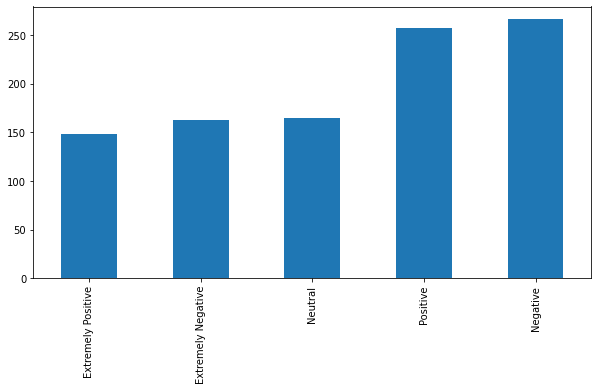

In [39]:
x = Train_Data.Sentiment.value_counts().sort_values().plot(kind = 'bar', figsize = (10, 5))

In [40]:
Test_Data['Sentiment'].value_counts(normalize= True)

Negative              0.27
Positive              0.21
Extremely Negative    0.20
Extremely Positive    0.19
Neutral               0.13
Name: Sentiment, dtype: float64

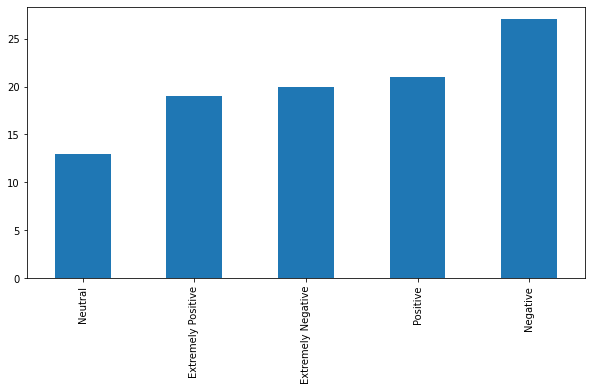

In [41]:
x = Test_Data.Sentiment.value_counts().sort_values().plot(kind = 'bar', figsize = (10, 5))

### 6. Graphically summarize the length of the text of the Tweet_texts using:
+ boxplot
+ histogram
+ density plot

In [42]:
# Before doing this problem, it is necessary to get the origional Tweet_texts data
Original_Train_Data = pd.read_csv('Corona_NLP_train.csv', encoding = 'latin-1').head(1000)
Original_Test_Data = pd.read_csv('Corona_NLP_test.csv').head(100)

Original_Train_Data = Original_Train_Data.fillna('')
Original_Test_Data = Original_Test_Data.fillna('')

Concatenation = ["Location", "TweetAt", "OriginalTweet"]
Original_Train_Data["Tweet_texts"] = Original_Train_Data[Concatenation].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
Original_Test_Data["Tweet_texts"] = Original_Test_Data[Concatenation].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [43]:
Train_Data["Len_Text_BC"] = Original_Train_Data["Tweet_texts"].str.len()
Train_Data["Len_Text_AC"] = Train_Data["Tweet_texts"].str.len()

pd.options.display.float_format = "{:.2f}".format
Train_Data[["Len_Text_BC", "Len_Text_AC"]].describe()

Len_Text_BC  Len_Text_AC
count       999.00       999.00
mean        235.38       152.42
std          65.89        57.79
min          41.00        13.00
25%         191.00       110.00
50%         246.00       158.00
75%         288.00       201.00
max         411.00       314.00

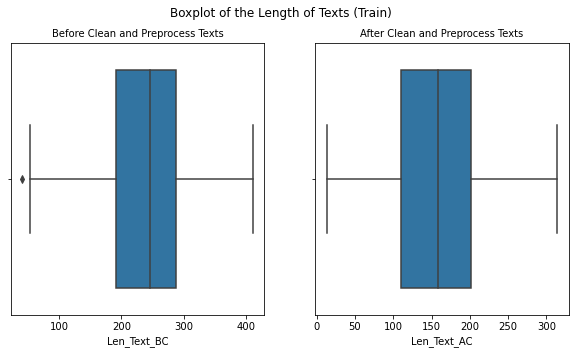

In [44]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Boxplot of the Length of Texts (Train)', fontsize = 12)

sns.boxplot(ax = axes[0], x = Train_Data["Len_Text_BC"])
axes[0].set_title("Before Clean and Preprocess Texts", fontsize = 10)

sns.boxplot(ax = axes[1], x = Train_Data["Len_Text_AC"])
x = axes[1].set_title("After Clean and Preprocess Texts", fontsize = 10)

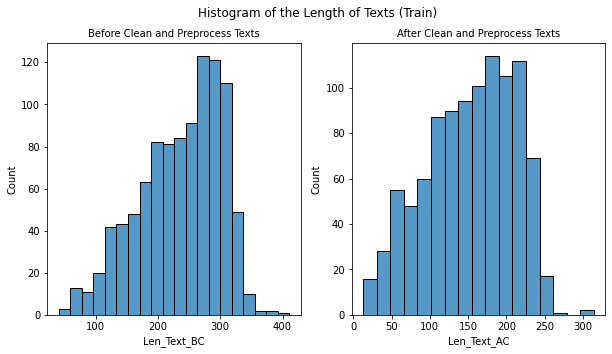

In [45]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Histogram of the Length of Texts (Train)', fontsize = 12)

sns.histplot(ax = axes[0], data = Train_Data, x = "Len_Text_BC")
axes[0].set_title("Before Clean and Preprocess Texts", fontsize = 10)

sns.histplot(ax = axes[1], data = Train_Data, x = "Len_Text_AC")
x = axes[1].set_title("After Clean and Preprocess Texts", fontsize = 10)

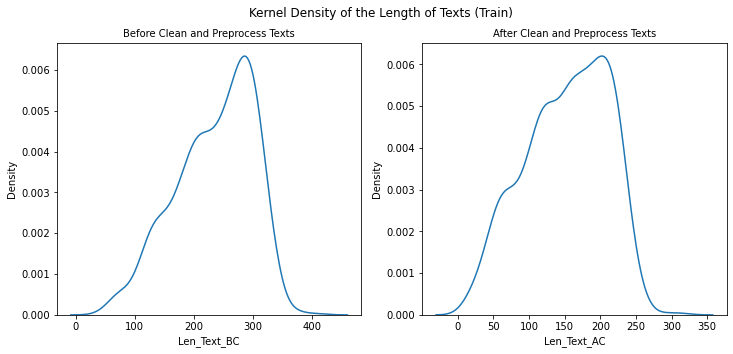

In [46]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
fig.suptitle('Kernel Density of the Length of Texts (Train)', fontsize = 12)

sns.kdeplot(ax = axes[0], data = Train_Data, x = "Len_Text_BC")
axes[0].set_title("Before Clean and Preprocess Texts", fontsize = 10)

sns.kdeplot(ax = axes[1], data = Train_Data, x = "Len_Text_AC")
x = axes[1].set_title("After Clean and Preprocess Texts", fontsize = 10)

In [47]:
Test_Data["Len_Text_BC"] = Original_Test_Data["Tweet_texts"].str.len()
Test_Data["Len_Text_AC"] = Test_Data["Tweet_texts"].str.len()

pd.options.display.float_format = "{:.2f}".format
Test_Data[["Len_Text_BC", "Len_Text_AC"]].describe()

Len_Text_BC  Len_Text_AC
count       100.00       100.00
mean        261.40       160.51
std          62.48        55.43
min          85.00        27.00
25%         226.75       126.25
50%         284.00       169.50
75%         305.50       204.25
max         341.00       265.00

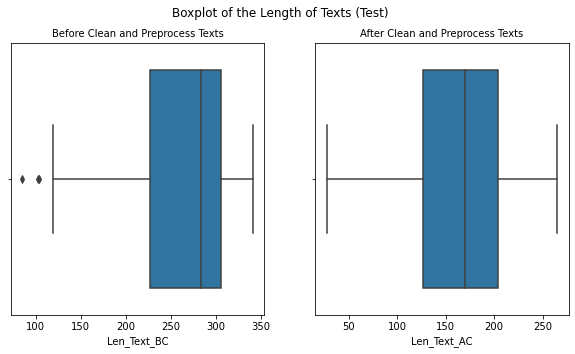

In [48]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Boxplot of the Length of Texts (Test)', fontsize = 12)

sns.boxplot(ax = axes[0], x = Test_Data["Len_Text_BC"])
axes[0].set_title("Before Clean and Preprocess Texts", fontsize = 10)

sns.boxplot(ax = axes[1], x = Test_Data["Len_Text_AC"])
x = axes[1].set_title("After Clean and Preprocess Texts", fontsize = 10)

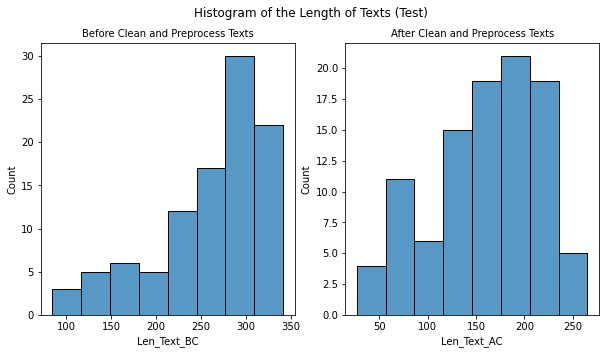

In [49]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Histogram of the Length of Texts (Test)', fontsize = 12)

sns.histplot(ax = axes[0], data = Test_Data, x = "Len_Text_BC")
axes[0].set_title("Before Clean and Preprocess Texts", fontsize = 10)

sns.histplot(ax = axes[1], data = Test_Data, x = "Len_Text_AC")
x = axes[1].set_title("After Clean and Preprocess Texts", fontsize = 10)

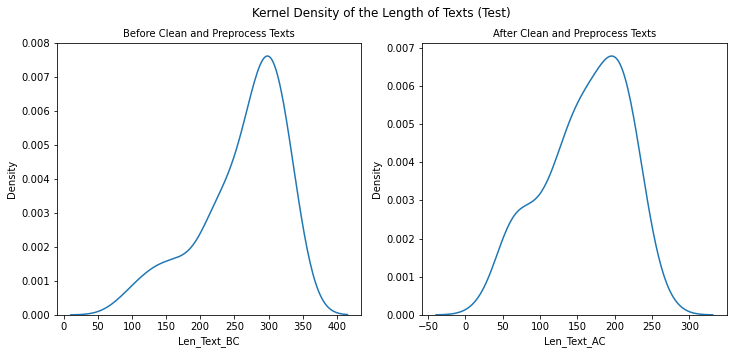

In [50]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
fig.suptitle('Kernel Density of the Length of Texts (Test)', fontsize = 12)

sns.kdeplot(ax = axes[0], data = Test_Data, x = "Len_Text_BC")
axes[0].set_title("Before Clean and Preprocess Texts", fontsize = 10)

sns.kdeplot(ax = axes[1], data = Test_Data, x = "Len_Text_AC")
x = axes[1].set_title("After Clean and Preprocess Texts", fontsize = 10)

### 7. Graphically summarize the word count of the text of the Tweet_texts using:
+ boxplot
+ histogram
+ density plot

In [51]:
Train_Data["Count_Word_BC"] = Original_Train_Data["Tweet_texts"].str.split().str.len()
Train_Data["Count_Word_AC"] = Train_Data["Tweet_texts"].str.split().str.len()

pd.options.display.float_format = "{:.2f}".format
Train_Data[["Count_Word_BC", "Count_Word_AC"]].describe()

Count_Word_BC  Count_Word_AC
count         999.00         999.00
mean           35.30          25.25
std            11.82           9.94
min             7.00           2.00
25%            26.00          18.00
50%            36.00          26.00
75%            45.00          33.00
max            64.00          49.00

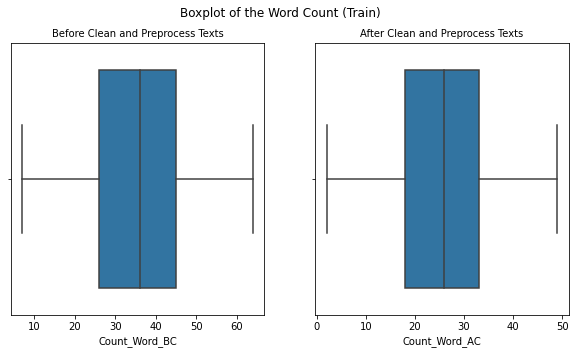

In [52]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Boxplot of the Word Count (Train)', fontsize = 12)

sns.boxplot(ax = axes[0], x = Train_Data["Count_Word_BC"])
axes[0].set_title("Before Clean and Preprocess Texts", fontsize = 10)

sns.boxplot(ax = axes[1], x = Train_Data["Count_Word_AC"])
x = axes[1].set_title("After Clean and Preprocess Texts", fontsize = 10)

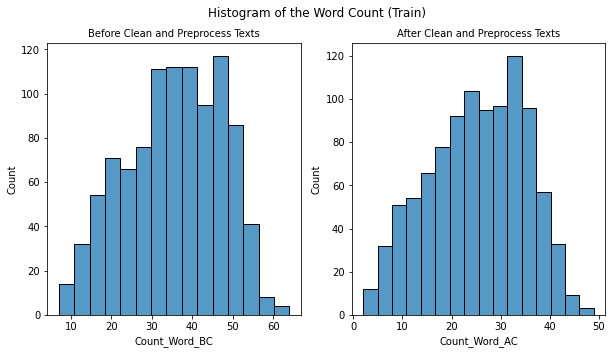

In [53]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Histogram of the Word Count (Train)', fontsize = 12)

sns.histplot(ax = axes[0], data = Train_Data, x = "Count_Word_BC")
axes[0].set_title("Before Clean and Preprocess Texts", fontsize = 10)

sns.histplot(ax = axes[1], data = Train_Data, x = "Count_Word_AC")
x = axes[1].set_title("After Clean and Preprocess Texts", fontsize = 10)

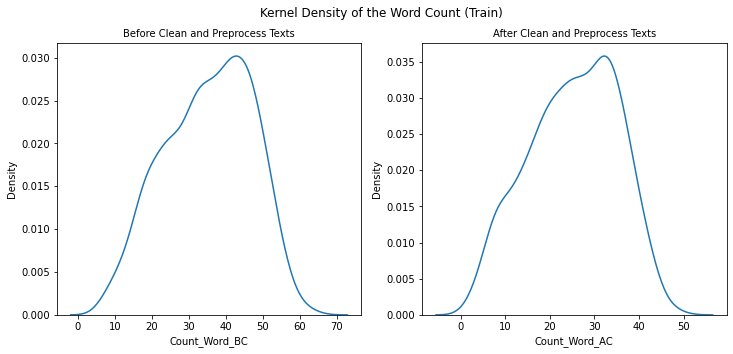

In [54]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
fig.suptitle('Kernel Density of the Word Count (Train)', fontsize = 12)

sns.kdeplot(ax = axes[0], data = Train_Data, x = "Count_Word_BC")
axes[0].set_title("Before Clean and Preprocess Texts", fontsize = 10)

sns.kdeplot(ax = axes[1], data = Train_Data, x = "Count_Word_AC")
x = axes[1].set_title("After Clean and Preprocess Texts", fontsize = 10)

In [55]:
Test_Data["Count_Word_BC"] = Original_Test_Data["Tweet_texts"].str.split().str.len()
Test_Data["Count_Word_AC"] = Test_Data["Tweet_texts"].str.split().str.len()

pd.options.display.float_format = "{:.2f}".format
Test_Data[["Count_Word_BC", "Count_Word_AC"]].describe()

Count_Word_BC  Count_Word_AC
count         100.00         100.00
mean           37.68          26.76
std            10.98           9.59
min            13.00           5.00
25%            30.75          20.00
50%            40.00          27.00
75%            46.00          34.00
max            54.00          47.00

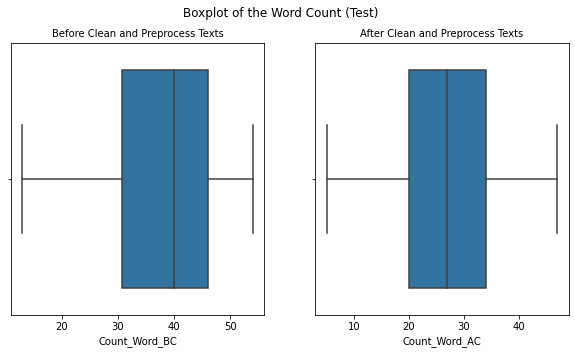

In [56]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Boxplot of the Word Count (Test)', fontsize = 12)

sns.boxplot(ax = axes[0], x = Test_Data["Count_Word_BC"])
axes[0].set_title("Before Clean and Preprocess Texts", fontsize = 10)

sns.boxplot(ax = axes[1], x = Test_Data["Count_Word_AC"])
x = axes[1].set_title("After Clean and Preprocess Texts", fontsize = 10)

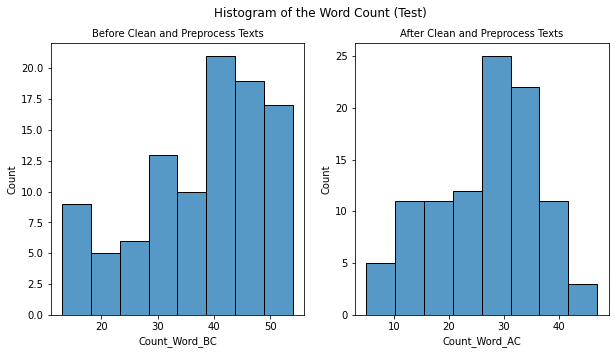

In [57]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Histogram of the Word Count (Test)', fontsize = 12)

sns.histplot(ax = axes[0], data = Test_Data, x = "Count_Word_BC")
axes[0].set_title("Before Clean and Preprocess Texts", fontsize = 10)

sns.histplot(ax = axes[1], data = Test_Data, x = "Count_Word_AC")
x = axes[1].set_title("After Clean and Preprocess Texts", fontsize = 10)

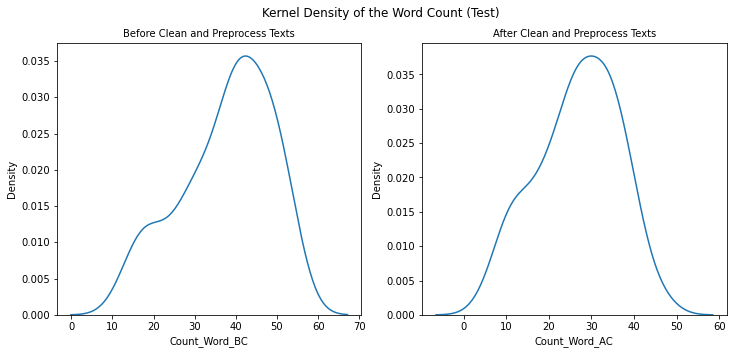

In [58]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
fig.suptitle('Kernel Density of the Word Count (Test)', fontsize = 12)

sns.kdeplot(ax = axes[0], data = Test_Data, x = "Count_Word_BC")
axes[0].set_title("Before Clean and Preprocess Texts", fontsize = 10)

sns.kdeplot(ax = axes[1], data = Test_Data, x = "Count_Word_AC")
x = axes[1].set_title("After Clean and Preprocess Texts", fontsize = 10)

### 8. Graphically summarize the top 10 unigram and bigrams of the tf-idf of the text of the Tweet_texts.

In [59]:
def get_top_tf_idf_words(df = Original_Train_Data, col = "Tweet_texts", use_idf = True, ngram_range = (1, 1), top_n = 10):    
    tf_idf = TfidfVectorizer(stop_words = 'english', ngram_range = ngram_range, use_idf = use_idf)
    X_sparse_matrix = tf_idf.fit_transform(df[col])
    feature_names = np.array(tf_idf.get_feature_names())
    tf_idf_sparse_matrix = tf_idf.transform(df[col])
    sorted_idx = np.argsort(tf_idf_sparse_matrix.data)[:-(top_n+1):-1]
    
    return pd.DataFrame(
    {'feature': feature_names[tf_idf_sparse_matrix.indices[sorted_idx]],
     'tf_idf': tf_idf_sparse_matrix.data[sorted_idx]})

In [60]:
ngram_range = (1, 1)
top_n = 10

Df_Text_BC = get_top_tf_idf_words(df = Original_Train_Data, col = "Tweet_texts", top_n = top_n, ngram_range = ngram_range)
Df_Text_AC = get_top_tf_idf_words(df = Train_Data, col = "Tweet_texts", top_n = top_n, ngram_range = ngram_range)

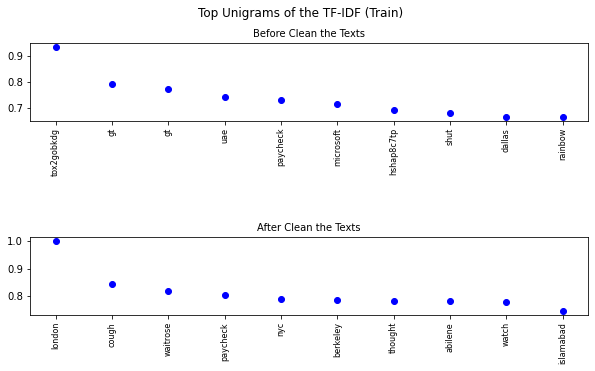

In [61]:
x = range(0, top_n)

fig, ax = plt.subplots(2, 1, figsize = (10, 5))
fig.suptitle('Top Unigrams of the TF-IDF (Train)', fontsize = 12)

ax[0].plot(x, Df_Text_BC.tf_idf, 'bo')
ax[0].set_title('Before Clean the Texts', fontsize = 10)
ax[0].set_xticks(x)
x_ticks_labels = Df_Text_BC.feature
ax[0].set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize = 8)

ax[1].plot(x, Df_Text_AC.tf_idf, 'bo')
ax[1].set_title('After Clean the Texts', fontsize = 10)
ax[1].set_xticks(x)
x_ticks_labels = Df_Text_AC.feature
ax[1].set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize = 8)

fig.subplots_adjust(hspace = 1.5)
plt.show()

In [62]:
ngram_range = (2, 2)
top_n = 10

Df_Text_BC = get_top_tf_idf_words(df = Original_Train_Data, col = "Tweet_texts", top_n = top_n, ngram_range = ngram_range)
Df_Text_AC = get_top_tf_idf_words(df = Train_Data, col = "Tweet_texts", top_n = top_n, ngram_range = ngram_range)

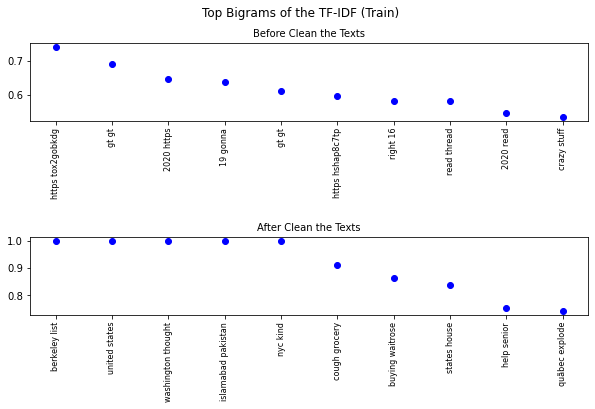

In [63]:
x = range(0, top_n)

fig, ax = plt.subplots(2, 1, figsize = (10, 5))
fig.suptitle('Top Bigrams of the TF-IDF (Train)', fontsize = 12)

ax[0].plot(x, Df_Text_BC.tf_idf, 'bo')
ax[0].set_title('Before Clean the Texts', fontsize = 10)
ax[0].set_xticks(x)
x_ticks_labels = Df_Text_BC.feature
ax[0].set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize = 8)

ax[1].plot(x, Df_Text_AC.tf_idf, 'bo')
ax[1].set_title('After Clean the Texts', fontsize = 10)
ax[1].set_xticks(x)
x_ticks_labels = Df_Text_AC.feature
ax[1].set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize = 8)

fig.subplots_adjust(hspace = 1.5)
plt.show()

In [64]:
ngram_range = (1, 1)
top_n = 10

Df_Text_BC = get_top_tf_idf_words(df = Original_Test_Data, col = "Tweet_texts", top_n = top_n, ngram_range = ngram_range)
Df_Text_AC = get_top_tf_idf_words(df = Test_Data, col = "Tweet_texts", top_n = top_n, ngram_range = ngram_range)

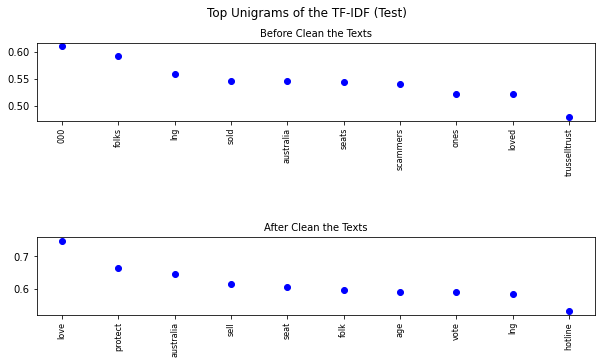

In [65]:
x = range(0, top_n)

fig, ax = plt.subplots(2, 1, figsize = (10, 5))
fig.suptitle('Top Unigrams of the TF-IDF (Test)', fontsize = 12)

ax[0].plot(x, Df_Text_BC.tf_idf, 'bo')
ax[0].set_title('Before Clean the Texts', fontsize = 10)
ax[0].set_xticks(x)
x_ticks_labels = Df_Text_BC.feature
ax[0].set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize = 8)

ax[1].plot(x, Df_Text_AC.tf_idf, 'bo')
ax[1].set_title('After Clean the Texts', fontsize = 10)
ax[1].set_xticks(x)
x_ticks_labels = Df_Text_AC.feature
ax[1].set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize = 8)

fig.subplots_adjust(hspace = 1.5)
plt.show()

In [66]:
ngram_range = (2, 2)
top_n = 10

Df_Text_BC = get_top_tf_idf_words(df = Original_Test_Data, col = "Tweet_texts", top_n = top_n, ngram_range = ngram_range)
Df_Text_AC = get_top_tf_idf_words(df = Test_Data, col = "Tweet_texts", top_n = top_n, ngram_range = ngram_range)

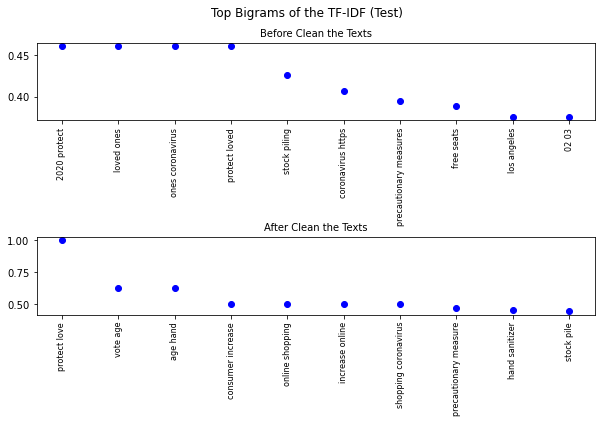

In [67]:
x = range(0, top_n)

fig, ax = plt.subplots(2, 1, figsize = (10, 5))
fig.suptitle('Top Bigrams of the TF-IDF (Test)', fontsize = 12)

ax[0].plot(x, Df_Text_BC.tf_idf, 'bo')
ax[0].set_title('Before Clean the Texts', fontsize = 10)
ax[0].set_xticks(x)
x_ticks_labels = Df_Text_BC.feature
ax[0].set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize = 8)

ax[1].plot(x, Df_Text_AC.tf_idf, 'bo')
ax[1].set_title('After Clean the Texts', fontsize = 10)
ax[1].set_xticks(x)
x_ticks_labels = Df_Text_AC.feature
ax[1].set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize = 8)

fig.subplots_adjust(hspace = 1.5)
plt.show()

### 9. Visualize the top 10 term frequency of the tokens associated with positive tweets using scattertext.

### 10. Visualize the top 10 positive scores of the tokens associated with positive tweets using scattertext.

In [68]:
# I found that a lot of space could be saved if #9 and #10 were done together. It was necessary to create new
# dataframes so that tweets with "Positive" and "Extremely Positive" sentiments could be grouped together without 
# affecting the ones I currently have

In [69]:
Original_Train_Data_Positive = Original_Train_Data.copy()
Original_Train_Data_Positive.loc[Original_Train_Data_Positive["Sentiment"] == "Extremely Positive", "Sentiment"] = "Positive"

Train_Data_Positive = Train_Data.copy()
Train_Data_Positive.loc[Original_Train_Data_Positive["Sentiment"] == "Extremely Positive", "Sentiment"] = "Positive"

Original_Test_Data_Positive = Original_Test_Data.copy()
Original_Test_Data_Positive.loc[Original_Test_Data_Positive["Sentiment"] == "Extremely Positive", "Sentiment"] = "Positive"

Test_Data_Positive = Test_Data.copy()
Test_Data_Positive.loc[Original_Test_Data_Positive["Sentiment"] == "Extremely Positive", "Sentiment"] = "Positive"

In [70]:
Corpus_BC = st.CorpusFromPandas(Original_Train_Data_Positive, category_col = 'Sentiment', text_col = 'Tweet_texts', nlp = nlp).build()
Corpus_AC = st.CorpusFromPandas(Train_Data_Positive, category_col = 'Sentiment', text_col = 'Tweet_texts', nlp = nlp).build()

In [71]:
Term_Freq_Df_BC = Corpus_BC.get_term_freq_df()
Term_Freq_Df_BC['Positive Score'] = Corpus_BC.get_scaled_f_scores("Positive")

Term_Freq_Df_BC_Freq = Term_Freq_Df_BC.sort_values(by = 'Positive freq', ascending = False)
Term_Freq_Df_BC_Score = Term_Freq_Df_BC.sort_values(by = 'Positive Score', ascending = False)

Term_Freq_Df_AC = Corpus_AC.get_term_freq_df()
Term_Freq_Df_AC['Positive Score'] = Corpus_AC.get_scaled_f_scores("Positive")

Term_Freq_Df_AC_Freq = Term_Freq_Df_AC.sort_values(by = 'Positive freq', ascending = False)
Term_Freq_Df_AC_Score = Term_Freq_Df_AC.sort_values(by = 'Positive Score', ascending = False)

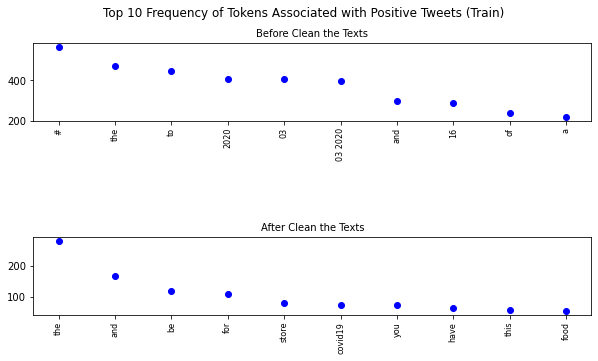

In [72]:
top_n = 10
Term_Freq_Df_AC_Freq = Term_Freq_Df_AC_Freq.head(top_n)
Term_Freq_Df_BC_Freq = Term_Freq_Df_BC_Freq.head(top_n)
x = range(0, top_n)

fig, ax = plt.subplots(2, 1, figsize = (10, 5))

fig.suptitle('Top 10 Frequency of Tokens Associated with Positive Tweets (Train)', fontsize= 12)

ax[0].plot(x, Term_Freq_Df_BC_Freq["Positive freq"], 'bo')
ax[0].set_title('Before Clean the Texts', fontsize = 10)
ax[0].set_xticks(x)
x_ticks_labels = Term_Freq_Df_BC_Freq.index
ax[0].set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize = 8)

ax[1].plot(x, Term_Freq_Df_AC_Freq["Positive freq"], 'bo')
ax[1].set_title('After Clean the Texts', fontsize = 10)
ax[1].set_xticks(x)
x_ticks_labels = Term_Freq_Df_AC_Freq.index
ax[1].set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize = 8)

fig.subplots_adjust(hspace = 1.5)
plt.show()

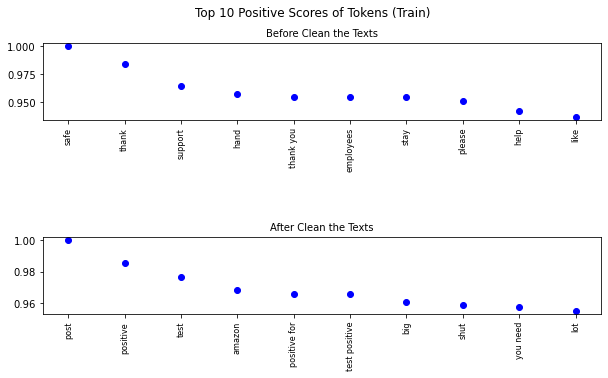

In [73]:
top_n = 10
Term_Freq_Df_AC_Score = Term_Freq_Df_AC_Score.head(top_n)
Term_Freq_Df_BC_Score = Term_Freq_Df_BC_Score.head(top_n)
x = range(0, top_n)

fig, ax = plt.subplots(2, 1, figsize = (10, 5))

fig.suptitle('Top 10 Positive Scores of Tokens (Train)', fontsize = 12)

ax[0].plot(x, Term_Freq_Df_BC_Score["Positive Score"], 'bo')
ax[0].set_title('Before Clean the Texts', fontsize = 10)
ax[0].set_xticks(x)
x_ticks_labels = Term_Freq_Df_BC_Score.index
ax[0].set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize = 8)

ax[1].plot(x, Term_Freq_Df_AC_Score["Positive Score"], 'bo')
ax[1].set_title('After Clean the Texts', fontsize = 10)
ax[1].set_xticks(x)
x_ticks_labels = Term_Freq_Df_AC_Score.index
ax[1].set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize = 8)

fig.subplots_adjust(hspace = 1.5)
plt.show()

In [74]:
Corpus_BC = st.CorpusFromPandas(Original_Test_Data_Positive, category_col = 'Sentiment', text_col = 'Tweet_texts', nlp = nlp).build()
Corpus_AC = st.CorpusFromPandas(Test_Data_Positive, category_col = 'Sentiment', text_col = 'Tweet_texts', nlp = nlp).build()

In [75]:
Term_Freq_Df_BC = Corpus_BC.get_term_freq_df()
Term_Freq_Df_BC['Positive Score'] = Corpus_BC.get_scaled_f_scores("Positive")

Term_Freq_Df_BC_Freq = Term_Freq_Df_BC.sort_values(by = 'Positive freq', ascending = False)
Term_Freq_Df_BC_Score = Term_Freq_Df_BC.sort_values(by = 'Positive Score', ascending = False)

Term_Freq_Df_AC = Corpus_AC.get_term_freq_df()
Term_Freq_Df_AC['Positive Score'] = Corpus_AC.get_scaled_f_scores("Positive")

Term_Freq_Df_AC_Freq = Term_Freq_Df_AC.sort_values(by = 'Positive freq', ascending = False)
Term_Freq_Df_AC_Score = Term_Freq_Df_AC.sort_values(by = 'Positive Score', ascending = False)

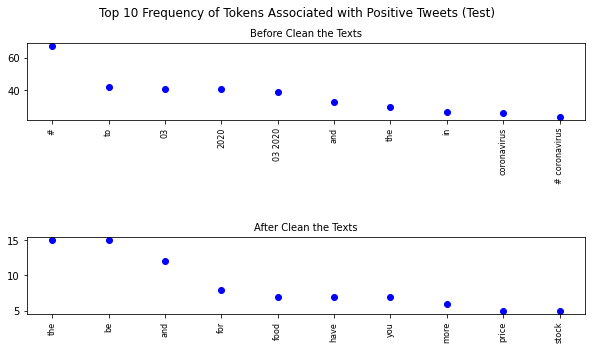

In [76]:
top_n = 10
Term_Freq_Df_AC_Freq = Term_Freq_Df_AC_Freq.head(top_n)
Term_Freq_Df_BC_Freq = Term_Freq_Df_BC_Freq.head(top_n)
x = range(0, top_n)

fig, ax = plt.subplots(2, 1, figsize = (10, 5))

fig.suptitle('Top 10 Frequency of Tokens Associated with Positive Tweets (Test)', fontsize= 12)

ax[0].plot(x, Term_Freq_Df_BC_Freq["Positive freq"], 'bo')
ax[0].set_title('Before Clean the Texts', fontsize = 10)
ax[0].set_xticks(x)
x_ticks_labels = Term_Freq_Df_BC_Freq.index
ax[0].set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize = 8)

ax[1].plot(x, Term_Freq_Df_AC_Freq["Positive freq"], 'bo')
ax[1].set_title('After Clean the Texts', fontsize = 10)
ax[1].set_xticks(x)
x_ticks_labels = Term_Freq_Df_AC_Freq.index
ax[1].set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize = 8)

fig.subplots_adjust(hspace = 1.5)
plt.show()

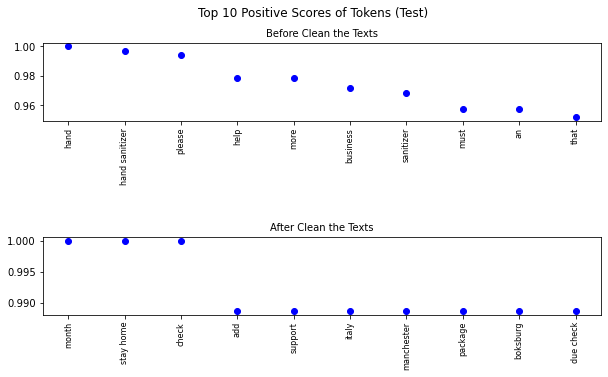

In [77]:
top_n = 10
Term_Freq_Df_AC_Score = Term_Freq_Df_AC_Score.head(top_n)
Term_Freq_Df_BC_Score = Term_Freq_Df_BC_Score.head(top_n)
x = range(0, top_n)

fig, ax = plt.subplots(2, 1, figsize = (10, 5))

fig.suptitle('Top 10 Positive Scores of Tokens (Test)', fontsize = 12)

ax[0].plot(x, Term_Freq_Df_BC_Score["Positive Score"], 'bo')
ax[0].set_title('Before Clean the Texts', fontsize = 10)
ax[0].set_xticks(x)
x_ticks_labels = Term_Freq_Df_BC_Score.index
ax[0].set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize = 8)

ax[1].plot(x, Term_Freq_Df_AC_Score["Positive Score"], 'bo')
ax[1].set_title('After Clean the Texts', fontsize = 10)
ax[1].set_xticks(x)
x_ticks_labels = Term_Freq_Df_AC_Score.index
ax[1].set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize = 8)

fig.subplots_adjust(hspace = 1.5)
plt.show()

### 11. Convert the column of the Tweet_texts to a matrix of token counts using CountVectorizer and unigrams and bigrams.

In [78]:
vectorizer = CountVectorizer(ngram_range = (1, 2))

matrix = vectorizer.fit_transform(Train_Data['Tweet_texts'])

print(f'The size of the feature matrix for the texts is {matrix.get_shape()}')
print(f'The first row of the feature matrix:\n{matrix[0, ]}')
print(f'There are {matrix[0, ].count_nonzero()}/{matrix.get_shape()[1]} non-zeros.')

The size of the feature matrix for the texts is (999, 22264)
The first row of the feature matrix:
  (0, 11081)	1
  (0, 1175)	2
  (0, 11083)	1
  (0, 1193)	1
There are 4/22264 non-zeros.


In [79]:
vectorizer = CountVectorizer(ngram_range = (1, 2))

matrix = vectorizer.fit_transform(Test_Data['Tweet_texts'])

print(f'The size of the feature matrix for the texts is {matrix.get_shape()}')
print(f'The first row of the feature matrix:\n{matrix[0, ]}')
print(f'There are {matrix[0, ].count_nonzero()}/{matrix.get_shape()[1]} non-zeros.')

The size of the feature matrix for the texts is (100, 3452)
The first row of the feature matrix:
  (0, 2014)	1
  (0, 3084)	1
  (0, 1954)	1
  (0, 3407)	1
  (0, 1009)	1
  (0, 1006)	1
  (0, 2753)	1
  (0, 2551)	1
  (0, 2196)	1
  (0, 3252)	1
  (0, 487)	1
  (0, 2618)	1
  (0, 2045)	1
  (0, 1349)	1
  (0, 1178)	1
  (0, 1830)	1
  (0, 2558)	1
  (0, 2697)	1
  (0, 2015)	1
  (0, 3085)	1
  (0, 1962)	1
  (0, 3408)	1
  (0, 1010)	1
  (0, 1008)	1
  (0, 2758)	1
  (0, 2553)	1
  (0, 2197)	1
  (0, 3253)	1
  (0, 488)	1
  (0, 2619)	1
  (0, 2047)	1
  (0, 1350)	1
  (0, 1179)	1
  (0, 1831)	1
  (0, 2559)	1
There are 35/3452 non-zeros.


### 12. Perform the tf-idf analysis on the column of the Tweet_texts using Tfidfvectorizer.

In [80]:
tfidf_vectorizer = TfidfVectorizer(use_idf = True, smooth_idf = True, sublinear_tf = False)

tf_idf_matrix = tfidf_vectorizer.fit_transform(Train_Data['Tweet_texts'])

print(f'The size of the tf_idf matrix for the texts = {tf_idf_matrix.get_shape()}')
print(f'The sparse tf_idf matrix is as follows:')
print(tf_idf_matrix)

The size of the tf_idf matrix for the texts = (999, 4318)
The sparse tf_idf matrix is as follows:
  (0, 264)	0.621454220321183
  (0, 2260)	0.7834504783615812
  (1, 2697)	0.12238929509229445
  (1, 2726)	0.12527118210289453
  (1, 2613)	0.08754748155038569
  (1, 601)	0.09439848196594817
  (1, 2371)	0.2009779631404302
  (1, 3144)	0.18051910235521337
  (1, 3691)	0.11065132558117242
  (1, 161)	0.21294562950725662
  (1, 2928)	0.21294562950725662
  (1, 135)	0.17596920676740366
  (1, 3441)	0.09520718726590995
  (1, 2667)	0.09089247935272055
  (1, 3397)	0.16006024156999651
  (1, 720)	0.21294562950725662
  (1, 1297)	0.18590048664588915
  (1, 3342)	0.1685514359883869
  (1, 4204)	0.08492660275449933
  (1, 2236)	0.15769770925493784
  (1, 877)	0.16262846041079565
  (1, 944)	0.14649673266923882
  (1, 2624)	0.32012048313999303
  (1, 2855)	0.3718009732917783
  (1, 1376)	0.2009779631404302
  :	:
  (998, 1134)	0.22622500654522773
  (998, 3383)	0.20925348307387207
  (998, 3005)	0.19807462634547035
  (998, 

In [81]:
tfidf_vectorizer = TfidfVectorizer(use_idf = True, smooth_idf = True, sublinear_tf = False)

tf_idf_matrix = tfidf_vectorizer.fit_transform(Test_Data['Tweet_texts'])

print(f'The size of the tf_idf matrix for the texts = {tf_idf_matrix.get_shape()}')
print(f'The sparse tf_idf matrix is as follows:')
print(tf_idf_matrix)

The size of the tf_idf matrix for the texts = (100, 1100)
The sparse tf_idf matrix is as follows:
  (0, 910)	0.12841367475728277
  (0, 861)	0.23389872031841127
  (0, 606)	0.2548967491338323
  (0, 400)	0.2548967491338323
  (0, 448)	0.2548967491338323
  (0, 681)	0.19800235296232582
  (0, 882)	0.2548967491338323
  (0, 151)	0.2548967491338323
  (0, 1056)	0.2548967491338323
  (0, 725)	0.2548967491338323
  (0, 859)	0.23389872031841127
  (0, 923)	0.19800235296232582
  (0, 338)	0.23389872031841127
  (0, 339)	0.2548967491338323
  (0, 1095)	0.2548967491338323
  (0, 652)	0.16210598560624037
  (0, 997)	0.2548967491338323
  (0, 668)	0.2548967491338323
  (1, 748)	0.12391930857638915
  (1, 319)	0.2402573058410026
  (1, 107)	0.11087622408713063
  (1, 225)	0.2402573058410026
  (1, 488)	0.1614961234134353
  (1, 693)	0.1827840258629766
  (1, 768)	0.27963789705478626
  :	:
  (97, 958)	0.07385663109437036
  (97, 413)	0.13981699665670944
  (97, 74)	0.16386049111943124
  (97, 403)	0.08709814483834369
  (97, 

### 13. Find the cosine similarity in Tweet_texts between the 200th and 20,000th tweets.

In [82]:
# Because a subset of Train_Data is being used, I will instead compare the 50th and 500th tweets.
nlp = spacy.load("en_core_web_lg")

tfidf_vectorizer = TfidfVectorizer(use_idf = True, smooth_idf = True, sublinear_tf = False)

two_tweets = Train_Data.loc[[50, 500],:]
tf_idf_matrix = tfidf_vectorizer.fit_transform(two_tweets['Tweet_texts'])
print(f'The size of the tf_idf matrix for the texts = {tf_idf_matrix.get_shape()}.')

The size of the tf_idf matrix for the texts = (2, 36).


In [83]:
cos_sim = 1 - spatial.distance.cosine(tf_idf_matrix[0, :].todense(), tf_idf_matrix[1, :].todense())
print(f'The cosine similarity between "{two_tweets.loc[two_tweets.index[0], "Tweet_texts"]}" and "{two_tweets.loc[two_tweets.index[1], "Tweet_texts"]}" = {cos_sim}.')

The cosine similarity between "washington everything weâ see the current covid19 outbreak have be see before previous epidemic and pandemic the rise fear racism panic buy food and medicine conspiracy theory the proliferation quack cure" and "weâ still part community even when weâ ourselves stay home and stay positive" = 0.0855780603148345.


### 14. Find the corpus vector equal to the average of all the document vectors, where each document corresponds to a tweet or a row in this dataset.

In [84]:
corpus_vector = np.array([nlp(str(doc)).vector for doc in Train_Data['Tweet_texts']]).mean(axis=0)
print(corpus_vector)

[-7.74843767e-02  1.17692173e-01 -9.24303681e-02 -3.84936817e-02
  1.07120559e-01 -2.87708677e-02 -3.36263962e-02 -6.03675731e-02
  3.72833423e-02  1.99176824e+00 -2.72698075e-01 -1.98098086e-02
  4.00472470e-02 -5.85071221e-02 -8.02108571e-02 -5.90778515e-02
 -8.77127573e-02  1.05396998e+00 -1.00991324e-01  3.75872254e-02
  5.52353496e-03  1.71210226e-02 -2.12398567e-03 -7.46101663e-02
 -2.91791707e-02  2.23060846e-02 -9.57759470e-02 -6.57887906e-02
  3.56849022e-02 -4.89197746e-02 -5.45698106e-02  1.04047339e-02
  6.80460315e-03  3.36349197e-02  5.69326989e-02  2.97054742e-02
  1.69613902e-02  2.19977815e-02 -2.41583232e-02 -5.05597144e-03
 -4.24128957e-02  3.23339589e-02  3.29294987e-02 -6.35066703e-02
 -1.30297535e-03  6.22292385e-02 -1.01952754e-01 -1.66578162e-02
  1.26031116e-02  2.76129656e-02 -6.47398755e-02 -2.22752728e-02
  4.49910648e-02 -8.22575670e-03  8.59659240e-02 -2.10875291e-02
 -3.14267650e-02 -7.25558028e-02 -1.18406955e-02 -7.18165487e-02
 -1.82248987e-02 -9.74191

### 15. Build the first model based on the training dataset using the random forests and pipeline.

In [85]:
# Before building the model, it is necessary to define a few functions and split the data.

nlp = spacy.load("en_core_web_sm")

stop_words = spacy.lang.en.stop_words.STOP_WORDS

def spacy_tokenizer(sentence):
    mytokens = nlp(sentence)
    mytokens = [word.lemma_ for word in mytokens if word not in stop_words]
    return mytokens 

In [86]:
# Although the text has already been cleaned, altering the code in this cell doesn't meaningfully change the
# accuracy of any of the models in the next few problems (except maybe the first). Furthermore, changing the 
# code here could adversly affect things later in this notebook, so I have chosen to leave it as it is.

class features(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y = None, **fit_params):
        return self
    def get_params(self, deep = True):
        return {}

def clean_text(text):
    text = ' '.join(re.sub("(nan)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
    return text.strip().lower() 

In [87]:
le = preprocessing.LabelEncoder()
  
Train_Data['Sentiment'] = le.fit_transform(Train_Data['Sentiment'])
Train_Data['Sentiment'].value_counts(normalize = True)

2   0.27
4   0.26
3   0.17
0   0.16
1   0.15
Name: Sentiment, dtype: float64

In [88]:
X = Train_Data['Tweet_texts']
y = Train_Data['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
print(f'X_train dimension: {X_train.shape}; y_train dimension: {y_train.shape}')
print(f'X_test dimension: {X_test.shape}; y_train dimension: {y_test.shape}')

X_train dimension: (799,); y_train dimension: (799,)
X_test dimension: (200,); y_train dimension: (200,)


In [89]:
t0 = time()

tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, ngram_range = (1, 1))
classifier = RandomForestClassifier(random_state = 5)

pipeline = Pipeline ([("cleaner", features()), ("vectorizer", tfidf_vector), ("classifier", classifier)]) 
pipeline.fit(X_train, y_train)

print(f"It takes about {time() - t0:.1f} seconds")

It takes about 4.6 seconds


Confusion Matrix (Without Normalization)
[[ 3  0 26  0  4]
 [ 0  7  5  1 17]
 [ 4  2 27  5 15]
 [ 0  1 10 14  8]
 [ 2  3 11 11 24]]


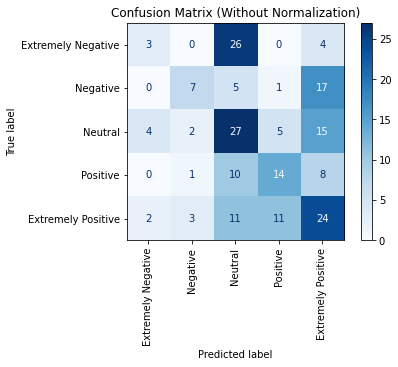

Normalized Confusion Matrix
[[0.09090909 0.         0.78787879 0.         0.12121212]
 [0.         0.23333333 0.16666667 0.03333333 0.56666667]
 [0.0754717  0.03773585 0.50943396 0.09433962 0.28301887]
 [0.         0.03030303 0.3030303  0.42424242 0.24242424]
 [0.03921569 0.05882353 0.21568627 0.21568627 0.47058824]]


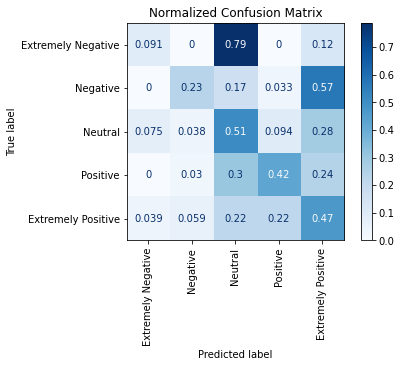

In [90]:
target_names = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', "Extremely Positive"]
titles_options = [("Confusion Matrix (Without Normalization)", None), ("Normalized Confusion Matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(pipeline, X_test, y_test, display_labels = target_names, 
                                 cmap = plt.cm.Blues, normalize = normalize, xticks_rotation = 'vertical')
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    plt.show()

In [91]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred, target_names = target_names))

                    precision    recall  f1-score   support

Extremely Negative       0.33      0.09      0.14        33
          Negative       0.54      0.23      0.33        30
           Neutral       0.34      0.51      0.41        53
          Positive       0.45      0.42      0.44        33
Extremely Positive       0.35      0.47      0.40        51

          accuracy                           0.38       200
         macro avg       0.40      0.35      0.34       200
      weighted avg       0.39      0.38      0.36       200



### 16. Check the first model on the test dataset. Is it a good model based on the selected evaluation metrics? Please justify your answer.

Judging by the precision, recall, and f-1 scores, the model is poor, as most of these values are only between 0.10 and 0.50. It should be noted that the dataset is somewhat unbalanced, so the accuracy metric could be misleading.

### 17. Create the second model using random forest, pipeline, grid search CV for the hyperparameters for the estimators. (Please see all the potential parameters at Scikit Learn's TfidVectorizer and random forests.)

In [92]:
pipeline = Pipeline ([("cleaner", features()), ("vectorizer", TfidfVectorizer(tokenizer = spacy_tokenizer)),
                 ("classifier", RandomForestClassifier())])
parameters = {'vectorizer__max_df': (0.5, 1.0), 'vectorizer__ngram_range': ((1, 1), (1, 2), (2, 2)),
              'vectorizer__use_idf': (True, False), 'classifier__random_state': (None, 5)}
grid_search = GridSearchCV(pipeline, parameters, n_jobs = -1, verbose = 1)

print("The pipeline contains:", [name for name, _ in pipeline.steps])
print("The parameters are as follows:")
pprint(parameters)

t0 = time()
grid_search.fit(X_train, y_train)

print(f"It takes about {time() - t0:.1f} seconds.")
print()

print(f"Best score = {grid_search.best_score_:0.3f}")
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

The pipeline contains: ['cleaner', 'vectorizer', 'classifier']
The parameters are as follows:
{'classifier__random_state': (None, 5),
 'vectorizer__max_df': (0.5, 1.0),
 'vectorizer__ngram_range': ((1, 1), (1, 2), (2, 2)),
 'vectorizer__use_idf': (True, False)}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
It takes about 195.3 seconds.

Best score = 0.369
Best parameters set:
	classifier__random_state: 5
	vectorizer__max_df: 0.5
	vectorizer__ngram_range: (1, 1)
	vectorizer__use_idf: False


### 18. Tune the second model and perform model diagnostics on the test dataset. Is it a good model? Please justify your answer.

Confusion Matrix (Without Normalization)
[[ 3  0 21  1  8]
 [ 0  5  6  3 16]
 [ 1  2 27  7 16]
 [ 1  1  7 14 10]
 [ 2  4 10 12 23]]


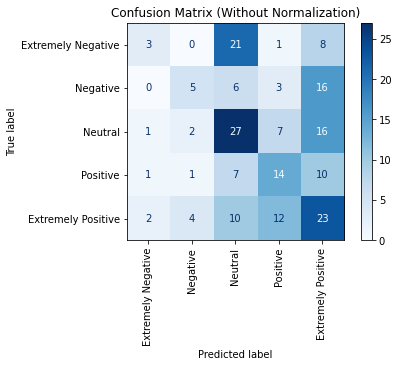

Normalized Confusion Matrix
[[0.09090909 0.         0.63636364 0.03030303 0.24242424]
 [0.         0.16666667 0.2        0.1        0.53333333]
 [0.01886792 0.03773585 0.50943396 0.13207547 0.30188679]
 [0.03030303 0.03030303 0.21212121 0.42424242 0.3030303 ]
 [0.03921569 0.07843137 0.19607843 0.23529412 0.45098039]]


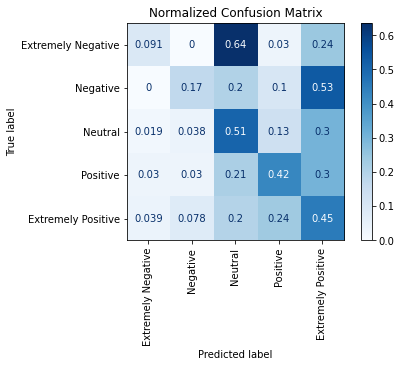

In [93]:
target_names = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', "Extremely Positive"]
titles_options = [("Confusion Matrix (Without Normalization)", None), ("Normalized Confusion Matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(grid_search, X_test, y_test, display_labels = target_names,
                                 cmap = plt.cm.Blues, normalize = normalize, xticks_rotation = 'vertical')
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    plt.show()

In [94]:
y_pred = grid_search.predict(X_test)

print(classification_report(y_test, y_pred, target_names = target_names))

                    precision    recall  f1-score   support

Extremely Negative       0.43      0.09      0.15        33
          Negative       0.42      0.17      0.24        30
           Neutral       0.38      0.51      0.44        53
          Positive       0.38      0.42      0.40        33
Extremely Positive       0.32      0.45      0.37        51

          accuracy                           0.36       200
         macro avg       0.38      0.33      0.32       200
      weighted avg       0.38      0.36      0.34       200



Judging by the precision, recall, and f-1 scores, the model is poor, as most of these values are only between 0.10 and 0.50. As stated in Question 16, it should be noted that the dataset is somewhat unbalanced, so the accuracy metric could be misleading.

### 19. Build the third model using pipeline, grid search CV, hyperparameter for the following classifiers:
+ Logistic Regression
+ Support Vector Machine
+ Random Forest

In [95]:
class ClfSwitcher(BaseEstimator): 
    def __init__(self, estimator = SGDClassifier()):
        self.estimator = estimator
    def fit(self, X, y = None, **kwargs):
        self.estimator.fit(X, y)
        return self
    def predict(self, X, y = None):
        return self.estimator.predict(X)
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    def score(self, X, y):
        return self.estimator.score(X, y)

In [96]:
pipeline = Pipeline ([("cleaner", features()), ("vectorizer", TfidfVectorizer()), ("classifier", ClfSwitcher())]) 

parameters = [{
        'vectorizer__tokenizer': [spacy_tokenizer],
        'vectorizer__max_df': [1.0],
        'vectorizer__norm': ('l1', 'l2'),
        'vectorizer__stop_words': ['english', None],
    
        'classifier__estimator': [LogisticRegression()],
        'classifier__estimator__solver': ['liblinear'],
        'classifier__estimator__penalty': ('l2', 'l1'),
        'classifier__estimator__max_iter': [100, 200],
        'classifier__estimator__tol': [1e-3, 1e-4] 
    },{
        'vectorizer__tokenizer': [spacy_tokenizer],
        'vectorizer__max_df': [1.0],
        'vectorizer__norm': ('l1', 'l2'),
        'vectorizer__stop_words': ['english', None],
    
        'classifier__estimator': [svm.SVC(kernel = 'linear', C = 1.0)],
        'classifier__estimator__max_iter': [-1],
        'classifier__estimator__tol': [1e-3, 1e-4]
    },{
        'vectorizer__tokenizer': [spacy_tokenizer],
        'vectorizer__max_df': [1.0],
        'vectorizer__norm': ('l1', 'l2'),
        'vectorizer__stop_words': ['english', None],
    
        'classifier__estimator': [RandomForestClassifier()],
        'classifier__estimator__random_state': (None, 5)
    }]

print("The pipeline contains:", [name for name, _ in pipeline.steps])
print("parameters are as follows:")
pprint(parameters)

t0 = time()
gscv = GridSearchCV(pipeline, parameters, cv = 5, n_jobs = -1, return_train_score = False, verbose = 3)
gscv.fit(X_train, y_train)
print(f"It takes about {time() - t0:.3f} seconds")

The pipeline contains: ['cleaner', 'vectorizer', 'classifier']
parameters are as follows:
[{'classifier__estimator': [LogisticRegression()],
  'classifier__estimator__max_iter': [100, 200],
  'classifier__estimator__penalty': ('l2', 'l1'),
  'classifier__estimator__solver': ['liblinear'],
  'classifier__estimator__tol': [0.001, 0.0001],
  'vectorizer__max_df': [1.0],
  'vectorizer__norm': ('l1', 'l2'),
  'vectorizer__stop_words': ['english', None],
  'vectorizer__tokenizer': [<function spacy_tokenizer at 0x7ff149b2eee0>]},
 {'classifier__estimator': [SVC(kernel='linear')],
  'classifier__estimator__max_iter': [-1],
  'classifier__estimator__tol': [0.001, 0.0001],
  'vectorizer__max_df': [1.0],
  'vectorizer__norm': ('l1', 'l2'),
  'vectorizer__stop_words': ['english', None],
  'vectorizer__tokenizer': [<function spacy_tokenizer at 0x7ff149b2eee0>]},
 {'classifier__estimator': [RandomForestClassifier()],
  'classifier__estimator__random_state': (None, 5),
  'vectorizer__max_df': [1.0],


/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with 

/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with 

/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with 

/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with 

It takes about 429.820 seconds


In [97]:
print(f"Best score= {gscv.best_score_:0.3f}")

best_parameters = gscv.best_estimator_.get_params()

all_classifiers = []
for parameter in parameters:
    all_classifiers.append(parameter['classifier__estimator'])
all_classifiers = [str(alg) for clf in all_classifiers for alg in clf]
print("All potential classifiers:")
pprint(all_classifiers)

idx = all_classifiers.index(str(best_parameters['classifier__estimator']))
print("Best parameters set:")
for param_name in sorted(parameters[idx].keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score= 0.357
All potential classifiers:
['LogisticRegression()', "SVC(kernel='linear')", 'RandomForestClassifier()']
Best parameters set:
	classifier__estimator: RandomForestClassifier()
	classifier__estimator__random_state: None
	vectorizer__max_df: 1.0
	vectorizer__norm: 'l2'
	vectorizer__stop_words: None
	vectorizer__tokenizer: <function spacy_tokenizer at 0x7ff149b2eee0>


### 20. Tune the third model and perform model diagnostics on the test dataset. Is it a good model? Please justify your answer.

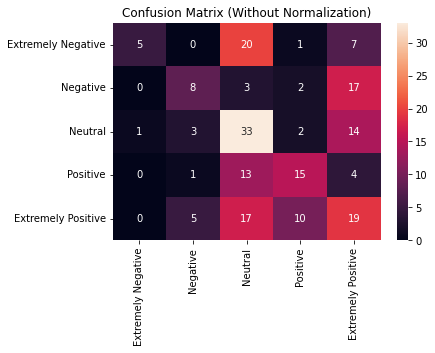

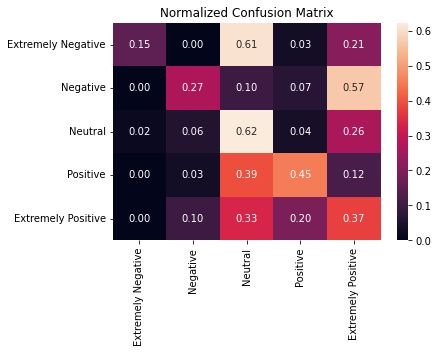

In [98]:
y_pred = gscv.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = target_names, yticklabels = target_names)
ax.set_title("Confusion Matrix (Without Normalization)")
plt.show()

cm = cm / cm.astype(np.float64).sum(axis=1)[:,None]
ax = plt.axes()
sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = target_names, yticklabels = target_names)
ax.set_title("Normalized Confusion Matrix")
plt.show()

In [99]:
print(classification_report(y_test, y_pred, target_names = target_names))

                    precision    recall  f1-score   support

Extremely Negative       0.83      0.15      0.26        33
          Negative       0.47      0.27      0.34        30
           Neutral       0.38      0.62      0.47        53
          Positive       0.50      0.45      0.48        33
Extremely Positive       0.31      0.37      0.34        51

          accuracy                           0.40       200
         macro avg       0.50      0.37      0.38       200
      weighted avg       0.47      0.40      0.38       200



Judging by the precision, recall, and f-1 scores, the model is poor, as most of these values are only between 0.30 and 0.60. As stated in Questions 16 and 18, it should be noted that the dataset is somewhat unbalanced, so the accuracy metric could be misleading.

### 21. Generate the first topic model by setting five topics using LDA method and CountVectorizer.

In [100]:
tf_vectorizer = CountVectorizer(max_df = 0.90, min_df = 5, stop_words = 'english')
document_word_matrix_tf = tf_vectorizer.fit_transform(Train_Data['Tweet_texts'])

lda = LatentDirichletAllocation(n_components = 5)
lda.fit(document_word_matrix_tf)

LatentDirichletAllocation(n_components=5)

### 22. Plot the top 15 words for each topic for the model above.

In [101]:
n_top_words = 15

for index, topic in enumerate(lda.components_):
    print(f'THE TOP {n_top_words} WORDS FOR TOPIC #{index + 1}')
    print([tf_vectorizer.get_feature_names()[j] for j in topic.argsort()[-n_top_words:]])
    print('')

THE TOP 15 WORDS FOR TOPIC #1
['toilet', 'don', 'supply', 'amp', 'covid', 'buying', '19', 'covid19', 'need', 'supermarket', 'stock', 'people', 'buy', 'panic', 'food']

THE TOP 15 WORDS FOR TOPIC #2
['employee', 'come', 'home', 'amp', 'san', 'people', 'grocery', 'leave', 'customer', 'hour', 'store', 'covid19', 'supermarket', 'work', 'price']

THE TOP 15 WORDS FOR TOPIC #3
['try', 'delivery', 'make', 'safe', 'new', 'shop', 'coronavirus', 'home', 'price', 'stay', 'need', 'know', 'covid19', 'shopping', 'online']

THE TOP 15 WORDS FOR TOPIC #4
['sanitizer', 'food', 'like', 'close', 'week', 'make', 'retail', 'iâ', 'hand', 'supermarket', 'stock', 'covid19', 'people', 'grocery', 'store']

THE TOP 15 WORDS FOR TOPIC #5
['close', 'london', 'demand', 'new', 'coronavirus', 'shop', 'order', 'worker', 'retail', 'store', 'amp', 'shopping', 'online', 'consumer', 'covid19']



In [102]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height = 0.7)
        ax.set_title(f'Topic {topic_idx + 1}', fontdict = {'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis = 'both', which = 'major', labelsize = 20)

        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)

        fig.suptitle(title, fontsize = 40)

    plt.subplots_adjust(top = 0.90, bottom = 0.05, wspace = 0.5, hspace = 0.3)
    plt.show()

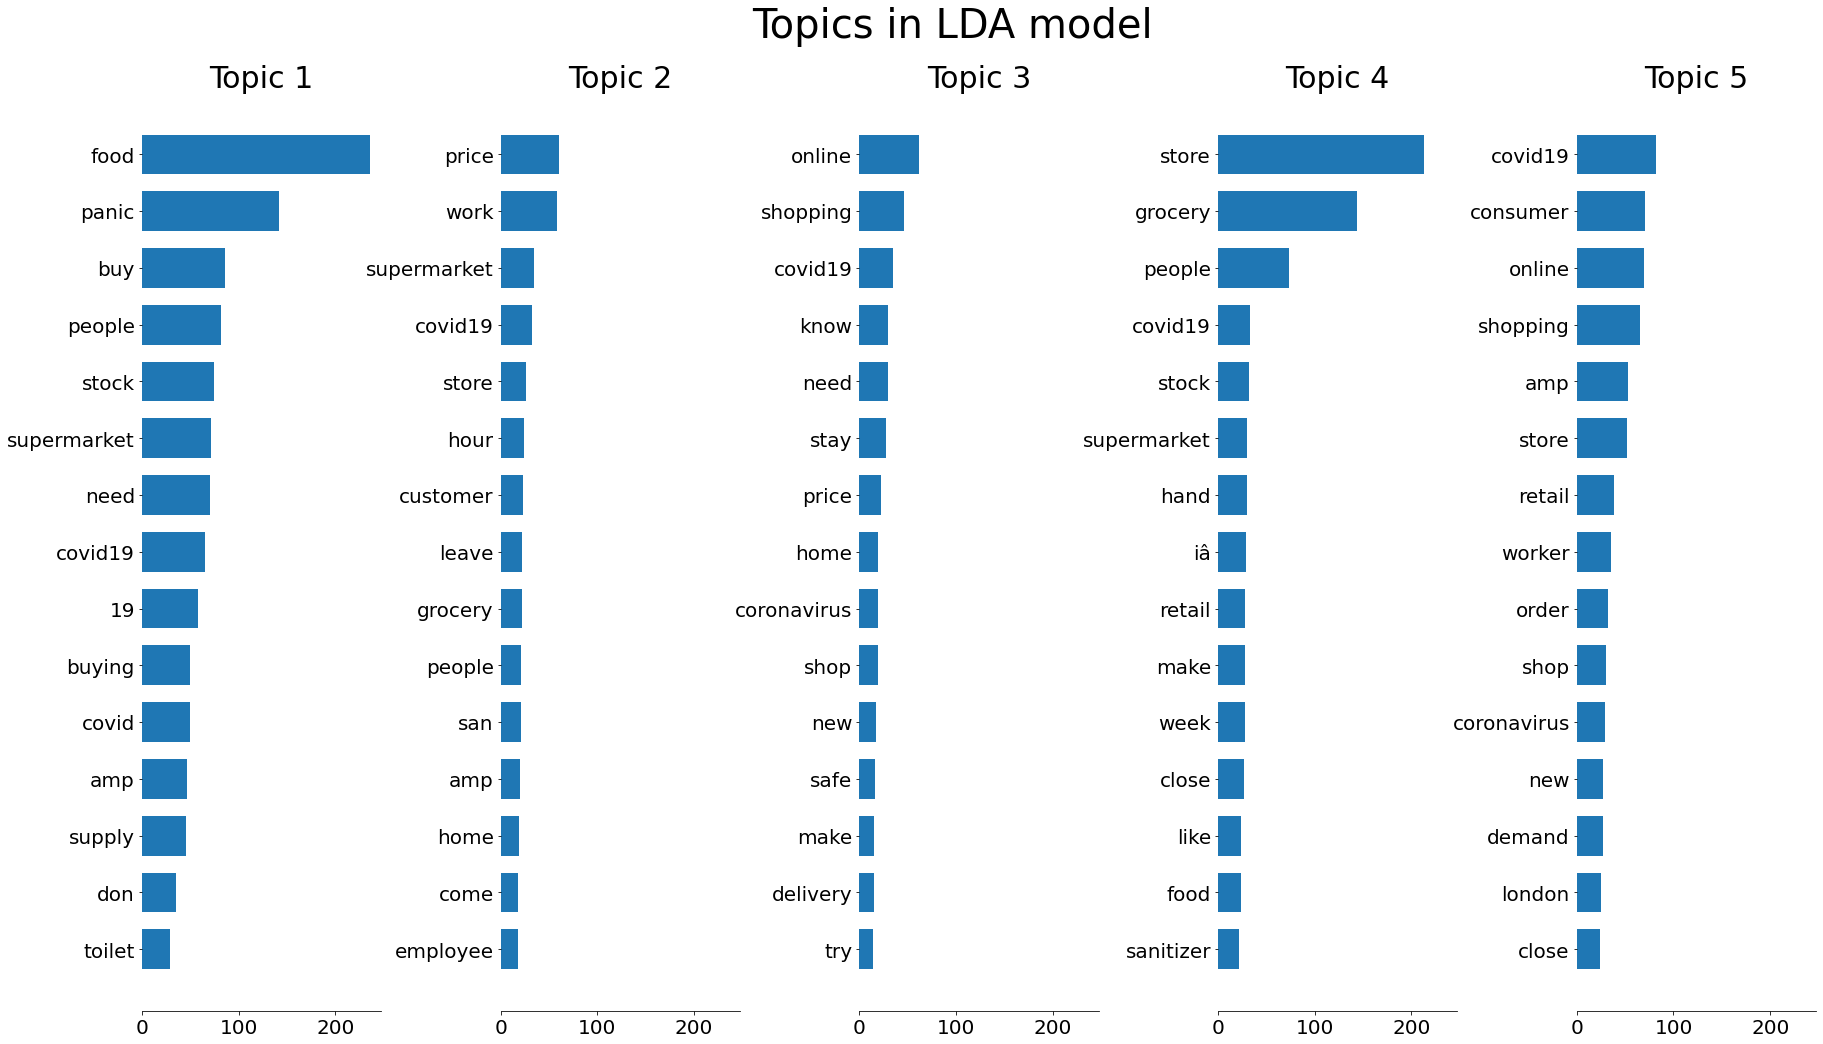

In [103]:
tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

### 23. Generate the second topic model by setting five topics using LDA method and TfidfVectorizer.

In [104]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', lowercase = True, 
                                token_pattern = r'\b[a-zA-Z0-9]{2,}\b', max_df = 0.9, min_df = 5)
document_word_matrix_tf_idf = tfidf_vectorizer.fit_transform(Train_Data['Tweet_texts'])

lda_tf_idf = LatentDirichletAllocation(n_components = 5)
lda_tf_idf.fit(document_word_matrix_tf_idf)

LatentDirichletAllocation(n_components=5)

### 24. Plot the top 15 words for each topic for the second model above.

In [105]:
n_top_words = 15

for index, topic in enumerate(lda_tf_idf.components_):
    print(f'THE TOP {n_top_words} WORDS FOR TOPIC #{index + 1}')
    print([tfidf_vectorizer.get_feature_names()[j] for j in topic.argsort()[-n_top_words:]])
    print('')

THE TOP 15 WORDS FOR TOPIC #1
['drop', 'buy', 'make', 'mask', 'stay', 'feel', 'grocery', 'people', 'just', 'food', 'high', 'store', 'sell', 'stock', 'price']

THE TOP 15 WORDS FOR TOPIC #2
['panic', 'supply', 'outbreak', 'hire', 'cause', 'supermarket', 'amazon', 'covid19', 'say', 'surge', 'united', 'states', 'shopping', 'online', 'food']

THE TOP 15 WORDS FOR TOPIC #3
['online', 'thank', 'people', 'stay', 'supermarket', 'amp', 'work', 'hour', 'time', 'employee', 'amid', 'retail', 'covid19', 'grocery', 'store']

THE TOP 15 WORDS FOR TOPIC #4
['supply', 'consumer', 'close', 'store', 'covid19', 'stock', 'buying', 'people', 'need', 'supermarket', 'buy', 'covid', '19', 'panic', 'food']

THE TOP 15 WORDS FOR TOPIC #5
['staff', 'like', 'people', 'san', 'coronavirus', 'home', 'amp', 'way', 'supermarket', 'grocery', 'consumer', 'worker', 'leave', 'store', 'covid19']



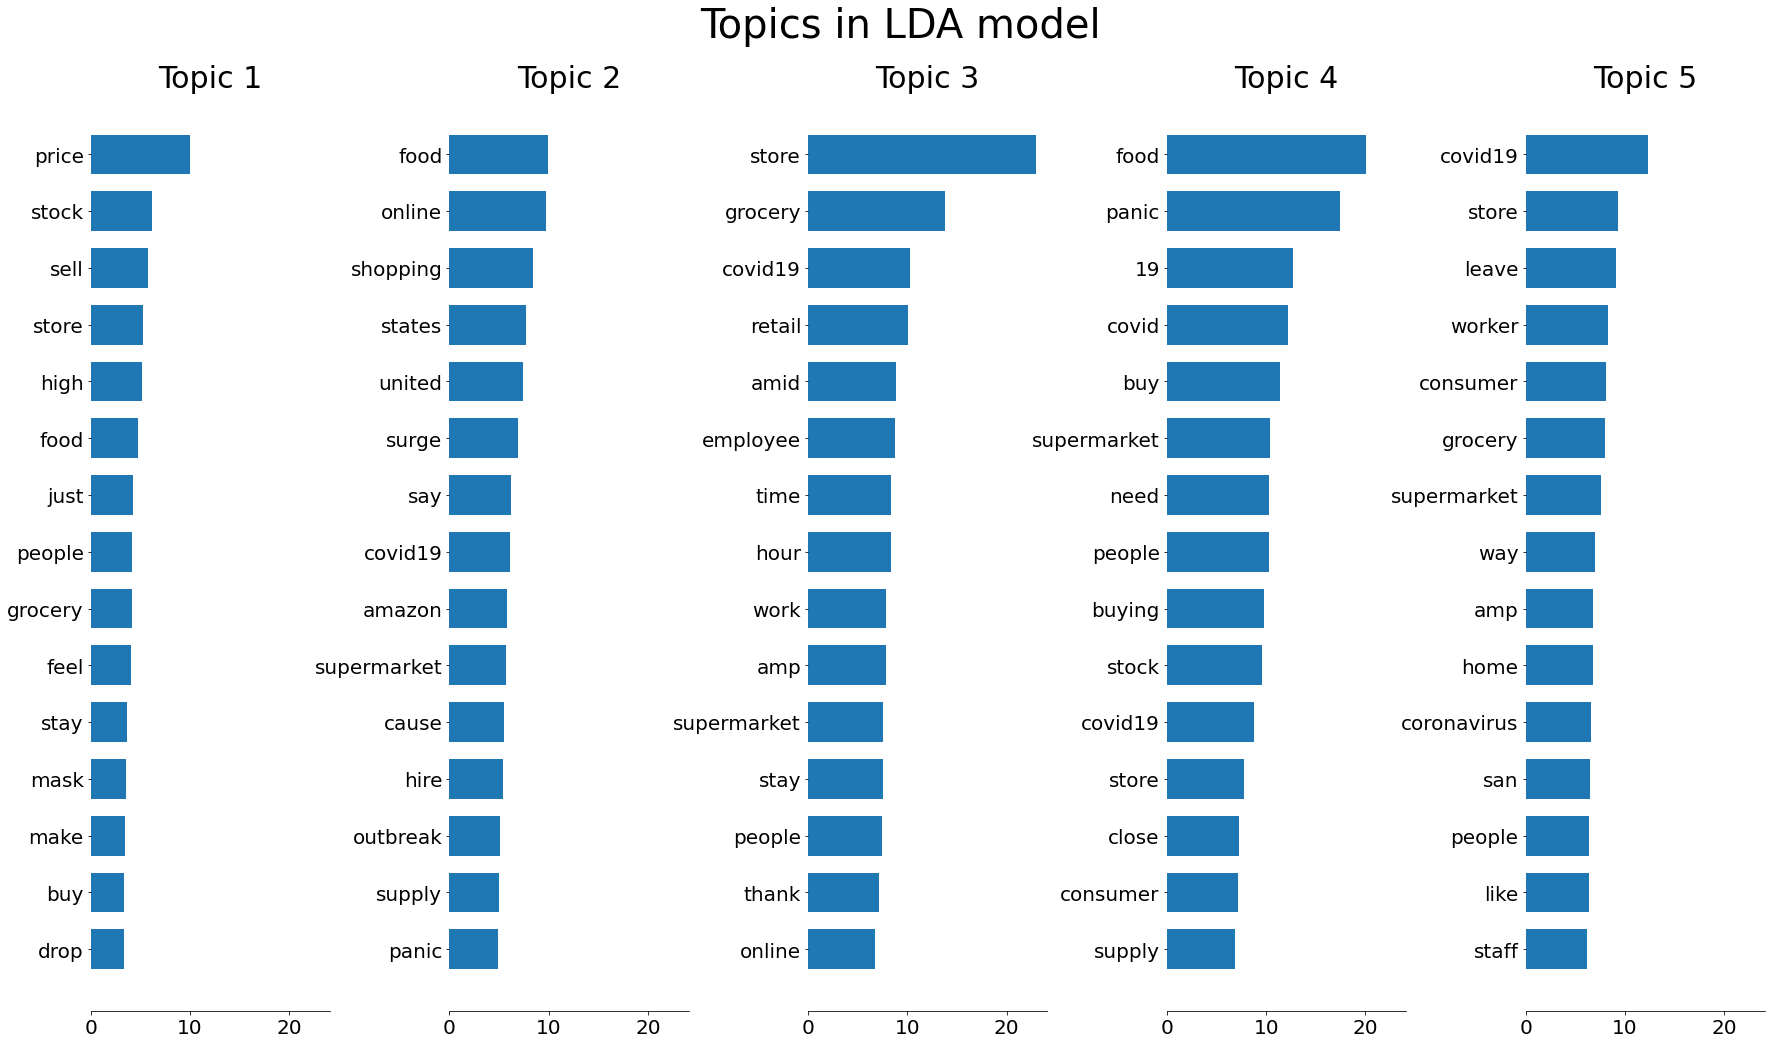

In [106]:
tf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(lda_tf_idf, tf_feature_names, n_top_words, 'Topics in LDA model')

### 25. Visualize the second topic model using the dimension reduction method. (You may choose the method you like)

In [107]:
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_model = lda_tf_idf, dtm = document_word_matrix_tf_idf, vectorizer = tfidf_vectorizer)

/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/GrahamMacbookPro/opt/anac

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
3      0.04 -0.03       1        1 25.02
2     -0.07  0.02       2        1 24.04
4     -0.10 -0.00       3        1 20.22
1      0.05 -0.09       4        1 16.93
0      0.07  0.11       5        1 13.79, topic_info=        Term  Freq  Total Category  logprob  loglift
407    price 17.00  17.00  Default    30.00    30.00
123    covid 10.00  10.00  Default    29.00    29.00
516   states  7.00   7.00  Default    28.00    28.00
4         19 12.00  12.00  Default    27.00    27.00
577   united 10.00  10.00  Default    26.00    26.00
..       ...   ...    ...      ...      ...      ...
548     tell  2.50   7.96   Topic5    -5.11     0.82
68       buy  2.91  17.13   Topic5    -4.96     0.21
561   toilet  2.40  11.64   Topic5    -5.15     0.40
124  covid19  2.39  33.27   Topic5    -5.15    -0.65
488     shop  2.31  14.31   Topic5    -5.19     0.16

[309 rows x 6 columns], token_table=      Topic  Freq    Term
term                     
1         4  0.57     100
1         5  0.28     100
2         4  0.78  100000
4         1  0.81      19
4         3  0.08      19
...     ...   ...     ...
609       3  0.62  worker
609       4  0.09  worker
613       1  0.28   worth
613       5  0.57   worth
618       5  0.80   young

[515 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 5, 2, 1])

[CV 1/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm=l1, vectorizer__stop_words=english, vectorizer__tokenizer=<function spacy_tokenizer at 0x7f9e3829ad30>;, score=0.325 total time=  13.6s
[CV 2/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm=l2, vectorizer__stop_words=english, vectorizer__tokenizer=<function spacy_tokenizer at 0x7f9e5a886310>;, score=0.338 total time=  11.5s
[CV 1/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.0001, vectorizer__max_df=1.0, vectorize

[CV 2/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm=l1, vectorizer__stop_words=None, vectorizer__tokenizer=<function spacy_tokenizer at 0x7fa8912de670>;, score=0.300 total time=  11.5s
[CV 5/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm=l1, vectorizer__stop_words=None, vectorizer__tokenizer=<function spacy_tokenizer at 0x7fa8a1485670>;, score=0.314 total time=   9.7s
[CV 3/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm

[CV 4/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm=l1, vectorizer__stop_words=english, vectorizer__tokenizer=<function spacy_tokenizer at 0x7fcaf4be9af0>;, score=0.219 total time=  13.4s
[CV 5/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm=l2, vectorizer__stop_words=english, vectorizer__tokenizer=<function spacy_tokenizer at 0x7fcb01579280>;, score=0.377 total time=  11.3s
[CV 4/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.0001, vectorizer__max_df=1.0, vectorize

[CV 1/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm=l1, vectorizer__stop_words=None, vectorizer__tokenizer=<function spacy_tokenizer at 0x7fb5c95b4820>;, score=0.319 total time=  11.4s
[CV 3/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm=l2, vectorizer__stop_words=english, vectorizer__tokenizer=<function spacy_tokenizer at 0x7fb601083f70>;, score=0.350 total time=  11.2s
[CV 2/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.0001, vectorizer__max_df=1.0, vectorizer__

[CV 5/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm=l1, vectorizer__stop_words=english, vectorizer__tokenizer=<function spacy_tokenizer at 0x7f911029bca0>;, score=0.358 total time=  15.1s
[CV 1/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm=l2, vectorizer__stop_words=None, vectorizer__tokenizer=<function spacy_tokenizer at 0x7f9150dd5a60>;, score=0.325 total time=   9.2s
[CV 4/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__n

[CV 2/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm=l1, vectorizer__stop_words=english, vectorizer__tokenizer=<function spacy_tokenizer at 0x7fc958e8c0d0>;, score=0.306 total time=  14.2s
[CV 4/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm=l1, vectorizer__stop_words=None, vectorizer__tokenizer=<function spacy_tokenizer at 0x7fc958e8cdc0>;, score=0.225 total time=   9.5s
[CV 2/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__n

[CV 3/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm=l1, vectorizer__stop_words=english, vectorizer__tokenizer=<function spacy_tokenizer at 0x7f9aa121a310>;, score=0.369 total time=  13.8s
[CV 1/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm=l2, vectorizer__stop_words=english, vectorizer__tokenizer=<function spacy_tokenizer at 0x7f9aa121adc0>;, score=0.319 total time=  11.6s
[CV 5/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer

[CV 3/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm=l1, vectorizer__stop_words=None, vectorizer__tokenizer=<function spacy_tokenizer at 0x7fade98eb670>;, score=0.344 total time=  11.3s
[CV 4/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.001, vectorizer__max_df=1.0, vectorizer__norm=l2, vectorizer__stop_words=english, vectorizer__tokenizer=<function spacy_tokenizer at 0x7fade98eb700>;, score=0.281 total time=  11.6s
[CV 3/5] END classifier__estimator=LogisticRegression(), classifier__estimator__max_iter=100, classifier__estimator__penalty=l2, classifier__estimator__solver=liblinear, classifier__estimator__tol=0.0001, vectorizer__max_df=1.0, vectorizer__